In [155]:
import pandas as pd
import os
import numpy as np
import sklearn
import seaborn as sns

from IPython import display


# Plot pretty:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Lasso, Ridge, ElasticNet


from sklearn.model_selection import cross_val_predict


sns.set_theme(style="whitegrid")

In [739]:
from platform import python_version
python_version()

print(tf.__version__)

2.8.0


In [156]:
housing = np.loadtxt("train_set.txt")
holdout_validation = np.loadtxt("test_set.txt")

with open("features.txt", "rb") as fp:   # Unpickling
    feature_names = pickle.load(fp)


In [157]:
print("Trainging data", housing.shape) 
print("holdout set:", holdout_validation.shape)
print("# of features:", len(feature_names))

Trainging data (25615, 81)
holdout set: (6380, 81)
# of features: 81


In [158]:
feature_names

['salePrice_b',
 'soccerfield_h',
 'numberOfBaths_bd',
 'breakInStatistic',
 'propertyCharges',
 'unemploymentRateCPH_s',
 'priceIndex_s',
 'forest_h',
 'numberOfFloors_b',
 'metro_h',
 'publicbath_h',
 'sportshall_h',
 'train_h',
 'mortgageRate_s',
 'busstop_h',
 'OMXC20_s',
 'school_h',
 'supermarket_h',
 'coast_h',
 'pharmacy_h',
 'floor_b',
 'junction_h',
 'roadtrain_h',
 'hospital_h',
 'daycare_h',
 'turnoutVote_d',
 'salesYear_b',
 'airport_h',
 'lake_h',
 'doctor_h',
 'library_h',
 'radonRiskCategory_d',
 'priceChangeMPriorIndex_s',
 'strain_h',
 'alfs_area',
 'areaBasement',
 'numberOfRooms',
 'aboveSea_d',
 'numberOfToilets_bd',
 'rebuildYear_b',
 'buildYear_b',
 'salesPeriod',
 'postalId_b_1200-1300',
 'postalId_b_1300-1400',
 'postalId_b_1400-1450',
 'postalId_b_1450-1500',
 'postalId_b_1500-1600',
 'postalId_b_1600-1700',
 'postalId_b_1700-1800',
 'postalId_b_1800-1850',
 'postalId_b_1850-1900',
 'postalId_b_1900-2000',
 'postalId_b_2100',
 'postalId_b_2150',
 'postalId_b_2

In [159]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


## Linear Regression

In [686]:
Find_target = 0

pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

lin_reg = LinearRegression()
lin_reg.fit(pre_X, pre_y)


pred_val = lin_reg.predict(pre_X)
exp_pred_val = np.exp(pred_val)

print("Predictions:",)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y),exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))

housing_predictions = lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)

lin_scores = cross_val_score(lin_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Predictions:
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 526587.9020558344
Relative loss: 0.12325001546412229
Linear rmse: 0.15974712248027542
Scores: [0.15766833 0.16018814 0.15501467 0.16873062 0.16155217 0.16579096
 0.16209531 0.15611037 0.1624874  0.15471818]
Mean: 0.16043561285456726
Standard deviation: 0.00440681846468107


In [230]:
from scipy import stats
confidence = 0.95
squared_errors = (housing_predictions - pre_y) ** 2
np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1, 
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.15696335, 0.16248321])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


<Figure size 1008x432 with 0 Axes>

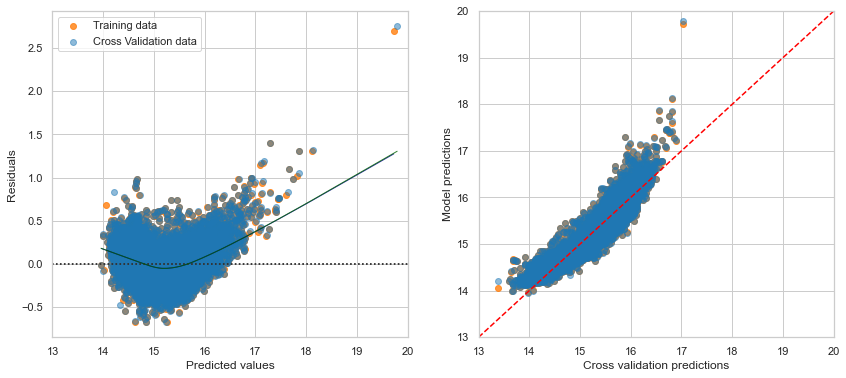

In [470]:
plt.figure(figsize = (14, 6))
def plot_resid(pred_val, cv_val, y, name):
    plt.figure(figsize = (14, 6))
    ax = plt.subplot(1,2,1)
    sns.residplot(x=pred_val, y=pred_val - y, lowess=True, color = "tab:orange", 
                              scatter_kws={'alpha': 0.8}, 
                              line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
    sns.residplot(x=cv_val, y=cv_val - y, lowess=True, color = "tab:blue", 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'darkgreen', 'lw': 1, 'alpha': 0.8}, label='Cross Validation data')

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.xlim([13, 20])

    ax = plt.subplot(1,2,2)
    plt.scatter(y, pred_val, alpha=0.8, c = "tab:orange")
    plt.scatter(y, cv_val, alpha=0.5, c = "tab:blue")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
    plt.ylabel('Model predictions')
    plt.xlabel('Cross validation predictions')
    plt.xlim([13, 20])
    plt.ylim([13, 20])
    plt.savefig(name)
    
    
predicted = cross_val_predict(lin_reg, pre_X, pre_y, cv=10, verbose = 1)
    

plot_resid(pred_val, predicted, pre_y, "reg_linresscatter")





### Ridge regression

In [203]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

rid_lin_reg = Ridge(alpha = 100)
rid_lin_reg.fit(pre_X, pre_y)

pred_val = rid_lin_reg.predict(pre_X)
exp_pred_val = np.exp(pred_val)
print("Predictions:",)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))

housing_predictions = rid_lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)

lin_scores = cross_val_score(rid_lin_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


#predicted = cross_val_predict(rid_lin_reg, pre_X, pre_y, cv=10, verbose = 0)   
#plot_resid(pred_val, predicted, pre_y)

Predictions:
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 527696.8423018671
Relative loss: 0.12385798569729897
Linear rmse: 0.16019502497529195
Scores: [0.1578717  0.16078112 0.15487203 0.16926526 0.16211539 0.16617454
 0.16230366 0.15673848 0.1635283  0.15470048]
Mean: 0.1608350963812656
Standard deviation: 0.004575861352839723


In [204]:
pd.set_option('display.max_rows', None)
coefs2 = pd.DataFrame(
    rid_lin_reg.coef_,
    columns=['Coefficients'], index=feature_names[1:]
)
coefs2['Coefficients_abs'] = np.abs(coefs2['Coefficients'])
coefs2.sort_values(by=['Coefficients_abs'])

Coefficients  \
soccerfield_h                                          -0.000636   
numberOfFloors_b                                        0.000764   
outerwall_d_Mursten                                    -0.000826   
mortgageRate_s                                         -0.001236   
priceChangeMPriorIndex_s                                0.001374   
roadtrain_h                                            -0.001820   
quarter_b                                              -0.002123   
OMXC20_s                                                0.002168   
train_h                                                -0.002492   
supermarket_h                                          -0.002577   
rebuildYear_b                                           0.002815   
numberOfBaths_bd                                       -0.003130   
daycare_h                                              -0.003471   
doctor_h                                               -0.003779   
postalId_b_1800-1850                                    0.004057   
library_h                                               0.004343   
floodingRisk_d                                         -0.004544   
propertyCharges                                        -0.004902   
airport_h                                               0.005220   
postalId_b_1500-1600                                   -0.005580   
postalId_b_1400-1450                                    0.006482   
outerwall_d_rare                                       -0.007167   
publicbath_h                                           -0.007197   
school_h                                                0.007486   
unemploymentRateCPH_s                                   0.007791   
roof_d_Tegl                                            -0.008578   
pharmacy_h                                             -0.009011   
postalId_b_1900-2000                                    0.009175   
postalId_b_1450-1500                                   -0.010431   
roof_d_Betontagsten                                    -0.010624   
outerwall_d_Betonelementer                             -0.012394   
radonRiskCategory_d                                    -0.012563   
noise_d                                                -0.013426   
roof_d_Tagpap med stor hældning                        -0.013673   
roof_d_Fibercement herunder asbest                     -0.013807   
postalId_b_1600-1700                                   -0.013904   
sportshall_h                                            0.014036   
junction_h                                              0.014674   
buildYear_b                                            -0.014705   
turnoutVote_d                                           0.016994   
aboveSea_d                                              0.017613   
strain_h                                               -0.019679   
forest_h                                                0.020232   
salesPeriod                                            -0.021186   
numberOfToilets_bd                                     -0.022139   
postalId_b_2100                                         0.023211   
postalId_b_2720                                        -0.023447   
areaBasement                                            0.024148   
postalId_b_1200-1300                                    0.024386   
breakInStatistic                                       -0.025053   
biggestParty_d_b Socialdemokratiet                      0.025221   
salesYear_b                                             0.025314   
roof_d_rare                                             0.025431   
postalId_b_<1100                                        0.026480   
roof_d_Tagpap med lille hældning                       -0.026485   
postalId_b_1300-1400                                    0.028842   
postalId_b_2450                                        -0.031176   
postalId_b_1700-1800                                    0.031693   
postalId_b_2500                         

In [ ]:
Predictions:
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 526588.7673643304
Relative loss: 0.12325620027809589
Linear rmse: 0.15974964556737542
Scores: [0.15765949 0.16019968 0.15499255 0.16873622 0.16155057 0.16579805
 0.1620679  0.15609177 0.16252655 0.1546856 ]
Mean: 0.1604308376300271
Standard deviation: 0.004418780992598491

### Lasso regression

In [244]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

las_lin_reg = Lasso(alpha = 0.001)
las_lin_reg.fit(pre_X, pre_y)

pred_val = las_lin_reg.predict(pre_X)
exp_pred_val = np.exp(pred_val)
print("Predictions:", exp_pred_val)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))

housing_predictions = las_lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)

lin_scores = cross_val_score(las_lin_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

predicted = cross_val_predict(las_lin_reg, pre_X, pre_y, cv=10, verbose = 0)   
#plot_resid(pred_val, predicted, pre_y)

Predictions: [2338667.71468772 3233062.68686377 5132925.16521336 ... 5777256.26276402
 1756502.83241237 5104472.63964065]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 538061.9982029912
Relative loss: 0.12594265291098652
Linear rmse: 0.16229825858263405
Scores: [0.1598093  0.16268114 0.15655002 0.17191554 0.16431362 0.16773145
 0.16366426 0.15908015 0.16546053 0.15646793]
Mean: 0.1627673939087982
Standard deviation: 0.0046847749281797675


In [222]:
pd.set_option('display.max_rows', None)
coefs2 = pd.DataFrame(
    las_lin_reg.coef_,
    columns=['Coefficients'], index=feature_names[1:]
)
coefs2['Coefficients_abs'] = np.abs(coefs2['Coefficients'])
coefs2.sort_values(by=['Coefficients_abs'])

Coefficients  \
soccerfield_h                                           0.000000   
postalId_b_2500                                        -0.000000   
postalId_b_2450                                         0.000000   
postalId_b_2400                                        -0.000000   
postalId_b_2300                                        -0.000000   
postalId_b_2200                                        -0.000000   
postalId_b_2150                                         0.000000   
postalId_b_2100                                         0.000000   
postalId_b_2700                                        -0.000000   
postalId_b_1900-2000                                    0.000000   
postalId_b_1800-1850                                    0.000000   
postalId_b_1700-1800                                    0.000000   
postalId_b_1600-1700                                    0.000000   
postalId_b_1500-1600                                    0.000000   
postalId_b_1450-1500                                    0.000000   
postalId_b_1400-1450                                    0.000000   
postalId_b_1300-1400                                    0.000000   
postalId_b_1850-1900                                    0.000000   
postalId_b_1200-1300                                    0.000000   
postalId_b_2720                                        -0.000000   
usage_d_detached house                                  0.000000   
radonRisk_d                                             0.000000   
energyMark_b                                           -0.000000   
noise_d                                                -0.000000   
biggestParty_d_d Vesntre                                0.000000   
biggestParty_d_c Radikale                               0.000000   
biggestParty_d_b Socialdemokratiet                     -0.000000   
roof_d_rare                                             0.000000   
postalId_b_<1100                                        0.000000   
roof_d_Tegl                                            -0.000000   
roof_d_Tagpap med lille hældning                        0.000000   
roof_d_Fibercement herunder asbest                      0.000000   
roof_d_Betontagsten                                    -0.000000   
outerwall_d_rare                                        0.000000   
outerwall_d_Mursten                                    -0.000000   
outerwall_d_Betonelementer                              0.000000   
usage_d_townhouse, chain house, semi-detached h...      0.000000   
roof_d_Tagpap med stor hældning                        -0.000000   
salesPeriod                                             0.000000   
buildYear_b                                            -0.000000   
rebuildYear_b                                           0.000000   
supermarket_h                                           0.000000   
school_h                                                0.000000   
OMXC20_s                                                0.000000   
busstop_h                                               0.000000   
mortgageRate_s                                         -0.000000   
train_h                                                -0.000000   
sportshall_h                                            0.000000   
coast_h                                                -0.000000   
publicbath_h                                            0.000000   
numberOfFloors_b                                        0.000000   
forest_h                                                0.000000   
priceIndex_s                                            0.000000   
unemploymentRateCPH_s                                   0.000000   
propertyCharges                                         0.000000   
breakInStatistic                                       -0.000000   
numberOfBaths_bd                                        0.000000   
metro_h                                                -0.000000   
pharmacy_h                              

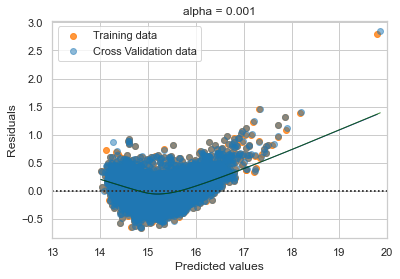

In [245]:
sns.residplot(x=pred_val, y=pred_val - pre_y, lowess=True, color = "tab:orange", 
                          scatter_kws={'alpha': 0.8}, 
                          line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
sns.residplot(x=predicted, y=predicted - pre_y, lowess=True, color = "tab:blue", 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'darkgreen', 'lw': 1, 'alpha': 0.8}, label='Cross Validation data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('alpha = 0.001')
plt.legend(loc='upper left')
plt.xlim([13, 20])
plt.savefig("alpha001")

Predictions: [2336310.36648986 3249488.301877   5170416.67053095 ... 5757840.40703609
 1744108.26214168 4967314.1453396 ]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 532608.1483715962
Relative loss: 0.1247022702107555
Linear rmse: 0.16104474068543115
Scores: [0.15883165 0.16132869 0.15536394 0.17046241 0.16270774 0.16700775
 0.16284521 0.1574132  0.16419709 0.1551735 ]
Mean: 0.16153311579193846
Standard deviation: 0.00471931011716448


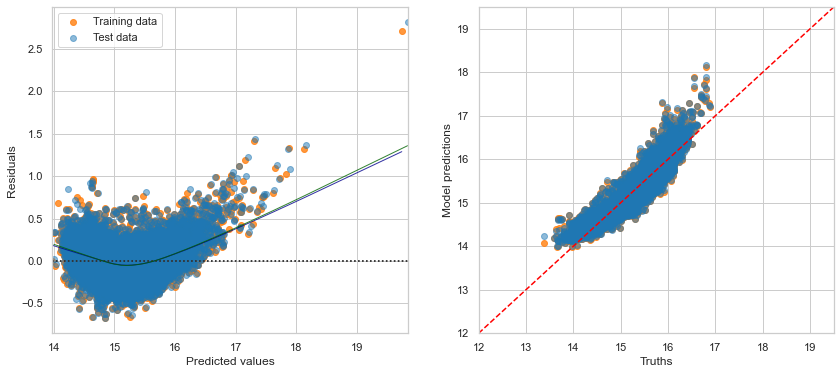

In [139]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

net_lin_reg = ElasticNet(alpha=0.001, l1_ratio=0.5)
net_lin_reg.fit(pre_X, pre_y)

print("Predictions:",np.exp(net_lin_reg.predict(pre_X)))
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), np.exp(net_lin_reg.predict(pre_X))))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), np.exp(net_lin_reg.predict(pre_X))))

housing_predictions = net_lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)

lin_scores = cross_val_score(net_lin_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


predicted = cross_val_predict(net_lin_reg, pre_X, pre_y, cv=10, verbose = 0)   
plot_resid(pred_val, predicted, pre_y)

## Polynomial regression

In [474]:
find_zeroes = np.where(poly_lin_reg.coef_== 0, 1, 0)
poly_lin_reg.coef_[1]
find_zeroes.sum()

89

In [471]:
Find_target = 0

pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)


poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(pre_X)



print(X_poly.shape)

(25615, 3320)


In [321]:
from sklearn.pipeline import make_pipeline
poly_features = PolynomialFeatures(degree = 2, include_bias=False)

poly_pipeline = make_pipeline(poly_features, 
                              LinearRegression())

poly_pipeline.fit(pre_X, pre_y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ........................ score: (test=-53507419.798) total time=  28.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s
[CV] START .....................................................................
[CV] END ................... score: (test=-1652503590601.612) total time=  27.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.1s remaining:    0.0s
[CV] START .....................................................................
[CV] END .......................... score: (test=-643710.385) total time=  26.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[CV] START .....................................................................
[CV] END ...................... score: (test=-3676831485.148) total time=  29.5s
[Parallel(n_jobs=1)]: Done   4 

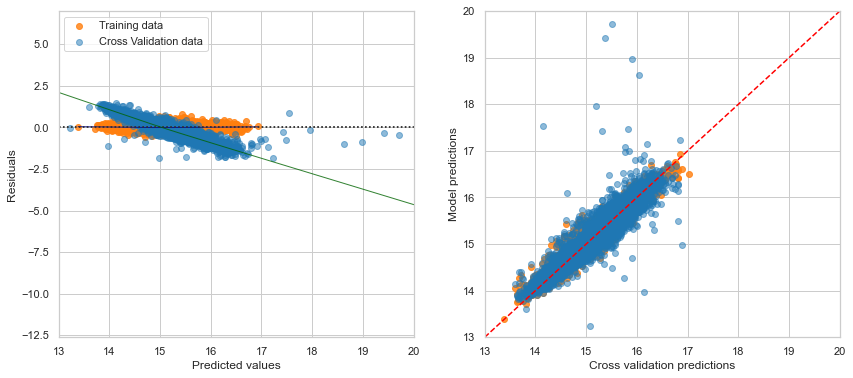

In [473]:
poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_poly, pre_y)




lin_scores = cross_val_score(poly_lin_reg, X_poly, pre_y,
                             scoring="neg_mean_squared_error", cv=10, verbose = 50)


pred_val = poly_lin_reg.predict(X_poly)
exp_pred_val = np.exp(pred_val)

print("Predictions:",exp_pred_val)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))


housing_predictions = poly_lin_reg.predict(X_poly)

lin_mse = mean_squared_error(pre_y, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)


lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

predicted = cross_val_predict(poly_lin_reg, X_poly, pre_y, cv=10, verbose = 0)   
plot_resid(pred_val, predicted, pre_y, "poly_resid_plot")

In [482]:
las_poly_lin_reg = Lasso(alpha=0.01)
las_poly_lin_reg.fit(X_poly, pre_y)


pred_val = las_poly_lin_reg.predict(X_poly)
exp_pred_val = np.exp(las_poly_lin_reg.predict(X_poly))
print("Predictions:",exp_pred_val)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))


housing_predictions = las_poly_lin_reg.predict(X_poly)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)


Predictions: [2305633.20123028 3197701.08177617 5405320.53849749 ... 6207639.18526384
 1661346.29685202 5676595.6371984 ]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 427708.4603051264
Relative loss: 0.1073808669239354
Linear rmse: 0.13831534057147096


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.019) total time=  14.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.019) total time=  12.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.5s remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.019) total time=  23.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.2s remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.022) total time=  17.4s
[Parallel(n_jobs=1)]: Done   4 

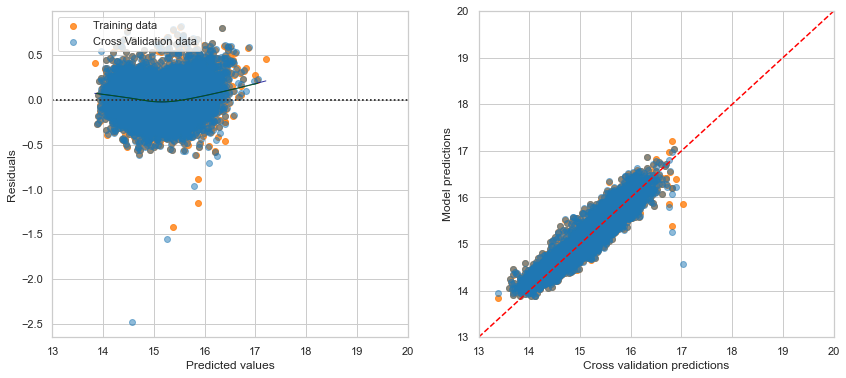

In [484]:


lin_scores = cross_val_score(las_poly_lin_reg, X_poly, pre_y,
                             scoring="neg_mean_squared_error", cv=10, verbose = 50)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

predicted = cross_val_predict(las_poly_lin_reg, X_poly, pre_y, cv=10, verbose = 50)   
plot_resid(pred_val, predicted, pre_y, "poly_resid_plot")

In [478]:
find_zeroes = np.where(las_poly_lin_reg.coef_== 0, 1, 0)
find_zeroes.sum()

2953

In [ ]:
# 2.grads polynomium
Predictions: [2069198.06186185 3737021.84077295 6045624.08082299 ... 5140709.01512146
 1571819.6849598  4827863.13506679]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 304015.61671491736
Relative loss: 0.09399404136979864
Linear rmse: 0.14036523854039434
Scores: [45876463.29197529 21697570.65193062 27835419.45198506  3101413.57428594
 20162585.01861357]
Mean: 23734690.397758096
Standard deviation: 13781988.186381957

In [ ]:
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(pre_X)

net_lin_reg = ElasticNet(alpha=0.001, l1_ratio=0.5)
net_lin_reg.fit(X_poly, pre_y)

exp_pred_val = np.exp(net_poly_lin_reg.predict(X_poly))
print("Predictions:",exp_pred_val)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))

housing_predictions = net_lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)

lin_scores = cross_val_score(net_lin_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [32]:
from sklearn.linear_model import Lasso
SGD_poly_lin_reg = Lasso(alpha=0.01)
SGD_poly_lin_reg.fit(X_poly, pre_y)


exp_pred_val = np.exp(SGD_poly_lin_reg.predict(X_poly))
print("Predictions:",exp_pred_val)
print("Label-values:", np.exp(pre_y))


Predictions: [2249932.3979644  3235622.77270148 5382464.9544359  ... 6023240.19312262
 1586884.00680342 5648515.39196808]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]


In [34]:
print("Absolute error:", mean_absolute_error(np.exp(pre_y), exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))


Absolute error: 436892.836150117
Relative loss: 0.1578015690760031


## Random Forest Regressor

In [513]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)


forest_reg = RandomForestRegressor()
forest_reg.fit(pre_X, pre_y)
forest_reg

RandomForestRegressor()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time= 1.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=  54.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=  56.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=  54.8s
[Parallel(n_jobs=1)]: Done   4 

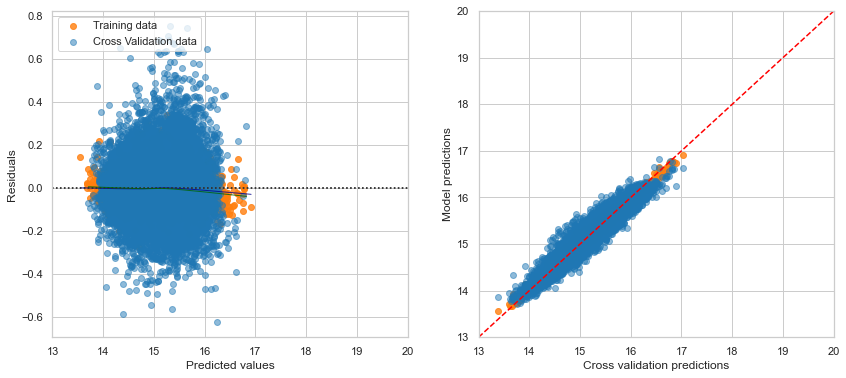

In [514]:
forest_scores = cross_val_score(forest_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10, verbose = 50, n_jobs = 1)


forest_rmse_scores = np.sqrt(-forest_scores)

housing_predictions = forest_reg.predict(pre_X)
forest_mse = mean_squared_error(pre_y, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Forest rmse:", forest_rmse)

forest_pred_val = forest_reg.predict(pre_X)
forest_exp_pred = np.exp(forest_pred_val)
print("Predictions:",fores_exp_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), forest_exp_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), forest_exp_pred))

display_scores(forest_rmse_scores)

predicted_forest = cross_val_predict(forest_reg, pre_X, pre_y, cv=10, verbose = 0)   

plot_resid(forest_pred_val, predicted_forest, pre_y, "forest_resid1")

In [ ]:
Default hyper parameters:
Predictions: [1807665.12308191 3546803.16389145 5780946.26071967 ... 5283454.32456475
 1564727.8363363  5515004.35808935]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 140264.9868577171
Relative loss: 0.04017267675241933
Scores: [0.19054006 0.19445926]
Mean: 0.19249965643909078
Standard deviation: 0.0019596000785420536

In [462]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]

# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7, 8]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 20, num = 5)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [20, 60, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 15]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300], 'max_features': [2, 3, 4, 5, 6, 7, 8], 'max_depth': [4, 8, 12, 16, 20], 'min_samples_split': [20, 60, 100], 'min_samples_leaf': [5, 10, 15], 'bootstrap': [True]}


In [463]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
forest_reg = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
forest_reg_random = RandomizedSearchCV(estimator = forest_reg, param_distributions = random_grid,
                                       n_iter = 200, cv = 5, verbose=30, random_state=42, n_jobs = 1)
# Fit the random search model
forest_reg_random.fit(pre_X, pre_y)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5; 1/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100
[CV 1/5; 1/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100;, score=0.880 total time=   3.4s
[CV 2/5; 1/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100
[CV 2/5; 1/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100;, score=0.872 total time=   3.4s
[CV 3/5; 1/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100
[CV 3/5; 1/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=5, min_samples_split=60, n_estimators=100;, score=0.873 total time=   3.0s
[CV 4/5; 1/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_l

[CV 5/5; 6/200] END bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, score=0.920 total time=   1.7s
[CV 1/5; 7/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150
[CV 1/5; 7/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150;, score=0.855 total time=   3.8s
[CV 2/5; 7/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150
[CV 2/5; 7/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150;, score=0.851 total time=   3.5s
[CV 3/5; 7/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150
[CV 3/5; 7/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=150;, score=0.855 total time=  

[CV 4/5; 12/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.878 total time=   3.2s
[CV 5/5; 12/200] START bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100
[CV 5/5; 12/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100;, score=0.881 total time=   2.9s
[CV 1/5; 13/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 1/5; 13/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.747 total time=   4.2s
[CV 2/5; 13/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 2/5; 13/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.738

[CV 3/5; 18/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200;, score=0.902 total time=   5.9s
[CV 4/5; 18/200] START bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200
[CV 4/5; 18/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200;, score=0.906 total time=   5.7s
[CV 5/5; 18/200] START bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200
[CV 5/5; 18/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200;, score=0.904 total time=   6.0s
[CV 1/5; 19/200] START bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=60, n_estimators=100
[CV 1/5; 19/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=60, n_estimators=100;, score=

[CV 2/5; 24/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.904 total time=   9.2s
[CV 3/5; 24/200] START bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 3/5; 24/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.909 total time=   9.0s
[CV 4/5; 24/200] START bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 4/5; 24/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.911 total time=  10.1s
[CV 5/5; 24/200] START bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 5/5; 24/200] END bootstrap=True, max_depth=16, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.913

[CV 1/5; 30/200] END bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.785 total time=   3.9s
[CV 2/5; 30/200] START bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300
[CV 2/5; 30/200] END bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.772 total time=   3.8s
[CV 3/5; 30/200] START bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300
[CV 3/5; 30/200] END bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.780 total time=   3.8s
[CV 4/5; 30/200] START bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300
[CV 4/5; 30/200] END bootstrap=True, max_depth=12, max_features=2, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.788

[CV 5/5; 35/200] END bootstrap=True, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=60, n_estimators=50;, score=0.832 total time=   1.0s
[CV 1/5; 36/200] START bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100
[CV 1/5; 36/200] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100;, score=0.868 total time=   2.1s
[CV 2/5; 36/200] START bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100
[CV 2/5; 36/200] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100;, score=0.858 total time=   2.1s
[CV 3/5; 36/200] START bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100
[CV 3/5; 36/200] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100;, 

[CV 4/5; 41/200] END bootstrap=True, max_depth=16, max_features=2, min_samples_leaf=15, min_samples_split=100, n_estimators=200;, score=0.768 total time=   2.5s
[CV 5/5; 41/200] START bootstrap=True, max_depth=16, max_features=2, min_samples_leaf=15, min_samples_split=100, n_estimators=200
[CV 5/5; 41/200] END bootstrap=True, max_depth=16, max_features=2, min_samples_leaf=15, min_samples_split=100, n_estimators=200;, score=0.773 total time=   2.5s
[CV 1/5; 42/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=150
[CV 1/5; 42/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=150;, score=0.701 total time=   2.0s
[CV 2/5; 42/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=150
[CV 2/5; 42/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=150;, score

[CV 3/5; 47/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=100;, score=0.851 total time=   2.6s
[CV 4/5; 47/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=100
[CV 4/5; 47/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=100;, score=0.855 total time=   2.3s
[CV 5/5; 47/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=100
[CV 5/5; 47/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=100;, score=0.853 total time=   2.2s
[CV 1/5; 48/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=15, min_samples_split=60, n_estimators=150
[CV 1/5; 48/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.8

[CV 2/5; 53/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.899 total time=   3.0s
[CV 3/5; 53/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 3/5; 53/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.901 total time=   3.0s
[CV 4/5; 53/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 4/5; 53/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.905 total time=   3.5s
[CV 5/5; 53/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 5/5; 53/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.907

[CV 1/5; 59/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100;, score=0.845 total time=   1.7s
[CV 2/5; 59/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100
[CV 2/5; 59/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100;, score=0.833 total time=   1.7s
[CV 3/5; 59/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100
[CV 3/5; 59/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100;, score=0.847 total time=   1.8s
[CV 4/5; 59/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100
[CV 4/5; 59/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=60, n_estimators=100;, scor

[CV 5/5; 64/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.908 total time=   5.0s
[CV 1/5; 65/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250
[CV 1/5; 65/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250;, score=0.730 total time=   3.9s
[CV 2/5; 65/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250
[CV 2/5; 65/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250;, score=0.720 total time=   3.8s
[CV 3/5; 65/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250
[CV 3/5; 65/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=250;, scor

[CV 4/5; 70/200] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=5, min_samples_split=60, n_estimators=150;, score=0.916 total time=   5.7s
[CV 5/5; 70/200] START bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=5, min_samples_split=60, n_estimators=150
[CV 5/5; 70/200] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=5, min_samples_split=60, n_estimators=150;, score=0.916 total time=   6.4s
[CV 1/5; 71/200] START bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=300
[CV 1/5; 71/200] END bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.545 total time=   2.5s
[CV 2/5; 71/200] START bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=300
[CV 2/5; 71/200] END bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=300;, score=0.545 tot

[CV 3/5; 76/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.593 total time=   1.0s
[CV 4/5; 76/200] START bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 4/5; 76/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.651 total time=   1.0s
[CV 5/5; 76/200] START bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 5/5; 76/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.626 total time=   1.0s
[CV 1/5; 77/200] START bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=300
[CV 1/5; 77/200] END bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=20, n_estimators=300;, score=0.907 to

[CV 2/5; 82/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, score=0.737 total time=   0.8s
[CV 3/5; 82/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50
[CV 3/5; 82/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, score=0.724 total time=   0.9s
[CV 4/5; 82/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50
[CV 4/5; 82/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, score=0.750 total time=   0.9s
[CV 5/5; 82/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50
[CV 5/5; 82/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, score=0.727 total time=  

[CV 1/5; 88/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50;, score=0.863 total time=   1.0s
[CV 2/5; 88/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50
[CV 2/5; 88/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50;, score=0.857 total time=   1.1s
[CV 3/5; 88/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50
[CV 3/5; 88/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50;, score=0.862 total time=   1.1s
[CV 4/5; 88/200] START bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50
[CV 4/5; 88/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=50;, scor

[CV 5/5; 93/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=100;, score=0.693 total time=   1.4s
[CV 1/5; 94/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300
[CV 1/5; 94/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300;, score=0.743 total time=   5.1s
[CV 2/5; 94/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300
[CV 2/5; 94/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300;, score=0.737 total time=   5.7s
[CV 3/5; 94/200] START bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300
[CV 3/5; 94/200] END bootstrap=True, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300;, score=0.74

[CV 4/5; 99/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.734 total time=   3.8s
[CV 5/5; 99/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 5/5; 99/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.731 total time=   3.8s
[CV 1/5; 100/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200
[CV 1/5; 100/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200;, score=0.717 total time=   2.7s
[CV 2/5; 100/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200
[CV 2/5; 100/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200;, score=0

[CV 3/5; 105/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=0.631 total time=   2.0s
[CV 4/5; 105/200] START bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 4/5; 105/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=0.619 total time=   2.0s
[CV 5/5; 105/200] START bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 5/5; 105/200] END bootstrap=True, max_depth=4, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=0.605 total time=   2.1s
[CV 1/5; 106/200] START bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=5, min_samples_split=60, n_estimators=250
[CV 1/5; 106/200] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=5, min_samples_split=60, n_estimators=250;, score=0.8

[CV 2/5; 111/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.777 total time=   2.0s
[CV 3/5; 111/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150
[CV 3/5; 111/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.798 total time=   1.9s
[CV 4/5; 111/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150
[CV 4/5; 111/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.773 total time=   2.0s
[CV 5/5; 111/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150
[CV 5/5; 111/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=15, min_samples_split=60, n_estimators=150

[CV 1/5; 117/200] END bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250;, score=0.889 total time=   7.0s
[CV 2/5; 117/200] START bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250
[CV 2/5; 117/200] END bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250;, score=0.886 total time=   7.1s
[CV 3/5; 117/200] START bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250
[CV 3/5; 117/200] END bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250;, score=0.889 total time=   7.0s
[CV 4/5; 117/200] START bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimators=250
[CV 4/5; 117/200] END bootstrap=True, max_depth=16, max_features=6, min_samples_leaf=10, min_samples_split=100, n_estimat

[CV 5/5; 122/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=100, n_estimators=150;, score=0.886 total time=   4.4s
[CV 1/5; 123/200] START bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 1/5; 123/200] END bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.896 total time=   7.8s
[CV 2/5; 123/200] START bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 2/5; 123/200] END bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.890 total time=   7.8s
[CV 3/5; 123/200] START bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 3/5; 123/200] END bootstrap=True, max_depth=12, max_features=5, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, sc

[CV 4/5; 128/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=60, n_estimators=150;, score=0.855 total time=   3.4s
[CV 5/5; 128/200] START bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=60, n_estimators=150
[CV 5/5; 128/200] END bootstrap=True, max_depth=8, max_features=6, min_samples_leaf=5, min_samples_split=60, n_estimators=150;, score=0.855 total time=   3.4s
[CV 1/5; 129/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=200
[CV 1/5; 129/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=200;, score=0.729 total time=   3.4s
[CV 2/5; 129/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=200
[CV 2/5; 129/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=10, min_samples_split=60, n_estimators=200;, score=0

[CV 3/5; 134/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=100;, score=0.895 total time=   3.2s
[CV 4/5; 134/200] START bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=100
[CV 4/5; 134/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=100;, score=0.898 total time=   3.2s
[CV 5/5; 134/200] START bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=100
[CV 5/5; 134/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=100;, score=0.899 total time=   3.2s
[CV 1/5; 135/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=20, n_estimators=250
[CV 1/5; 135/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=15, min_samples_split=20, n_estimator

[CV 2/5; 140/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200;, score=0.679 total time=   2.7s
[CV 3/5; 140/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200
[CV 3/5; 140/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200;, score=0.678 total time=   2.7s
[CV 4/5; 140/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200
[CV 4/5; 140/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200;, score=0.699 total time=   2.7s
[CV 5/5; 140/200] START bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200
[CV 5/5; 140/200] END bootstrap=True, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=200;, scor

[CV 1/5; 146/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.847 total time=   5.0s
[CV 2/5; 146/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 2/5; 146/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.843 total time=   4.4s
[CV 3/5; 146/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 3/5; 146/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250;, score=0.847 total time=   5.1s
[CV 4/5; 146/200] START bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250
[CV 4/5; 146/200] END bootstrap=True, max_depth=16, max_features=3, min_samples_leaf=10, min_samples_split=60, n_estimators=250

[CV 5/5; 151/200] END bootstrap=True, max_depth=16, max_features=4, min_samples_leaf=10, min_samples_split=20, n_estimators=300;, score=0.894 total time=   7.2s
[CV 1/5; 152/200] START bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200
[CV 1/5; 152/200] END bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200;, score=0.558 total time=   1.7s
[CV 2/5; 152/200] START bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200
[CV 2/5; 152/200] END bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200;, score=0.534 total time=   1.7s
[CV 3/5; 152/200] START bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200
[CV 3/5; 152/200] END bootstrap=True, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=60, n_estimators=200;, score=0.5

[CV 4/5; 157/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.878 total time=   8.7s
[CV 5/5; 157/200] START bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=300
[CV 5/5; 157/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=300;, score=0.881 total time=   8.7s
[CV 1/5; 158/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=100
[CV 1/5; 158/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=100;, score=0.796 total time=   1.4s
[CV 2/5; 158/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=100
[CV 2/5; 158/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=100;, sco

[CV 3/5; 163/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=50;, score=0.888 total time=   1.6s
[CV 4/5; 163/200] START bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=50
[CV 4/5; 163/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=50;, score=0.897 total time=   1.6s
[CV 5/5; 163/200] START bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=50
[CV 5/5; 163/200] END bootstrap=True, max_depth=20, max_features=7, min_samples_leaf=15, min_samples_split=100, n_estimators=50;, score=0.898 total time=   2.2s
[CV 1/5; 164/200] START bootstrap=True, max_depth=8, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=50
[CV 1/5; 164/200] END bootstrap=True, max_depth=8, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=50;, sco

[CV 2/5; 169/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200;, score=0.798 total time=   2.7s
[CV 3/5; 169/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200
[CV 3/5; 169/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200;, score=0.800 total time=   2.7s
[CV 4/5; 169/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200
[CV 4/5; 169/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200;, score=0.798 total time=   2.7s
[CV 5/5; 169/200] START bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200
[CV 5/5; 169/200] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=60, n_estimators=200

[CV 1/5; 175/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250;, score=0.892 total time=   7.0s
[CV 2/5; 175/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250
[CV 2/5; 175/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250;, score=0.888 total time=   6.9s
[CV 3/5; 175/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250
[CV 3/5; 175/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250;, score=0.892 total time=   7.2s
[CV 4/5; 175/200] START bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250
[CV 4/5; 175/200] END bootstrap=True, max_depth=12, max_features=6, min_samples_leaf=15, min_samples_split=60, n_estimators=250

[CV 5/5; 180/200] END bootstrap=True, max_depth=20, max_features=3, min_samples_leaf=15, min_samples_split=100, n_estimators=150;, score=0.832 total time=   2.5s
[CV 1/5; 181/200] START bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=200
[CV 1/5; 181/200] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=200;, score=0.682 total time=   2.0s
[CV 2/5; 181/200] START bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=200
[CV 2/5; 181/200] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=200;, score=0.670 total time=   2.0s
[CV 3/5; 181/200] START bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=200
[CV 3/5; 181/200] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=10, min_samples_split=100, n_estimators=20

[CV 4/5; 186/200] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.889 total time=   4.0s
[CV 5/5; 186/200] START bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=15, min_samples_split=60, n_estimators=150
[CV 5/5; 186/200] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=15, min_samples_split=60, n_estimators=150;, score=0.888 total time=   3.9s
[CV 1/5; 187/200] START bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=100, n_estimators=250
[CV 1/5; 187/200] END bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=100, n_estimators=250;, score=0.890 total time=   7.3s
[CV 2/5; 187/200] START bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=100, n_estimators=250
[CV 2/5; 187/200] END bootstrap=True, max_depth=20, max_features=6, min_samples_leaf=15, min_samples_split=100, n_estimators

[CV 3/5; 192/200] END bootstrap=True, max_depth=12, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.877 total time=   2.2s
[CV 4/5; 192/200] START bootstrap=True, max_depth=12, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 4/5; 192/200] END bootstrap=True, max_depth=12, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.879 total time=   2.2s
[CV 5/5; 192/200] START bootstrap=True, max_depth=12, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100
[CV 5/5; 192/200] END bootstrap=True, max_depth=12, max_features=4, min_samples_leaf=5, min_samples_split=20, n_estimators=100;, score=0.880 total time=   2.2s
[CV 1/5; 193/200] START bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300
[CV 1/5; 193/200] END bootstrap=True, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=20, n_estimators=300;, scor

[CV 2/5; 198/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50;, score=0.715 total time=   0.8s
[CV 3/5; 198/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50
[CV 3/5; 198/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50;, score=0.721 total time=   0.8s
[CV 4/5; 198/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50
[CV 4/5; 198/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50;, score=0.735 total time=   0.8s
[CV 5/5; 198/200] START bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50
[CV 5/5; 198/200] END bootstrap=True, max_depth=4, max_features=7, min_samples_leaf=15, min_samples_split=20, n_estimators=50;, score=0.727

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [4, 8, 12, 16, 20],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [20, 60, 100],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   random_state=42, verbose=30)

In [464]:
print(forest_reg_random.best_params_)
print(forest_reg_random.best_estimator_)

{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 16, 'bootstrap': True}
RandomForestRegressor(max_depth=16, max_features=8, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=200)


In [516]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)


forest_reg = RandomForestRegressor(max_depth=14, max_features=60, min_samples_leaf=30,
                                   min_samples_split=150, n_estimators=100)
 
forest_reg.fit(pre_X, pre_y)


housing_predictions = forest_reg.predict(pre_X)
forest_mse = mean_squared_error(pre_y, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Forest rmse:", forest_rmse)

forest_pred_val = forest_reg.predict(pre_X)
forest_exp_pred = np.exp(forest_pred_val)
print("Predictions:",forest_exp_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), forest_exp_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), forest_exp_pred))


forest_scores = cross_val_score(forest_reg, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10, verbose = 50, n_jobs = 1)


forest_rmse_scores = np.sqrt(-forest_scores)


display_scores(forest_rmse_scores)



Forest rmse: 0.12475537233759282
Predictions: [2023969.86570637 3359651.80857584 5195956.75633081 ... 6162946.21562252
 1587005.73780335 5946277.55738817]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 389895.2024949541
Relative loss: 0.0967990253411342
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.017) total time=  22.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.018) total time=  22.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.6s remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.

In [ ]:
Forest rmse: 0.1597058009017826
Predictions: [2253274.18271388 3061950.06573328 4704422.28829657 ... 5859169.25135376
 1687262.07365462 5235254.31210803]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 502026.05414376914
Relative loss: 0.12385355704663364
Scores: [0.15957295 0.1657596  0.15888158 0.17223546 0.15794363 0.16396673
 0.16612832 0.16458873 0.16033055 0.16581945]
Mean: 0.16352269904424707
Standard deviation: 0.00415656198201038

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished


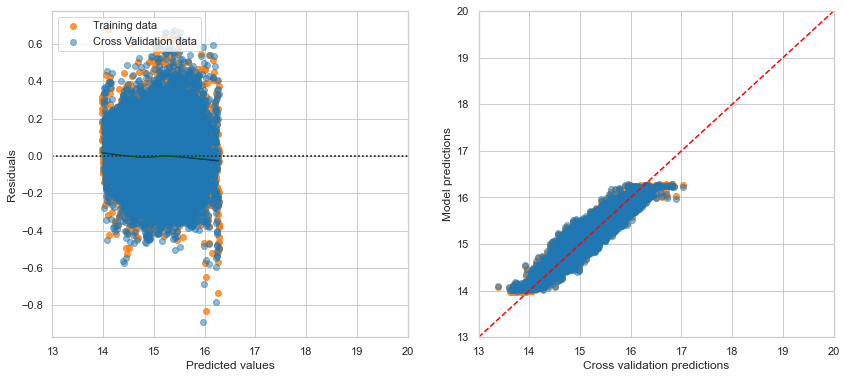

In [517]:
predicted_forest = cross_val_predict(forest_reg, pre_X, pre_y, cv=10, verbose = 50)   

plot_resid(forest_pred_val, predicted_forest, pre_y, "forest_resid_opt1")

## Neural Network

In [32]:
#X_train, X_valid, y_train, y_valid = train_test_split(pre_X, pre_y)


In [552]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=pre_X.shape[1], 
                Optimizer = keras.optimizers.SGD, epochs=400, batch_size=64): 
    model = keras.models.Sequential() 
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = Optimizer(learning_rate = learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model



In [612]:
def cross_validate_NN(X, y, K = 5, 
                      n_hidden = 4,  
                      n_neurons = 40,
                      learning_rate=3e-3,
                      epochs=400,
                      batch_size=64,
                      **kwargs):
    scores = []
    histories = []
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        
        model = keras.wrappers.scikit_learn.KerasRegressor(build_model,
                                                           n_hidden = n_hidden, 
                                                           n_neurons = n_neurons, 
                                                           learning_rate = learning_rate,
                                                           epochs = epochs)  # compile model
        
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]), # feed in the test data for plotting
                                   callbacks=[keras.callbacks.EarlyStopping(patience=25)],
                                   **kwargs).history)
        
        scores.append(model.score(X[test], y[test], verbose = 0)) # evaluate the test dataset
    #print("average test loss: ", np.asarray(scores).mean())
    return np.asarray(scores)#scores, histories

In [626]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 1, 
                                                       n_neurons = 40, 
                                                       learning_rate = 0.0008,
                                                       epochs = 400) 

NN_model = keras_reg.fit(pre_X, pre_y,
              validation_split=0.2,
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])

opt_epoch = np.argmin(NN_model.history["val_loss"])


NN_pred_val = keras_reg.predict(pre_X)
NN_exp_pred = np.exp(NN_pred_val)

NN_mse = mean_squared_error(pre_y, NN_pred_val)
NN_rmse = np.sqrt(NN_mse)
print("NN rmse:", NN_rmse)

print("Predictions:",forest_exp_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), NN_exp_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), NN_exp_pred))


/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/1511477639.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 1,


Epoch 1/400
641/641 [==============================] - 4s 3ms/step - loss: 4.1566 - val_loss: 1.3967
Epoch 2/400
641/641 [==============================] - 1s 2ms/step - loss: 1.0158 - val_loss: 0.8895
Epoch 3/400
641/641 [==============================] - 2s 3ms/step - loss: 0.7928 - val_loss: 0.7643
Epoch 4/400
641/641 [==============================] - 1s 2ms/step - loss: 0.6778 - val_loss: 0.6725
Epoch 5/400
641/641 [==============================] - 1s 2ms/step - loss: 0.6021 - val_loss: 0.6084
Epoch 6/400
641/641 [==============================] - 1s 2ms/step - loss: 0.5468 - val_loss: 0.5136
Epoch 7/400
335/641 [==============>...............] - ETA: 0s - loss: 0.5293

KeyboardInterrupt: 

In [590]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 1, 
                                                       n_neurons = 40, 
                                                       learning_rate = 3e-3,
                                                       epochs = 400) 

NN_model = keras_reg.fit(pre_X, pre_y,
              validation_split=0.2,
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

opt_epoch = np.argmin(NN_model.history["val_loss"])


NN_pred_val = keras_reg.predict(pre_X)
NN_exp_pred = np.exp(NN_pred_val)

NN_mse = mean_squared_error(pre_y, NN_pred_val)
NN_rmse = np.sqrt(NN_mse)
print("NN rmse:", NN_rmse)

print("Predictions:",forest_exp_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), NN_exp_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), NN_exp_pred))


#val_loss = NN_model.history["val_loss"].argmin()
#NN_val_rmse = sqrt(val_loss)

NN_CV_scores = cross_validate_NN(X = pre_X, y = pre_y, K=10, 
                                               n_hidden = 1, 
                                               n_neurons = 40, 
                                               learning_rate = 3e-3, 
                                               epochs = opt_epoch)

NN_CV_scores = np.sqrt(-NN_CV_scores)

display_scores(NN_CV_scores)

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3468724223.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 1,


Epoch 1/400
321/321 [==============================] - 2s 5ms/step - loss: 19.4291 - val_loss: 4.4168
Epoch 2/400
321/321 [==============================] - 1s 3ms/step - loss: 4.7441 - val_loss: 1.0899
Epoch 3/400
321/321 [==============================] - 1s 2ms/step - loss: 1.2440 - val_loss: 0.5009
Epoch 4/400
321/321 [==============================] - 1s 3ms/step - loss: 1.3364 - val_loss: 0.5144
Epoch 5/400
321/321 [==============================] - 1s 2ms/step - loss: 0.7703 - val_loss: 1.8774
Epoch 6/400
321/321 [==============================] - 1s 3ms/step - loss: 0.5702 - val_loss: 0.8318
Epoch 7/400
321/321 [==============================] - 1s 3ms/step - loss: 0.7999 - val_loss: 0.3695
Epoch 8/400
321/321 [==============================] - 2s 6ms/step - loss: 0.4462 - val_loss: 0.3286
Epoch 9/400
321/321 [==============================] - 1s 2ms/step - loss: 0.5024 - val_loss: 0.3119
Epoch 10/400
321/321 [==============================] - 1s 2ms/step - loss: 0.4594 - val_l

321/321 [==============================] - 1s 2ms/step - loss: 0.0968 - val_loss: 0.0851
Epoch 82/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0852 - val_loss: 0.1001
Epoch 83/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0985 - val_loss: 0.1832
Epoch 84/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0884 - val_loss: 0.0781
Epoch 85/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0909 - val_loss: 0.1658
Epoch 86/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0992 - val_loss: 0.0745
Epoch 87/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0849 - val_loss: 0.1012
Epoch 88/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0832 - val_loss: 0.1114
Epoch 89/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0927 - val_loss: 0.0977
Epoch 90/400
321/321 [==============================] - 1s 2ms/step - loss: 0.0883 - val_loss: 

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/2554304432.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_model,


721/721 [==============================] - 2s 2ms/step - loss: 9.7412 - val_loss: 0.9338
Epoch 2/103
721/721 [==============================] - 2s 2ms/step - loss: 1.5689 - val_loss: 0.5286
Epoch 3/103
721/721 [==============================] - 2s 2ms/step - loss: 0.6646 - val_loss: 0.3489
Epoch 4/103
721/721 [==============================] - 2s 2ms/step - loss: 0.5490 - val_loss: 0.3497
Epoch 5/103
721/721 [==============================] - 2s 2ms/step - loss: 0.4631 - val_loss: 0.8733
Epoch 6/103
721/721 [==============================] - 1s 2ms/step - loss: 0.4488 - val_loss: 0.3710
Epoch 7/103
721/721 [==============================] - 1s 2ms/step - loss: 0.3280 - val_loss: 0.3169
Epoch 8/103
721/721 [==============================] - 1s 1ms/step - loss: 0.3399 - val_loss: 0.2325
Epoch 9/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2899 - val_loss: 0.2684
Epoch 10/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2897 - val_loss: 0.2347
E

721/721 [==============================] - 2s 3ms/step - loss: 0.0423 - val_loss: 0.0414
Epoch 82/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0424 - val_loss: 0.0342
Epoch 83/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0440 - val_loss: 0.0411
Epoch 84/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0391 - val_loss: 0.0346
Epoch 85/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0425 - val_loss: 0.0429
Epoch 86/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0421 - val_loss: 0.0554
Epoch 87/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0381 - val_loss: 0.0397
Epoch 88/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0371 - val_loss: 0.0297
Epoch 89/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0399 - val_loss: 0.0308
Epoch 90/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0390 - val_loss: 

721/721 [==============================] - 1s 2ms/step - loss: 0.0638 - val_loss: 0.1083
Epoch 59/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0565 - val_loss: 0.0496
Epoch 60/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0562 - val_loss: 0.1140
Epoch 61/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0590 - val_loss: 0.0440
Epoch 62/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0521 - val_loss: 0.0436
Epoch 63/103
721/721 [==============================] - 3s 4ms/step - loss: 0.0519 - val_loss: 0.0737
Epoch 64/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0561 - val_loss: 0.0615
Epoch 65/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0526 - val_loss: 0.0474
Epoch 66/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0505 - val_loss: 0.1420
Epoch 67/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0513 - val_loss: 

721/721 [==============================] - 2s 3ms/step - loss: 0.1046 - val_loss: 0.1041
Epoch 36/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0937 - val_loss: 0.0975
Epoch 37/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0950 - val_loss: 0.0801
Epoch 38/103
721/721 [==============================] - 3s 4ms/step - loss: 0.0947 - val_loss: 0.0793
Epoch 39/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0916 - val_loss: 0.1036
Epoch 40/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0907 - val_loss: 0.0696
Epoch 41/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0876 - val_loss: 0.1265
Epoch 42/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0902 - val_loss: 0.0787
Epoch 43/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0827 - val_loss: 0.2312
Epoch 44/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0877 - val_loss: 

721/721 [==============================] - 1s 1ms/step - loss: 0.2559 - val_loss: 0.2043
Epoch 13/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2273 - val_loss: 0.1775
Epoch 14/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2172 - val_loss: 0.1704
Epoch 15/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2114 - val_loss: 0.1704
Epoch 16/103
721/721 [==============================] - 1s 1ms/step - loss: 0.2049 - val_loss: 0.1892
Epoch 17/103
721/721 [==============================] - 1s 1ms/step - loss: 0.1877 - val_loss: 0.1713
Epoch 18/103
721/721 [==============================] - 1s 1ms/step - loss: 0.1957 - val_loss: 0.3234
Epoch 19/103
721/721 [==============================] - 1s 1ms/step - loss: 0.1697 - val_loss: 0.1418
Epoch 20/103
721/721 [==============================] - 1s 1ms/step - loss: 0.1712 - val_loss: 0.1615
Epoch 21/103
721/721 [==============================] - 1s 1ms/step - loss: 0.1679 - val_loss: 

721/721 [==============================] - 1s 1ms/step - loss: 0.0402 - val_loss: 0.0628
Epoch 93/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0375 - val_loss: 0.0354
Epoch 94/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0382 - val_loss: 0.0308
Epoch 95/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0409 - val_loss: 0.0403
Epoch 96/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0373 - val_loss: 0.0318
Epoch 97/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0354 - val_loss: 0.0379
Epoch 98/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0365 - val_loss: 0.0345
Epoch 99/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0391 - val_loss: 0.0303
Epoch 100/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0374 - val_loss: 0.0479
Epoch 101/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss

721/721 [==============================] - 3s 5ms/step - loss: 0.0480 - val_loss: 0.0666
Epoch 70/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0502 - val_loss: 0.0409
Epoch 71/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0479 - val_loss: 0.1178
Epoch 72/103
721/721 [==============================] - 3s 4ms/step - loss: 0.0512 - val_loss: 0.0676
Epoch 73/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0477 - val_loss: 0.0597
Epoch 74/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0473 - val_loss: 0.1978
Epoch 75/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0430 - val_loss: 0.0746
Epoch 76/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0468 - val_loss: 0.0624
Epoch 77/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0450 - val_loss: 0.0404
Epoch 78/103
721/721 [==============================] - 4s 5ms/step - loss: 0.0450 - val_loss: 

721/721 [==============================] - 2s 2ms/step - loss: 0.0883 - val_loss: 0.1063
Epoch 47/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0760 - val_loss: 0.0700
Epoch 48/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0828 - val_loss: 0.0859
Epoch 49/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0814 - val_loss: 0.1037
Epoch 50/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0767 - val_loss: 0.1033
Epoch 51/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0772 - val_loss: 0.1079
Epoch 52/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0728 - val_loss: 0.0618
Epoch 53/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0677 - val_loss: 0.1096
Epoch 54/103
721/721 [==============================] - 3s 4ms/step - loss: 0.0733 - val_loss: 0.0763
Epoch 55/103
721/721 [==============================] - 3s 4ms/step - loss: 0.0655 - val_loss: 

721/721 [==============================] - 2s 3ms/step - loss: 0.1372 - val_loss: 0.1302
Epoch 24/103
721/721 [==============================] - 2s 3ms/step - loss: 0.1268 - val_loss: 0.1461
Epoch 25/103
721/721 [==============================] - 2s 3ms/step - loss: 0.1340 - val_loss: 0.1161
Epoch 26/103
721/721 [==============================] - 2s 3ms/step - loss: 0.1217 - val_loss: 0.1081
Epoch 27/103
721/721 [==============================] - 2s 3ms/step - loss: 0.1159 - val_loss: 0.1412
Epoch 28/103
721/721 [==============================] - 2s 2ms/step - loss: 0.1197 - val_loss: 0.3835
Epoch 29/103
721/721 [==============================] - 2s 2ms/step - loss: 0.1174 - val_loss: 0.1049
Epoch 30/103
721/721 [==============================] - 1s 2ms/step - loss: 0.1174 - val_loss: 0.1898
Epoch 31/103
721/721 [==============================] - 1s 2ms/step - loss: 0.1113 - val_loss: 0.0905
Epoch 32/103
721/721 [==============================] - 1s 2ms/step - loss: 0.1016 - val_loss: 

721/721 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0270
Epoch 1/103
721/721 [==============================] - 3s 3ms/step - loss: 10.8467 - val_loss: 15.4935
Epoch 2/103
721/721 [==============================] - 1s 2ms/step - loss: 1.6420 - val_loss: 2.2269
Epoch 3/103
721/721 [==============================] - 1s 1ms/step - loss: 0.8557 - val_loss: 1.3489
Epoch 4/103
721/721 [==============================] - 1s 1ms/step - loss: 0.6155 - val_loss: 0.3992
Epoch 5/103
721/721 [==============================] - 1s 2ms/step - loss: 0.4768 - val_loss: 1.1049
Epoch 6/103
721/721 [==============================] - 2s 2ms/step - loss: 0.4701 - val_loss: 0.3187
Epoch 7/103
721/721 [==============================] - 2s 3ms/step - loss: 0.3628 - val_loss: 0.2810
Epoch 8/103
721/721 [==============================] - 2s 2ms/step - loss: 0.3023 - val_loss: 0.2171
Epoch 9/103
721/721 [==============================] - 2s 2ms/step - loss: 0.2793 - val_loss: 0.2612


721/721 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0628
Epoch 81/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0475 - val_loss: 0.0854
Epoch 82/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0464 - val_loss: 0.0600
Epoch 83/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0428 - val_loss: 0.0498
Epoch 84/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0413 - val_loss: 0.0365
Epoch 85/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0451 - val_loss: 0.0438
Epoch 86/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0456 - val_loss: 0.0362
Epoch 87/103
721/721 [==============================] - 2s 3ms/step - loss: 0.0415 - val_loss: 0.0586
Epoch 88/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0408 - val_loss: 0.0292
Epoch 89/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0416 - val_loss: 

721/721 [==============================] - 1s 2ms/step - loss: 0.0750 - val_loss: 0.1494
Epoch 58/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0704 - val_loss: 0.0780
Epoch 59/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.1418
Epoch 60/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0630
Epoch 61/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0622 - val_loss: 0.0477
Epoch 62/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0632 - val_loss: 0.1981
Epoch 63/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0638 - val_loss: 0.0660
Epoch 64/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0545 - val_loss: 0.0464
Epoch 65/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0592 - val_loss: 0.0520
Epoch 66/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0567 - val_loss: 

721/721 [==============================] - 1s 2ms/step - loss: 0.0965 - val_loss: 0.0843
Epoch 35/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0910 - val_loss: 0.0795
Epoch 36/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0980 - val_loss: 0.0883
Epoch 37/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0872 - val_loss: 0.0807
Epoch 38/103
721/721 [==============================] - 1s 1ms/step - loss: 0.0884 - val_loss: 0.1496
Epoch 39/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0831 - val_loss: 0.0730
Epoch 40/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0869 - val_loss: 0.0705
Epoch 41/103
721/721 [==============================] - 2s 2ms/step - loss: 0.0818 - val_loss: 0.0665
Epoch 42/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0807 - val_loss: 0.1840
Epoch 43/103
721/721 [==============================] - 1s 2ms/step - loss: 0.0763 - val_loss: 

In [627]:

hiddenLayers = [1, 2, 3, 4, 5, 6]
neurons = [20, 30, 40, 50, 60]
learningrate = [0.0003, 0.0008, 0.003]

grid = {'hidden': hiddenLayers,
        'neurons': neurons,
        'learningrate': learningrate}
print(grid)

{'hidden': [1, 2, 3, 4, 5, 6], 'neurons': [20, 30, 40, 50, 60], 'learningrate': [0.0003, 0.0008, 0.003]}


In [628]:
def searchCV(X, y):
    val_scores = []
    p = 0
    param = []
    for h in hiddenLayers:
        for n in neurons:
            for l in learningrate:
                cross = cross_validate_NN(X, y, K = 5,
                                          n_hidden = h,  
                                          n_neurons = n,
                                          learning_rate = l,#,
                                          epochs = 500)#opt_epoch_CV)
                

                print("NN rmse:", NN_rmse)

                print("validation loss: ", cross)
                print("rmse: ", np.sqrt(- cross.mean()))
                print("Number of hidden layers: ", h)
                print("Number of neurons: ", n)
                print("Learning Rate: ", l)

                val_scores.append(cross.mean())
                param.append("hidden layer: " + str(h)+ ", learning rate: " + str(l)\
                              + ", neurons: " + str(n))
                
                
                ## Need to save hyper parameters for best model #####################
    return val_scores, param
    #print("average test loss: ", np.asarray(scores).mean())
    #print("Best model: ", np.argmin(val_scores, x))           

NN rmse: 0.1142757624228128
Number of hidden layers:  2
Number of neurons:  50
Learning Rate:  0.003    se = searchCV(pre_X, pre_y)  

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 5s 4ms/step - loss: 11.2611 - val_loss: 3.0550
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 2.2656 - val_loss: 1.9205
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 1.5353 - val_loss: 1.5286
Epoch 4/500
641/641 [==============================] - 4s 6ms/step - loss: 1.1612 - val_loss: 1.0491
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.9249 - val_loss: 0.8865
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8031 - val_loss: 0.7932
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7185 - val_loss: 0.6753
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6560 - val_loss: 0.6156
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6096 - val_loss: 0.5767
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5744 - val_l

641/641 [==============================] - 1s 1ms/step - loss: 0.2049 - val_loss: 0.2173
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2031 - val_loss: 0.2079
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2009 - val_loss: 0.2061
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1991 - val_loss: 0.1989
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1968 - val_loss: 0.1991
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1948 - val_loss: 0.1956
Epoch 87/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1934 - val_loss: 0.1923
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1913 - val_loss: 0.1911
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1892 - val_loss: 0.1967
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1874 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0927 - val_loss: 0.0950
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0922 - val_loss: 0.0942
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0913 - val_loss: 0.0923
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0906 - val_loss: 0.0921
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0897 - val_loss: 0.0905
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0888 - val_loss: 0.0974
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0884 - val_loss: 0.0889
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0873 - val_loss: 0.0917
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0866 - val_loss: 0.0875
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0496 - val_loss: 0.0511
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0492 - val_loss: 0.0504
Epoch 242/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0489 - val_loss: 0.0498
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0488 - val_loss: 0.0503
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0485 - val_loss: 0.0531
Epoch 245/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0479 - val_loss: 0.0492
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0493
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0474 - val_loss: 0.0656
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0473 - val_loss: 0.0486
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0467 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0325 - val_loss: 0.0333
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0323 - val_loss: 0.0374
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0348
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0320 - val_loss: 0.0350
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0317 - val_loss: 0.0327
Epoch 324/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0317 - val_loss: 0.0322
Epoch 325/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.0336
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0315 - val_loss: 0.0321
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0313 - val_loss: 0.0348
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0299
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0374
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0272
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0270
Epoch 402/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0247 - val_loss: 0.0269
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0444
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0298
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0255
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0372
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0264
Epoch 478/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0227
Epoch 479/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 480/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0228
Epoch 481/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0240
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0240
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0232
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0317
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0242
Epoch 486/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0219 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 4.5348 - val_loss: 1.1568
Epoch 2/500
641/641 [==============================] - 1s 1ms/step - loss: 0.9579 - val_loss: 0.8934
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 0.7533 - val_loss: 0.6924
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6649 - val_loss: 0.6177
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6047 - val_loss: 0.5598
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5604 - val_loss: 0.5207
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5192 - val_loss: 0.4890
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4913 - val_loss: 0.5544
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4617 - val_loss: 0.4316
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4375 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1144 - val_loss: 0.0805
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1147 - val_loss: 0.1139
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1140 - val_loss: 0.0770
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1134 - val_loss: 0.1645
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1104 - val_loss: 0.0729
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1355 - val_loss: 0.0720
Epoch 87/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1051 - val_loss: 0.0849
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1114 - val_loss: 0.0827
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0963 - val_loss: 0.0772
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0944 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0589 - val_loss: 0.0497
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0710
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0631 - val_loss: 0.0435
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0548 - val_loss: 0.0393
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0533 - val_loss: 0.0708
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0558 - val_loss: 0.0437
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0611 - val_loss: 0.1927
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0629 - val_loss: 0.0554
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0500 - val_loss: 0.1933
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0419 - val_loss: 0.0341
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0369 - val_loss: 0.0312
Epoch 242/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0419 - val_loss: 0.0300
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0405 - val_loss: 0.0348
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0422 - val_loss: 0.0303
Epoch 245/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0427 - val_loss: 0.0408
Epoch 246/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0435 - val_loss: 0.1188
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0424 - val_loss: 0.0326
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0437 - val_loss: 0.0802
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0427 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0368 - val_loss: 0.0384
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0346 - val_loss: 0.0526
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0527
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0359 - val_loss: 0.0296
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0337 - val_loss: 0.0290
Epoch 324/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0340 - val_loss: 0.0454
Epoch 325/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0373 - val_loss: 0.0336
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0356 - val_loss: 0.0390
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0325 - val_loss: 0.0283
Epoch 328/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0334 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 10.9267 - val_loss: 1.4136
Epoch 2/500
641/641 [==============================] - 1s 1ms/step - loss: 1.8043 - val_loss: 0.8957
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 1.3294 - val_loss: 1.5258
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6931 - val_loss: 0.3673
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5123 - val_loss: 0.3503
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4536 - val_loss: 0.7525
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4647 - val_loss: 0.2725
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3532 - val_loss: 0.4284
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3524 - val_loss: 0.3540
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3030 - val_l

641/641 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 0.0420
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0581 - val_loss: 0.0634
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.0524
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0562 - val_loss: 0.0478
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0567 - val_loss: 0.0468
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0524 - val_loss: 0.0555
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0510 - val_loss: 0.0406
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0530 - val_loss: 0.0460
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0532 - val_loss: 0.0915
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0305 - val_loss: 0.0385
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0283
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0294 - val_loss: 0.0226
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0288 - val_loss: 0.0291
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0279 - val_loss: 0.0770
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0366
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0292 - val_loss: 0.0372
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0238
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0207
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0214 - val_loss: 0.0186
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 242/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0209 - val_loss: 0.0234
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0228 - val_loss: 0.0175
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.0265
Epoch 245/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0174
Epoch 246/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0221 - val_loss: 0.0190
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0217 - val_loss: 0.0299
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0221 - val_loss: 0.0181
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0228 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0210 - val_loss: 0.0168
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0205
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0195 - val_loss: 0.0246
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0197 - val_loss: 0.0159
Epoch 324/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 325/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0197 - val_loss: 0.0197
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0198 - val_loss: 0.0174
Epoch 328/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0200 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 9.4875 - val_loss: 2.2691
Epoch 2/500
641/641 [==============================] - 1s 1ms/step - loss: 1.7109 - val_loss: 1.3999
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 1.1906 - val_loss: 1.0863
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.9792 - val_loss: 0.9181
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.8645 - val_loss: 0.8353
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.7845 - val_loss: 0.7655
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.7286 - val_loss: 0.6913
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6862 - val_loss: 0.6775
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6525 - val_loss: 0.6281
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6228 - val_lo

641/641 [==============================] - 1s 1ms/step - loss: 0.2178 - val_loss: 0.2151
Epoch 82/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2163 - val_loss: 0.2140
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2142 - val_loss: 0.2281
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2123 - val_loss: 0.2132
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2100 - val_loss: 0.2119
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2080 - val_loss: 0.2055
Epoch 87/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2066 - val_loss: 0.2334
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2046 - val_loss: 0.2103
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2025 - val_loss: 0.2003
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.2007 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1075 - val_loss: 0.1087
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1063 - val_loss: 0.1087
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1055 - val_loss: 0.1167
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1044 - val_loss: 0.1110
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1040 - val_loss: 0.1061
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1030 - val_loss: 0.1046
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1021 - val_loss: 0.1039
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1010 - val_loss: 0.1059
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1004 - val_loss: 0.1067
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0597 - val_loss: 0.0672
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0590 - val_loss: 0.0624
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0593 - val_loss: 0.0616
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0609
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0582 - val_loss: 0.0606
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0580 - val_loss: 0.0610
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0576 - val_loss: 0.0603
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0572 - val_loss: 0.0619
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0570 - val_loss: 0.0590
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0568 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0410 - val_loss: 0.0449
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0410 - val_loss: 0.0447
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0411 - val_loss: 0.0469
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0407 - val_loss: 0.0434
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0404 - val_loss: 0.0434
Epoch 324/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0404 - val_loss: 0.0433
Epoch 325/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0403 - val_loss: 0.0596
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0399 - val_loss: 0.0491
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0398 - val_loss: 0.0466
Epoch 328/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0397 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0330 - val_loss: 0.0398
Epoch 399/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0330 - val_loss: 0.0364
Epoch 400/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0327 - val_loss: 0.0387
Epoch 401/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0326 - val_loss: 0.0359
Epoch 402/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0324 - val_loss: 0.0399
Epoch 403/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0326 - val_loss: 0.0359
Epoch 404/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0418
Epoch 405/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0382
Epoch 406/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0321 - val_loss: 0.0361
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0321 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0316
Epoch 478/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0306
Epoch 479/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 480/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0271 - val_loss: 0.0357
Epoch 481/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0270 - val_loss: 0.0323
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0269 - val_loss: 0.0332
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0269 - val_loss: 0.0304
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0393
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0303
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 3.9406 - val_loss: 1.2512
Epoch 2/500
641/641 [==============================] - 1s 1ms/step - loss: 0.9114 - val_loss: 0.8321
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 0.7109 - val_loss: 0.6236
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6099 - val_loss: 0.5693
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5480 - val_loss: 0.5104
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5077 - val_loss: 0.5382
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4740 - val_loss: 0.4859
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4509 - val_loss: 0.4739
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4287 - val_loss: 0.4096
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4093 - val_loss: 0.3820
E

641/641 [==============================] - 1s 2ms/step - loss: 0.1146 - val_loss: 0.0968
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1113 - val_loss: 0.1609
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0992 - val_loss: 0.2234
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0957 - val_loss: 0.1457
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1035 - val_loss: 0.0801
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1013 - val_loss: 0.0759
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1217 - val_loss: 0.0978
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 0.0847
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0891 - val_loss: 0.0986
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0947 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0527 - val_loss: 0.1010
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.0431
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0487 - val_loss: 0.0570
Epoch 164/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0526 - val_loss: 0.0343
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0583 - val_loss: 0.1895
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0550 - val_loss: 0.2354
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0553 - val_loss: 0.0367
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0548 - val_loss: 0.0360
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0517 - val_loss: 0.0365
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.1059
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0595
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0660
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0229
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0377 - val_loss: 0.0228
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0361 - val_loss: 0.0273
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0345 - val_loss: 0.0229
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0348 - val_loss: 0.0224
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0361 - val_loss: 0.0310
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0268 - val_loss: 0.0447
Epoch 320/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0269 - val_loss: 0.0295
Epoch 321/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0285 - val_loss: 0.0474
Epoch 322/500
641/641 [==============================] - 3s 5ms/step - loss: 0.0266 - val_loss: 0.0270
Epoch 323/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0285 - val_loss: 0.0380
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0270 - val_loss: 0.0628
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0313
Epoch 326/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0268 - val_loss: 0.0190
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0281 - val_loss: 0.0694
Epoch 328/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0267 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0229 - val_loss: 0.0179
Epoch 399/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0238 - val_loss: 0.0633
Epoch 400/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0239 - val_loss: 0.0200
Epoch 401/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0222 - val_loss: 0.0221
Epoch 402/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0248 - val_loss: 0.0289
Epoch 403/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0227 - val_loss: 0.0255
Epoch 404/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0249 - val_loss: 0.0174
Epoch 405/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0234 - val_loss: 0.0370
Epoch 406/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0222 - val_loss: 0.0180
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0233 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 20s 2ms/step - loss: 11.6798 - val_loss: 6.3689
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.7324 - val_loss: 0.4543
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6478 - val_loss: 0.6205
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5627 - val_loss: 0.8918
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5223 - val_loss: 0.4328
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3760 - val_loss: 0.2879
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3786 - val_loss: 0.2663
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3423 - val_loss: 0.3240
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3077 - val_loss: 0.2809
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3330 - val_

641/641 [==============================] - 1s 2ms/step - loss: 0.0598 - val_loss: 0.0489
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0558 - val_loss: 0.0500
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0560 - val_loss: 0.0458
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0570 - val_loss: 0.1172
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0557 - val_loss: 0.0458
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0564 - val_loss: 0.0456
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0558 - val_loss: 0.0455
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0502 - val_loss: 0.0437
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0559 - val_loss: 0.0445
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0541 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.0266
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.1030
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0270
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0299
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0274
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0261
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0570
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0341
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0303
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0203
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0381
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0211
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0228
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0261
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0275
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0226
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0216
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0287
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0223 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 7.3962 - val_loss: 2.1991
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.7193 - val_loss: 1.4210
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 1.2426 - val_loss: 1.1754
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0384 - val_loss: 0.9814
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9225 - val_loss: 0.8862
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8430 - val_loss: 0.8174
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7812 - val_loss: 0.7655
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7338 - val_loss: 0.7226
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6928 - val_loss: 0.6997
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6585 - val_loss: 0.6525
E

641/641 [==============================] - 1s 2ms/step - loss: 0.1960 - val_loss: 0.2025
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1936 - val_loss: 0.2005
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1915 - val_loss: 0.2129
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1897 - val_loss: 0.2133
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1877 - val_loss: 0.1960
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1862 - val_loss: 0.1975
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1835 - val_loss: 0.1951
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1817 - val_loss: 0.2002
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1796 - val_loss: 0.1880
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1779 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0933 - val_loss: 0.1149
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0926 - val_loss: 0.1005
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0919 - val_loss: 0.0996
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0913 - val_loss: 0.1012
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0903 - val_loss: 0.1131
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0895 - val_loss: 0.0995
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0893 - val_loss: 0.0991
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0884 - val_loss: 0.0969
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0878 - val_loss: 0.1072
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0567 - val_loss: 0.0640
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.0762
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0559 - val_loss: 0.0636
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0558 - val_loss: 0.0627
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0555 - val_loss: 0.0639
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0551 - val_loss: 0.0619
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0549 - val_loss: 0.0623
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0547 - val_loss: 0.0616
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0545 - val_loss: 0.0696
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0542 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0404 - val_loss: 0.0457
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0550
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0401 - val_loss: 0.0522
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0404 - val_loss: 0.0469
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0401 - val_loss: 0.0554
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0399 - val_loss: 0.0499
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0396 - val_loss: 0.0520
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0455
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0397 - val_loss: 0.0457
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0394 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.0399
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0321 - val_loss: 0.0494
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0401
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0361
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0371
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0495
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0361
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0361
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0362
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0314 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0316
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0376
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0314
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0312
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0308
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0373
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0310
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0324
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0307
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 4.1268 - val_loss: 1.0628
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8305 - val_loss: 0.7029
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6406 - val_loss: 0.6359
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5714 - val_loss: 0.5341
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5239 - val_loss: 0.5314
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4923 - val_loss: 0.4681
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4667 - val_loss: 0.4432
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4455 - val_loss: 0.4473
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4272 - val_loss: 0.4071
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4098 - val_loss: 0.3952
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0910 - val_loss: 0.1309
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0896 - val_loss: 0.0888
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0890 - val_loss: 0.0995
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0870 - val_loss: 0.1027
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0855 - val_loss: 0.0834
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0842 - val_loss: 0.0856
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0834 - val_loss: 0.0795
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0817 - val_loss: 0.0866
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0837 - val_loss: 0.1470
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0812 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0522 - val_loss: 0.0484
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.0337
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0477 - val_loss: 0.0390
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.0349
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0567 - val_loss: 0.0583
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0542 - val_loss: 0.1520
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0454 - val_loss: 0.0336
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0458 - val_loss: 0.0369
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0514 - val_loss: 0.0343
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0375 - val_loss: 0.0325
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0230
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0439
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0359 - val_loss: 0.0228
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0321 - val_loss: 0.0716
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0300
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0236
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0245
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0360 - val_loss: 0.0237
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0353 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0265
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0397
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0217
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0198
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0535
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0193
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0290
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0214
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0191
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - v

641/641 [==============================] - 3s 5ms/step - loss: 0.0253 - val_loss: 0.0276
Epoch 399/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0234 - val_loss: 0.0291
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0294
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0171
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0372
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0175
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0281
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0233
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0245 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0337
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0193
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0164
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0186
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0169
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0168
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0220
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0165
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0223 - val_loss: 0.0333
Epoch 486/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0225 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 11.3434 - val_loss: 1.0447
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 1.5816 - val_loss: 0.4596
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7748 - val_loss: 0.4045
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5585 - val_loss: 0.3399
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5023 - val_loss: 0.3098
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4188 - val_loss: 0.2927
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4281 - val_loss: 0.2865
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3433 - val_loss: 0.2751
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3189 - val_loss: 0.2627
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2922 - val_loss: 0.5054


641/641 [==============================] - 1s 2ms/step - loss: 0.0636 - val_loss: 0.0541
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.0658
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0568 - val_loss: 0.0896
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0570 - val_loss: 0.0575
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0592 - val_loss: 0.1141
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0536 - val_loss: 0.0467
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0536 - val_loss: 0.1586
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0553 - val_loss: 0.0452
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0503 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0253
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0702
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0253
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0420
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0298 - val_loss: 0.0310
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0341
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0362
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0276
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0338
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0194
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0195
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0336
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0242
Epoch 244/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0508
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0230 - val_loss: 0.0319
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0398
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0230
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0210 - val_loss: 0.0260
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0235 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0178
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0177
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0245
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0184
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0352
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0323
Epoch 325/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 326/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0199 - val_loss: 0.0172
Epoch 327/500
641/641 [==============================] - 4s 6ms/step - loss: 0.0178 - val_loss: 0.0268
Epoch 328/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0189 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0163
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0248
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0178
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0357
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0217
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0565
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0163
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 8.8941 - val_loss: 1.8207
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.3922 - val_loss: 1.1569
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0062 - val_loss: 0.9185
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8409 - val_loss: 0.7898
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7429 - val_loss: 0.7323
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6775 - val_loss: 0.6458
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6313 - val_loss: 0.6152
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5946 - val_loss: 0.5740
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5661 - val_loss: 0.5422
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5428 - val_loss: 0.5267
E

641/641 [==============================] - 1s 2ms/step - loss: 0.2167 - val_loss: 0.2191
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2145 - val_loss: 0.2152
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2131 - val_loss: 0.2142
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2106 - val_loss: 0.2112
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2089 - val_loss: 0.2187
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2071 - val_loss: 0.2078
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2053 - val_loss: 0.2076
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2037 - val_loss: 0.2046
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2020 - val_loss: 0.2043
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2004 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1084 - val_loss: 0.1129
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1073 - val_loss: 0.1140
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1068 - val_loss: 0.1113
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1058 - val_loss: 0.1114
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1047 - val_loss: 0.1113
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1040 - val_loss: 0.1145
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1031 - val_loss: 0.1119
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1022 - val_loss: 0.1071
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1014 - val_loss: 0.1068
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0613 - val_loss: 0.0647
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0606 - val_loss: 0.0681
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0603 - val_loss: 0.0642
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.0637
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0595 - val_loss: 0.0643
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0592 - val_loss: 0.0661
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0588 - val_loss: 0.0624
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0584 - val_loss: 0.0626
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0581 - val_loss: 0.0619
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0577 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0475
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0402 - val_loss: 0.0565
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0401 - val_loss: 0.0436
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0400 - val_loss: 0.0453
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0436
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0395 - val_loss: 0.0425
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0396 - val_loss: 0.0433
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0393 - val_loss: 0.0430
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0389 - val_loss: 0.0458
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0389 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0383
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0419
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.0331
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0358
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.0532
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0356
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 406/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0297 - val_loss: 0.0330
Epoch 407/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0297 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0301
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0344
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0291
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0285
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0277
Epoch 482/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0247 - val_loss: 0.0273
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0284
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0285
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0275
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 4.0970 - val_loss: 1.2828
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.9294 - val_loss: 1.1103
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7017 - val_loss: 0.7034
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5916 - val_loss: 0.5500
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5273 - val_loss: 0.5113
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4814 - val_loss: 0.4632
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4513 - val_loss: 0.4985
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4254 - val_loss: 0.4185
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4025 - val_loss: 0.3992
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3850 - val_loss: 0.3835
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0805 - val_loss: 0.0816
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0808 - val_loss: 0.0973
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0791 - val_loss: 0.1976
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0792 - val_loss: 0.1053
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.1210
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0753 - val_loss: 0.0893
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0777 - val_loss: 0.0739
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0740 - val_loss: 0.0889
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0743 - val_loss: 0.1495
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0718 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.0474
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0439 - val_loss: 0.0553
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0365
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0435 - val_loss: 0.0373
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0468 - val_loss: 0.0603
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0458 - val_loss: 0.0356
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.0682
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0579
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0482 - val_loss: 0.0450
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0321 - val_loss: 0.0313
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0272
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0331
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0420
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0441
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0293
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0279
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0263
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0304
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0378 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0238
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0219
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0508
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0311
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0213
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0244
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0276
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0214
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0263 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0195
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0209
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0245
Epoch 401/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0228 - val_loss: 0.0481
Epoch 402/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0231 - val_loss: 0.0203
Epoch 403/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0228 - val_loss: 0.0193
Epoch 404/500
641/641 [==============================] - 5s 7ms/step - loss: 0.0231 - val_loss: 0.0201
Epoch 405/500
641/641 [==============================] - 3s 5ms/step - loss: 0.0229 - val_loss: 0.0205
Epoch 406/500
641/641 [==============================] - 4s 6ms/step - loss: 0.0232 - val_loss: 0.0245
Epoch 407/500
641/641 [==============================] - 4s 6ms/step - loss: 0.0242 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0193
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0206 - val_loss: 0.0186
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0346
Epoch 481/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0223 - val_loss: 0.0309
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0289
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0356
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0242
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0385
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 10.9942 - val_loss: 11.1908
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.6161 - val_loss: 0.7520
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8716 - val_loss: 1.0967
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.6480 - val_loss: 1.4517
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5304 - val_loss: 0.4992
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4573 - val_loss: 0.3409
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3966 - val_loss: 0.2551
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3720 - val_loss: 0.4268
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3174 - val_loss: 0.2937
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3190 - val_

641/641 [==============================] - 1s 1ms/step - loss: 0.0488 - val_loss: 0.0866
Epoch 82/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0503 - val_loss: 0.0387
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0487 - val_loss: 0.0387
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0528 - val_loss: 0.0962
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0488 - val_loss: 0.0391
Epoch 87/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0519 - val_loss: 0.0374
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0498 - val_loss: 0.0883
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0421 - val_loss: 0.1084
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0466 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0287 - val_loss: 0.0331
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0278 - val_loss: 0.0996
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0271 - val_loss: 0.0237
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0357
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0212
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0272 - val_loss: 0.0306
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0266 - val_loss: 0.0540
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0230
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0240
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 2ms/step - loss: 9.2514 - val_loss: 2.3803
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.7449 - val_loss: 1.4610
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 1.1840 - val_loss: 1.0910
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.9383 - val_loss: 0.9028
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8053 - val_loss: 0.8001
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7235 - val_loss: 0.7097
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6677 - val_loss: 0.6755
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6255 - val_loss: 0.6174
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5896 - val_loss: 0.5902
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5600 - val_lo

641/641 [==============================] - 1s 1ms/step - loss: 0.1865 - val_loss: 0.2063
Epoch 82/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1850 - val_loss: 0.1921
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1829 - val_loss: 0.1908
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1813 - val_loss: 0.1912
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1798 - val_loss: 0.1899
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1782 - val_loss: 0.1885
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1765 - val_loss: 0.1842
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1752 - val_loss: 0.1846
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1734 - val_loss: 0.1881
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1719 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0963 - val_loss: 0.1095
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0957 - val_loss: 0.1127
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0946 - val_loss: 0.1059
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0942 - val_loss: 0.1051
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0937 - val_loss: 0.1035
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0930 - val_loss: 0.1032
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0927 - val_loss: 0.1105
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0917 - val_loss: 0.1059
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0910 - val_loss: 0.1097
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0579 - val_loss: 0.0718
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0576 - val_loss: 0.0698
Epoch 242/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0572 - val_loss: 0.0701
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0567 - val_loss: 0.0651
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0566 - val_loss: 0.0670
Epoch 245/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0563 - val_loss: 0.0688
Epoch 246/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0563 - val_loss: 0.0670
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0559 - val_loss: 0.0638
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0554 - val_loss: 0.0668
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0554 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0475
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0408 - val_loss: 0.0481
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0493
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0472
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0519
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0399 - val_loss: 0.0541
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0399 - val_loss: 0.0467
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0398 - val_loss: 0.0491
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0395 - val_loss: 0.0468
Epoch 328/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0394 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0319 - val_loss: 0.0430
Epoch 399/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0319 - val_loss: 0.0371
Epoch 400/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0318 - val_loss: 0.0434
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0444
Epoch 402/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0317 - val_loss: 0.0419
Epoch 403/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.0365
Epoch 404/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.0365
Epoch 405/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0314 - val_loss: 0.0475
Epoch 406/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0315 - val_loss: 0.0360
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0313 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0270 - val_loss: 0.0309
Epoch 478/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0310
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0367
Epoch 480/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0270 - val_loss: 0.0324
Epoch 481/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0313
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0371
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0324
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0265 - val_loss: 0.0312
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0820
Epoch 486/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0268 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 3.9603 - val_loss: 1.5506
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8238 - val_loss: 0.7125
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6543 - val_loss: 0.6645
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5761 - val_loss: 0.5502
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5257 - val_loss: 0.5045
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4805 - val_loss: 0.4823
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4541 - val_loss: 0.4947
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4293 - val_loss: 0.4121
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4086 - val_loss: 0.3927
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3851 - val_lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0926 - val_loss: 0.0997
Epoch 82/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0939 - val_loss: 0.1132
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0923 - val_loss: 0.1554
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0910 - val_loss: 0.1569
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0938 - val_loss: 0.1347
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0888 - val_loss: 0.0898
Epoch 87/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0882 - val_loss: 0.1289
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0884 - val_loss: 0.0830
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0922 - val_loss: 0.0890
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0872 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0564 - val_loss: 0.0507
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0603 - val_loss: 0.0999
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0540 - val_loss: 0.0838
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0555 - val_loss: 0.0449
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0490 - val_loss: 0.0555
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0544 - val_loss: 0.0562
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0922
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0598 - val_loss: 0.0444
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0581 - val_loss: 0.1119
Epoch 170/500
641/641 [==============================] - 1s 1ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0393 - val_loss: 0.0423
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0365 - val_loss: 0.0320
Epoch 242/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0364 - val_loss: 0.0528
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0423 - val_loss: 0.0541
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0381 - val_loss: 0.0311
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.1684
Epoch 246/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0387 - val_loss: 0.1113
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0413 - val_loss: 0.0483
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0344 - val_loss: 0.0425
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0376 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0360
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0307 - val_loss: 0.0303
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0286 - val_loss: 0.0401
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0303 - val_loss: 0.0473
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0303 - val_loss: 0.0255
Epoch 324/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0240
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0247
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0235
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0275
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0277 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0259 - val_loss: 0.0506
Epoch 399/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0274 - val_loss: 0.0208
Epoch 400/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0271 - val_loss: 0.0306
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 402/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0214
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0364
Epoch 404/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0245 - val_loss: 0.0262
Epoch 405/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0282 - val_loss: 0.0301
Epoch 406/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0244 - val_loss: 0.0201
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0238 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0251 - val_loss: 0.0203
Epoch 478/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0224 - val_loss: 0.0403
Epoch 479/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0224 - val_loss: 0.0198
Epoch 480/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0214 - val_loss: 0.0337
Epoch 481/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0289
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0219 - val_loss: 0.0197
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0217 - val_loss: 0.0237
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0221 - val_loss: 0.0369
Epoch 486/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0222 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 10.4682 - val_loss: 4.0735
Epoch 2/500
641/641 [==============================] - 3s 4ms/step - loss: 1.6988 - val_loss: 0.5127
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7652 - val_loss: 1.2945
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7253 - val_loss: 0.6549
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5222 - val_loss: 0.3468
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4116 - val_loss: 0.7531
Epoch 7/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3552 - val_loss: 0.2886
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3498 - val_loss: 0.2494
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3157 - val_loss: 0.3625
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2899 - val_l

641/641 [==============================] - 1s 1ms/step - loss: 0.0495 - val_loss: 0.0432
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0518 - val_loss: 0.0474
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0508 - val_loss: 0.0605
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0447 - val_loss: 0.0449
Epoch 85/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0496 - val_loss: 0.0407
Epoch 86/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0490 - val_loss: 0.1592
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0494
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0526 - val_loss: 0.0429
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0486 - val_loss: 0.0436
Epoch 90/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0448 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0287 - val_loss: 0.0363
Epoch 162/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0290 - val_loss: 0.0533
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0293 - val_loss: 0.0298
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0420
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0278 - val_loss: 0.0257
Epoch 166/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0282 - val_loss: 0.0451
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0261
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0302 - val_loss: 0.0244
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0245
Epoch 170/500
641/641 [==============================] - 2s 2ms/step - lo

641/641 [==============================] - 1s 1ms/step - loss: 0.0206 - val_loss: 0.0233
Epoch 241/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0234 - val_loss: 0.0191
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0321
Epoch 243/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0222 - val_loss: 0.0264
Epoch 244/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0223 - val_loss: 0.0210
Epoch 245/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0239 - val_loss: 0.0395
Epoch 246/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0234 - val_loss: 0.0263
Epoch 247/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0226 - val_loss: 0.0202
Epoch 248/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 249/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0207 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0214 - val_loss: 0.0217
Epoch 320/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0199 - val_loss: 0.0229
Epoch 321/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0190 - val_loss: 0.0217
Epoch 322/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0194 - val_loss: 0.0281
Epoch 323/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0170
Epoch 325/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0194 - val_loss: 0.0227
Epoch 326/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0195 - val_loss: 0.0559
Epoch 327/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0187 - val_loss: 0.0169
Epoch 328/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0190 - v

641/641 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0222
Epoch 399/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0173 - val_loss: 0.0191
Epoch 400/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0181 - val_loss: 0.0193
Epoch 401/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0175 - val_loss: 0.0219
Epoch 402/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0175 - val_loss: 0.0201
Epoch 403/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 404/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0701
Epoch 405/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.0165
Epoch 406/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0173 - val_loss: 0.0160
Epoch 407/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0171 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 2ms/step - loss: 9.6333 - val_loss: 1.3704
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.1083 - val_loss: 0.9803
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 0.8205 - val_loss: 0.8118
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.6989 - val_loss: 0.6552
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6274 - val_loss: 0.6100
Epoch 6/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5793 - val_loss: 0.5595
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5411 - val_loss: 0.5211
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5118 - val_loss: 0.4988
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4887 - val_loss: 0.4822
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.4687 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1225 - val_loss: 0.1483
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1211 - val_loss: 0.1389
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1191 - val_loss: 0.1311
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1172 - val_loss: 0.1289
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1158 - val_loss: 0.1295
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1134 - val_loss: 0.1286
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1117 - val_loss: 0.1256
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1104 - val_loss: 0.1519
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1087 - val_loss: 0.1222
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1073 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0500 - val_loss: 0.0869
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0532 - val_loss: 0.0701
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0496 - val_loss: 0.0632
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0503 - val_loss: 0.0679
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0482 - val_loss: 0.0791
Epoch 166/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0480 - val_loss: 0.0982
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0499 - val_loss: 0.1055
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.0657
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0519 - val_loss: 0.0774
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.0471
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0423 - val_loss: 0.0489
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0468 - val_loss: 0.0551
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0431 - val_loss: 0.0470
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0579
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0447 - val_loss: 0.0702
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0419 - val_loss: 0.0796
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0429 - val_loss: 0.0467
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0628
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0450 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0345 - val_loss: 0.0596
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0384 - val_loss: 0.0455
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0365 - val_loss: 0.0479
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0419
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0342 - val_loss: 0.0456
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0484
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0439
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0674
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0351 - val_loss: 0.0571
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0361 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0388
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0416
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0397
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0391
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0404
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0463
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0392
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 0.0596
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.0805
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0295 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0398
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0393
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0261 - val_loss: 0.0445
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0428
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0398
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0368
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0762
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0466
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0405
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 3.9020 - val_loss: 1.1663
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7792 - val_loss: 0.7258
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5992 - val_loss: 0.5239
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5191 - val_loss: 0.4659
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4650 - val_loss: 0.4515
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4280 - val_loss: 0.4347
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4000 - val_loss: 0.4399
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3723 - val_loss: 0.3495
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3558 - val_loss: 0.3536
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3352 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0642 - val_loss: 0.0592
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0604 - val_loss: 0.0520
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0777
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0576 - val_loss: 0.1038
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0610 - val_loss: 0.0747
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0655 - val_loss: 0.0598
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0648 - val_loss: 0.2574
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0567 - val_loss: 0.0483
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0565 - val_loss: 0.0491
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0552 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0373 - val_loss: 0.0344
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0371 - val_loss: 0.0511
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0317
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0362 - val_loss: 0.1421
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0300
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0362 - val_loss: 0.0410
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0387
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0302
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0324
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0368
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0268
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0288 - val_loss: 0.0519
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0377
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0324
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0279
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0296
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0265
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0380
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0280 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 15.4143 - val_loss: 2.3535
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.2405
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3757 - val_loss: 0.2828
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2137 - val_loss: 0.2011
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1898 - val_loss: 0.1448
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1460 - val_loss: 0.1058
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1178 - val_loss: 0.0948
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1013 - val_loss: 0.3158
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0885 - val_loss: 0.1206
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0750 - val_loss: 0.0676


641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0203
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0193
Epoch 83/500
641/641 [==============================] - 5s 7ms/step - loss: 0.0190 - val_loss: 0.0202
Epoch 84/500
641/641 [==============================] - 4s 6ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0197
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0202
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0212
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0208
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0187 - val_loss: 0.0281
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0163 - val_loss: 0.0206
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 163/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 164/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0165 - val_loss: 0.0179
Epoch 165/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 168/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0166
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0175
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0249
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0188
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0205
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 7.5209 - val_loss: 1.6105
Epoch 2/500
641/641 [==============================] - 3s 4ms/step - loss: 1.2179 - val_loss: 1.0652
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9102 - val_loss: 0.8473
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7816 - val_loss: 0.7741
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.6962 - val_loss: 0.8419
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.6335 - val_loss: 0.6142
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5826 - val_loss: 0.5965
Epoch 8/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5445 - val_loss: 0.5330
Epoch 9/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5105 - val_loss: 0.5050
Epoch 10/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4829 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1312 - val_loss: 0.1465
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1295 - val_loss: 0.1627
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1289 - val_loss: 0.1474
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1267 - val_loss: 0.1457
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1253 - val_loss: 0.1469
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1235 - val_loss: 0.1397
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1222 - val_loss: 0.1385
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1205 - val_loss: 0.1480
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1186 - val_loss: 0.1430
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1174 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0553 - val_loss: 0.0664
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0549 - val_loss: 0.0663
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0550 - val_loss: 0.0675
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0546 - val_loss: 0.0649
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0544 - val_loss: 0.0698
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0539 - val_loss: 0.0688
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0532 - val_loss: 0.0636
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0533 - val_loss: 0.0650
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0525 - val_loss: 0.0623
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0396 - val_loss: 0.0425
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0390 - val_loss: 0.0414
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0689
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0395 - val_loss: 0.0510
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0492
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0416
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0392 - val_loss: 0.2287
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0416 - val_loss: 0.0485
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.1645
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0393 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0332
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0524
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0344
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0465
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0416
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0524
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0340
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0383
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0326
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0279
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0461
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0288
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0301
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0598
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0276
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0404
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0461
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0308 - val_loss: 0.0299
Epoch 407/500
641/641 [==============================] - 3s 5ms/step - loss: 0.0283 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 4.7577 - val_loss: 0.9174
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7764 - val_loss: 0.6169
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5930 - val_loss: 0.5232
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5113 - val_loss: 0.4785
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4601 - val_loss: 0.4803
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4243 - val_loss: 0.4736
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3924 - val_loss: 0.3797
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3698 - val_loss: 0.4055
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3452 - val_loss: 0.4799
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3262 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0732 - val_loss: 0.1150
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0685 - val_loss: 0.0595
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0658 - val_loss: 0.2823
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0683 - val_loss: 0.0571
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0653 - val_loss: 0.1516
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0651 - val_loss: 0.0549
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0655 - val_loss: 0.0545
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0635 - val_loss: 0.1008
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0643 - val_loss: 0.1044
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0606 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0575
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0346 - val_loss: 0.0555
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0332 - val_loss: 0.0731
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.0317
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0334 - val_loss: 0.0285
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0334 - val_loss: 0.0293
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0354 - val_loss: 0.0582
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0662
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0550
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0228
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0231
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0273
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0211
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0238
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0217
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0261 - val_loss: 0.0361
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0205
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0238
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0183
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0188
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0180
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0469
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0239
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0184
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0180
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0220
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0212
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 7s 7ms/step - loss: 15.0235 - val_loss: 0.6064
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.7804 - val_loss: 0.4666
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3147 - val_loss: 1.0360
Epoch 4/500
641/641 [==============================] - 3s 4ms/step - loss: 0.2396 - val_loss: 0.1594
Epoch 5/500
641/641 [==============================] - 3s 5ms/step - loss: 0.1994 - val_loss: 0.1506
Epoch 6/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1479 - val_loss: 0.1808
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1241 - val_loss: 0.2013
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1112 - val_loss: 0.0930
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0930 - val_loss: 0.0842
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0825 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0276
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0221
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0192
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0192
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0208
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0189
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0184
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0194
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0214
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0282
Epoch 164/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0358
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 6.2813 - val_loss: 1.4746
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.1394 - val_loss: 0.9828
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8150 - val_loss: 0.7570
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6779 - val_loss: 0.6523
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5970 - val_loss: 0.6009
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5420 - val_loss: 0.5724
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5032 - val_loss: 0.5137
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4722 - val_loss: 0.4878
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4493 - val_loss: 0.4662
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4288 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1323 - val_loss: 0.1587
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1307 - val_loss: 0.1564
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1291 - val_loss: 0.1555
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1276 - val_loss: 0.1601
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1261 - val_loss: 0.1593
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1247 - val_loss: 0.1507
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1233 - val_loss: 0.1713
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1213 - val_loss: 0.1597
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1201 - val_loss: 0.1461
Epoch 90/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1192 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0566 - val_loss: 0.0810
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0553 - val_loss: 0.0731
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0550 - val_loss: 0.0733
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0546 - val_loss: 0.0727
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0547 - val_loss: 0.0692
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0533 - val_loss: 0.0703
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0527 - val_loss: 0.0748
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0527 - val_loss: 0.0971
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0526 - val_loss: 0.0677
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.1072
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0454
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0433
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0336 - val_loss: 0.0400
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0345 - val_loss: 0.0534
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0339 - val_loss: 0.0466
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0815
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0404
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0395
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0350 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0296 - val_loss: 0.0340
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0304
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0940
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0484
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0334
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0394
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0310
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0429
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0425
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0290 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0288 - val_loss: 0.0257
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0344
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0660
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0543
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0404
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0250
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0285
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0250
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0544
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0274 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0382
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0228
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0252
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0246
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0286
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0331
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0239
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0394
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 3.8653 - val_loss: 1.0416
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8159 - val_loss: 0.8996
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6363 - val_loss: 0.5417
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5261 - val_loss: 0.4874
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4688 - val_loss: 0.6341
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4250 - val_loss: 0.3970
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3904 - val_loss: 0.3988
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3701 - val_loss: 0.3422
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3403 - val_loss: 0.3300
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3205 - val_loss: 0.2959
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0795 - val_loss: 0.1132
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0668 - val_loss: 0.0560
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0746 - val_loss: 0.0623
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0694 - val_loss: 0.1180
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0758 - val_loss: 0.0540
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0651 - val_loss: 0.0686
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0676 - val_loss: 0.1094
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0763 - val_loss: 0.0568
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.0855
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0618 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0382 - val_loss: 0.0324
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0369 - val_loss: 0.0335
Epoch 163/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0414 - val_loss: 0.0322
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0318
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0361 - val_loss: 0.0384
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0368 - val_loss: 0.0628
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0321
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0414 - val_loss: 0.0880
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0406 - val_loss: 0.0339
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0264
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0274
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0541
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0272
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0475
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0345
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0263
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0660
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0275
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0211
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0248
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0208
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0276
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0840
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0223
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0307
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0217
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0211
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0216
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0257
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0205
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0230
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0412
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0238
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0179
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0369
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 480/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0176 - val_loss: 0.0164
Epoch 481/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.0187
Epoch 482/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0175 - val_loss: 0.0199
Epoch 483/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0166 - val_loss: 0.0345
Epoch 484/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 485/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 486/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0169 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 13.3791 - val_loss: 2.0897
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0138 - val_loss: 3.4342
Epoch 3/500
641/641 [==============================] - 1s 1ms/step - loss: 0.5387 - val_loss: 0.3843
Epoch 4/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3857 - val_loss: 0.2520
Epoch 5/500
641/641 [==============================] - 1s 1ms/step - loss: 0.3010 - val_loss: 0.2429
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2057 - val_loss: 0.2310
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1760 - val_loss: 0.1412
Epoch 8/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1552 - val_loss: 0.1961
Epoch 9/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1263 - val_loss: 0.2453
Epoch 10/500
641/641 [==============================] - 1s 1ms/step - loss: 0.1120 - val_l

641/641 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0326
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0264
Epoch 83/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0197 - val_loss: 0.0249
Epoch 84/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0193 - val_loss: 0.0272
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0320
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0257
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0248
Epoch 88/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0189 - val_loss: 0.0252
Epoch 89/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0191 - val_loss: 0.0250
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0209
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0201
Epoch 163/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0152 - val_loss: 0.0223
Epoch 164/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0203
Epoch 165/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0208
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0219
Epoch 167/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0150 - val_loss: 0.0201
Epoch 168/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0150 - val_loss: 0.0201
Epoch 169/500
641/641 [==============================] - 1s 1ms/step - loss: 0.0149 - val_loss: 0.0216
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0203
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0271
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0199
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0194
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0260
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0197
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0199
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0195
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0209
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 7.6169 - val_loss: 1.4710
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0972 - val_loss: 0.9021
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.8029 - val_loss: 0.7592
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6894 - val_loss: 0.6878
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6229 - val_loss: 0.6030
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5753 - val_loss: 0.5608
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5372 - val_loss: 0.5249
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5074 - val_loss: 0.4951
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4811 - val_loss: 0.4710
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4590 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1475 - val_loss: 0.1544
Epoch 82/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1463 - val_loss: 0.1531
Epoch 83/500
641/641 [==============================] - 2s 3ms/step - loss: 0.1446 - val_loss: 0.1520
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1432 - val_loss: 0.1509
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.1420 - val_loss: 0.1499
Epoch 86/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1407 - val_loss: 0.1488
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1393 - val_loss: 0.1469
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1382 - val_loss: 0.1521
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1370 - val_loss: 0.1450
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1354 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0786 - val_loss: 0.0872
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0779 - val_loss: 0.0884
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0774 - val_loss: 0.0851
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0770 - val_loss: 0.0847
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0765 - val_loss: 0.0841
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0758 - val_loss: 0.0893
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0834
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0751 - val_loss: 0.0830
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0743 - val_loss: 0.0839
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0489 - val_loss: 0.0546
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0487 - val_loss: 0.0544
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0483 - val_loss: 0.0540
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0482 - val_loss: 0.0563
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0479 - val_loss: 0.0545
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0551
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0474 - val_loss: 0.0527
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0527
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0470 - val_loss: 0.0524
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0467 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0345 - val_loss: 0.0392
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.0380
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0342 - val_loss: 0.0381
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0389
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0403
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0339 - val_loss: 0.0375
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0370
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0337 - val_loss: 0.0385
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0337 - val_loss: 0.0369
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0333 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0328
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0293
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0451
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0313
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0338
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0291
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0293
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0294
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0300
Epoch 407/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0267 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0333
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0441
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0256
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0254
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0257
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0258
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0249
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0270
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0245
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0231 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 2ms/step - loss: 3.5886 - val_loss: 1.0091
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7631 - val_loss: 1.4221
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6178 - val_loss: 0.7241
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5201 - val_loss: 0.4867
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4737 - val_loss: 0.9439
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4313 - val_loss: 0.4184
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3964 - val_loss: 0.3787
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3776 - val_loss: 0.3727
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3473 - val_loss: 0.4455
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3306 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0678 - val_loss: 0.0667
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0675 - val_loss: 0.1446
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0640 - val_loss: 0.0602
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0655 - val_loss: 0.0804
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0639 - val_loss: 0.0621
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0629 - val_loss: 0.0731
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0707 - val_loss: 0.0657
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0645 - val_loss: 0.0677
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0661 - val_loss: 0.1018
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0599
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0486
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0360 - val_loss: 0.0324
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0351 - val_loss: 0.1078
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0301
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0399
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0306
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0304
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0791
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.1134
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0233
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0332
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0232
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0237
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0313
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0386
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0228
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0413
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 320/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0196 - val_loss: 0.0215
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0275
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0186
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0276
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0241
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0229
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0206 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0174
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0208
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0221
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0246
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 405/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0189 - val_loss: 0.0213
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0196
Epoch 407/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0189 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0176
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0193
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0321
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0278
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0177
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0211
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 13.7693 - val_loss: 4.7775
Epoch 2/500
641/641 [==============================] - 2s 2ms/step - loss: 0.6019 - val_loss: 0.3208
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4199 - val_loss: 0.4110
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2598 - val_loss: 0.1955
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2318 - val_loss: 0.1577
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1821 - val_loss: 0.1718
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1492 - val_loss: 0.2427
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1377 - val_loss: 0.1999
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1125 - val_loss: 0.2856
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1061 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0213
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0210
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0233
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0218
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0210
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0213
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0226
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0177 - val_loss: 0.0203
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0215
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0165
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0162
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0189
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0167
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0189
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0166
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0154
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0164
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0155
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0163
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0154
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0328
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0177
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0148
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0156
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0169
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0130 - val_loss: 0.0194
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0130 - val_loss: 0.0156
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 6.9384 - val_loss: 1.2718
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9986 - val_loss: 0.8357
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7581 - val_loss: 0.7004
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6534 - val_loss: 0.7432
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5840 - val_loss: 0.5632
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 0.5224
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4960 - val_loss: 0.4933
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4651 - val_loss: 0.4678
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4407 - val_loss: 0.4549
Epoch 10/500
641/641 [==============================] - 2s 4ms/step - loss: 0.4178 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1265 - val_loss: 0.1467
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1260 - val_loss: 0.1451
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1238 - val_loss: 0.1622
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1227 - val_loss: 0.1580
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1214 - val_loss: 0.1404
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1200 - val_loss: 0.1540
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1191 - val_loss: 0.1379
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1179 - val_loss: 0.1375
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1168 - val_loss: 0.1363
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1153 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0621 - val_loss: 0.0768
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0620 - val_loss: 0.0773
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.0816
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0609 - val_loss: 0.0760
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0605 - val_loss: 0.0747
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0601 - val_loss: 0.0808
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0595 - val_loss: 0.0734
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0591 - val_loss: 0.0732
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0842
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0506
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0493
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0382 - val_loss: 0.0474
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0379 - val_loss: 0.0494
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0378 - val_loss: 0.0474
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0492
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0375 - val_loss: 0.0460
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0371 - val_loss: 0.0468
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0589
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0369 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0348
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0348
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0287 - val_loss: 0.0345
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0400
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0380
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0348
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0348
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0379
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0370
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0279 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0343
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0312
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0331
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0282
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0337
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0282
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0280
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0280
Epoch 406/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0237 - val_loss: 0.0436
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0231 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0276
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0302
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0255
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0739
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0276
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0350
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0301
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0271
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0255
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 32s 3ms/step - loss: 3.1328 - val_loss: 0.9079
Epoch 2/500
641/641 [==============================] - 2s 2ms/step - loss: 0.7423 - val_loss: 0.7271
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5891 - val_loss: 0.5344
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5142 - val_loss: 0.6112
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4563 - val_loss: 0.5044
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4147 - val_loss: 0.4597
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3811 - val_loss: 0.3692
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3530 - val_loss: 0.3475
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3379 - val_loss: 0.4096
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3252 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0675 - val_loss: 0.0694
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0658 - val_loss: 0.0678
Epoch 83/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0664 - val_loss: 0.0660
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0637 - val_loss: 0.0674
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0647
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.0642
Epoch 87/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0596 - val_loss: 0.1681
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0586 - val_loss: 0.0975
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0584 - val_loss: 0.0617
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0583 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0328 - val_loss: 0.0461
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0346 - val_loss: 0.0401
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0332 - val_loss: 0.0343
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0306 - val_loss: 0.0331
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0343
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0311 - val_loss: 0.0330
Epoch 167/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0310 - val_loss: 0.0380
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0441
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0300 - val_loss: 0.0404
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0278
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0330
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0221 - val_loss: 0.0241
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0399
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0820
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0323
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0236
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0292
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0225 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0306
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0224
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0306
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0234
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0206
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0216
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0307
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0267
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0254
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0183
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0366
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0190
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0200
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0506
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0318
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0183
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0311
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 16.0547 - val_loss: 0.8653
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5199 - val_loss: 1.0691
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2708 - val_loss: 0.4730
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2010 - val_loss: 0.2082
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1562 - val_loss: 0.1545
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1225 - val_loss: 0.0938
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1031 - val_loss: 0.0904
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0963 - val_loss: 0.0949
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0787 - val_loss: 0.0715
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0728 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0237
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0192
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0184
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0188
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0180
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0183
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0168
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0185
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0170
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0183
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0158
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 241/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 242/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0158
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0159
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0145
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 11.8165 - val_loss: 1.5886
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.2220 - val_loss: 1.0493
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9023 - val_loss: 0.9517
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7486 - val_loss: 0.8695
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6659 - val_loss: 0.6886
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6037 - val_loss: 0.6411
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5548 - val_loss: 0.5793
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5152 - val_loss: 0.5960
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4817 - val_loss: 0.5220
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4540 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0957 - val_loss: 0.1163
Epoch 82/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0941 - val_loss: 0.1108
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0927 - val_loss: 0.1094
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0914 - val_loss: 0.1120
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0899 - val_loss: 0.1195
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0885 - val_loss: 0.1054
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0871 - val_loss: 0.1032
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0860 - val_loss: 0.1020
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0847 - val_loss: 0.1167
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0833 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0455
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0441
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0375 - val_loss: 0.0456
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.0524
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0365 - val_loss: 0.0427
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0367 - val_loss: 0.0523
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.0411
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0360 - val_loss: 0.0436
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0702
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 3ms/step - loss: 0.0292 - val_loss: 0.0438
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0324
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0282 - val_loss: 0.0552
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0291 - val_loss: 0.0294
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0459
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0424
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0331
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0317
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0314
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0287 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0304
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0355
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0344
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0252
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0351
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0330
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0266
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0252
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0279
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0216
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0271
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0208
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0217
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0271
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0234
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0197
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0195
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0232
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0219
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0193
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0204
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0196
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 4.0659 - val_loss: 2.2086
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8155 - val_loss: 0.6398
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5745 - val_loss: 0.5244
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4680 - val_loss: 0.4599
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4069 - val_loss: 0.3788
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3634 - val_loss: 0.6530
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3263 - val_loss: 0.3445
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3019 - val_loss: 0.3671
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2754 - val_loss: 0.2853
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2579 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0518
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0433
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 0.0537
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.0427
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0421
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0486
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0295 - val_loss: 0.0430
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0465
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0436
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0287 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0308
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0304
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0303
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0310
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0307
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0310
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0299
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0332
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0304
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0252
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0255
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0253
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0250
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0250
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0254
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0256
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0254
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0246
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0224
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0212
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0216
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0234
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0216
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0214
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0211
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0223
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0215
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0190
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0192
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0188
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0221
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0190
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0221
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0187
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0189
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0190
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0150 - val_loss: 0.0179
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0150 - val_loss: 0.0205
Epoch 480/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0150 - val_loss: 0.0185
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0173
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0191
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0172
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0179
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 8.5797 - val_loss: 0.1329
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1012 - val_loss: 0.1180
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0746 - val_loss: 0.0730
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0610 - val_loss: 0.0639
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0519 - val_loss: 0.0539
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0463 - val_loss: 0.0720
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.0465
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0389 - val_loss: 0.0417
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0363 - val_loss: 0.0394
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0216
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0202
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0204
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0221
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0224
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0193
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0220
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0198
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0193
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0189
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0202
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0172
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0173
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0233
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0186
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0220
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0212
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0212
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0183
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0180
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0186
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0191
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0187
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0159
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0184
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0166
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0158
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0287
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0199
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0157
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0162
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0167
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 7.7523 - val_loss: 1.3169
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0203 - val_loss: 0.8678
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7648 - val_loss: 0.7072
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6517 - val_loss: 0.6301
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5880 - val_loss: 0.6446
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5387 - val_loss: 0.5448
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5030 - val_loss: 0.4963
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4729 - val_loss: 0.5049
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4464 - val_loss: 0.4764
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4225 - val_loss: 0.4337
E

641/641 [==============================] - 1s 2ms/step - loss: 0.1074 - val_loss: 0.1253
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1063 - val_loss: 0.1203
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1051 - val_loss: 0.1113
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1039 - val_loss: 0.1088
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.1023 - val_loss: 0.1089
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1009 - val_loss: 0.1436
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1003 - val_loss: 0.1112
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0990 - val_loss: 0.1315
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0978 - val_loss: 0.1063
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0969 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0494 - val_loss: 0.0693
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0494 - val_loss: 0.0634
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0490 - val_loss: 0.1234
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0484 - val_loss: 0.0525
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0478 - val_loss: 0.0506
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0481 - val_loss: 0.0502
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0475 - val_loss: 0.0622
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0478 - val_loss: 0.0613
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0470 - val_loss: 0.0516
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0350 - val_loss: 0.0396
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0350
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0354 - val_loss: 0.0363
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0349 - val_loss: 0.0351
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0359 - val_loss: 0.0490
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0354 - val_loss: 0.0447
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0359 - val_loss: 0.0349
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.0352
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0361 - val_loss: 0.0870
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0354 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0288 - val_loss: 0.0331
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0287
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0366
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0382
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0527
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0285
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0287
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0363
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0295
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0305 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0339
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0246
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0266
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0373
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0251
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0235
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0262
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0231 - val_loss: 0.0292
Epoch 478/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0224 - val_loss: 0.0209
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0223 - val_loss: 0.0596
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0231
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0972
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0207
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0242
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0208
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0292
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 3.8415 - val_loss: 2.3393
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7928 - val_loss: 0.6318
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5856 - val_loss: 0.9494
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4923 - val_loss: 0.4308
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4370 - val_loss: 0.4068
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3884 - val_loss: 0.3404
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3527 - val_loss: 0.4036
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3259 - val_loss: 0.2935
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3055 - val_loss: 0.6115
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2868 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0391
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0350
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0324 - val_loss: 0.0375
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0340
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0339
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0343
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0777
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0344
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0795
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0217 - val_loss: 0.0243
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0216 - val_loss: 0.0255
Epoch 163/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0214 - val_loss: 0.0251
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0256
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0235
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0233
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0230
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0230
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0236
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0200
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0198
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0231
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0235
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0210
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0200
Epoch 247/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0217
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0178 - val_loss: 0.0197
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0184
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0181
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0187
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0190
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0178
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0180
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0180
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0180
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0203
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0173
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0201
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0190
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0191
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0176
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0162
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0167
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0179
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 13.5530 - val_loss: 0.1904
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1455 - val_loss: 0.1124
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0921 - val_loss: 0.0739
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0698 - val_loss: 0.0661
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0593 - val_loss: 0.0604
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.0545
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.0469
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0436 - val_loss: 0.0414
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0408 - val_loss: 0.0408
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0378


641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0197
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0189
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0190
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0203
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0190
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0199
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0189
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0195
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0195
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0204
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0172
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0174
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0186
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0170
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0178
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0181
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0172
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0172
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0188
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0157
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0194
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0151
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0168
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0170
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0173
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0153
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0186
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0167
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 9.0390 - val_loss: 1.2123
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9971 - val_loss: 0.8596
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7580 - val_loss: 0.7484
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6388 - val_loss: 0.6053
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5637 - val_loss: 0.5511
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.5038
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4735 - val_loss: 0.4633
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4434 - val_loss: 0.4922
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4169 - val_loss: 0.4171
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3985 - val_loss: 0.4781
E

641/641 [==============================] - 1s 2ms/step - loss: 0.1033 - val_loss: 0.1093
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1022 - val_loss: 0.1112
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1010 - val_loss: 0.1078
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0996 - val_loss: 0.1099
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0988 - val_loss: 0.1126
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0969 - val_loss: 0.1143
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0962 - val_loss: 0.1023
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0949 - val_loss: 0.1030
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0942 - val_loss: 0.1018
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0929 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0485 - val_loss: 0.0636
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0483 - val_loss: 0.0551
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0478 - val_loss: 0.0545
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0608
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0473 - val_loss: 0.0534
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0469 - val_loss: 0.0526
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.0537
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0461 - val_loss: 0.0527
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0458 - val_loss: 0.0746
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0413
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0574
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0616
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0367
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0358
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0479
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0360
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0465
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0386
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0312
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0322
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0317
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0307
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0275
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0278
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0313
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0276
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0248
Epoch 399/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0299
Epoch 400/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0211 - val_loss: 0.0245
Epoch 401/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0211 - val_loss: 0.0588
Epoch 402/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0214 - val_loss: 0.0379
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0236
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0234
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0345
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0234
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0227
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0235
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0252
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0213
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0242
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0216
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0257
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0446
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0257
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 3.6225 - val_loss: 0.7996
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7567 - val_loss: 0.6088
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5613 - val_loss: 0.5420
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4611 - val_loss: 0.4301
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4163 - val_loss: 0.3640
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3641 - val_loss: 0.3467
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3331 - val_loss: 0.6965
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3075 - val_loss: 0.3010
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2887 - val_loss: 0.3155
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2743 - val_lo

641/641 [==============================] - 2s 2ms/step - loss: 0.0413 - val_loss: 0.0471
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0578
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0402 - val_loss: 0.0505
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0396 - val_loss: 0.0443
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0488
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0382 - val_loss: 0.0439
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0379 - val_loss: 0.0410
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0368 - val_loss: 0.0428
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.0451
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0363 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0235
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0269
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0242
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0294
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0224
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0227
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0207 - val_loss: 0.0276
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0207 - val_loss: 0.0272
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0234
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0190
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0188
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0192
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0208
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0194
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0195
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0185
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0185
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0160 - val_loss: 0.0219
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0185
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0160 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0175
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0177
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0168
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0177
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0202
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 11.2371 - val_loss: 0.1119
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0904 - val_loss: 0.1279
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0677 - val_loss: 0.0628
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0577 - val_loss: 0.0785
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0509 - val_loss: 0.0470
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.0711
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0424 - val_loss: 0.0408
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0390 - val_loss: 0.0372
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0366 - val_loss: 0.0342
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0327


641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0205
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0185
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0254
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0252
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0209
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0248
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0239
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0159
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0161
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0159
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0189
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0164
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0163
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0177
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0155
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0158
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0162
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0149
Epoch 244/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0255
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0160
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0293
Epoch 247/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0136 - val_loss: 0.0176
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0149
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 6.8791 - val_loss: 1.2393
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9840 - val_loss: 0.8351
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7440 - val_loss: 0.6877
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6317 - val_loss: 0.6250
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5649 - val_loss: 0.5656
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5159 - val_loss: 0.5775
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4771 - val_loss: 0.5108
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4481 - val_loss: 0.4414
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4237 - val_loss: 0.4208
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4016 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1096 - val_loss: 0.1240
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1088 - val_loss: 0.1174
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1072 - val_loss: 0.1175
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1064 - val_loss: 0.1144
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1048 - val_loss: 0.1127
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1037 - val_loss: 0.1170
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1021 - val_loss: 0.1104
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1016 - val_loss: 0.1097
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0997 - val_loss: 0.1502
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0989 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0514 - val_loss: 0.0565
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0509 - val_loss: 0.0614
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0504 - val_loss: 0.0550
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0499 - val_loss: 0.0600
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.0558
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0496 - val_loss: 0.0546
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0491 - val_loss: 0.0559
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0488 - val_loss: 0.0577
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0485 - val_loss: 0.0552
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0408
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0376
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0364
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0410
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0404
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0336 - val_loss: 0.0390
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0336 - val_loss: 0.0427
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0487
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0337 - val_loss: 0.0369
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0336 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0293
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0616
Epoch 321/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0275 - val_loss: 0.0289
Epoch 322/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0279 - val_loss: 0.0431
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0277 - val_loss: 0.0380
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0274 - val_loss: 0.0358
Epoch 325/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0278 - val_loss: 0.0283
Epoch 326/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0273 - val_loss: 0.0295
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0385
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0262
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0281
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0266
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0302
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0263
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0252
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0252
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0248
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0231
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0230
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0273
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0230
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0289
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0367
Epoch 483/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0220 - val_loss: 0.0228
Epoch 484/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0224 - val_loss: 0.0314
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0314
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 3.6304 - val_loss: 1.5478
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7499 - val_loss: 0.7510
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5376 - val_loss: 0.4827
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4681 - val_loss: 0.5396
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4069 - val_loss: 0.3536
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3543 - val_loss: 0.5198
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3231 - val_loss: 0.3700
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3015 - val_loss: 0.2966
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2790 - val_loss: 0.2708
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2609 - val_loss: 0.3219
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0397 - val_loss: 0.0538
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0388 - val_loss: 0.0412
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0473
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0384 - val_loss: 0.0405
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0377 - val_loss: 0.0390
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0370 - val_loss: 0.0628
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0369 - val_loss: 0.0409
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0357 - val_loss: 0.0399
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0358 - val_loss: 0.0434
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0324
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0271
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0246
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0252
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0246
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0273
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0245
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0244
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0363
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0229
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0211
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0207
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0187
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0188
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0197
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0176
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0177
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0174
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0192
Epoch 325/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0151 - val_loss: 0.0189
Epoch 326/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0153 - val_loss: 0.0181
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0153 - val_loss: 0.0212
Epoch 328/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0166
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0206
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0167
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0171
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0251
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0196
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0177
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0166
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0187
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0160
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0173
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0169
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0170
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0165
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0160
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0157
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0190
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 10.2925 - val_loss: 0.1174
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0896 - val_loss: 0.0741
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0643 - val_loss: 0.0589
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0531 - val_loss: 0.0589
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0460 - val_loss: 0.0528
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0416
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0378 - val_loss: 0.0389
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0353 - val_loss: 0.0363
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0343
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0314 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0196
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0218
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0232
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0243
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0198
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0242
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0239
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0196
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0196
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0195
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0186
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0187
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0206
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0173
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0174
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0185
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0179
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0184
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0165
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0164
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0172
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0213
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0170
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0176
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0182
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0164
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 6.9993 - val_loss: 1.5492
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0442 - val_loss: 0.8973
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7472 - val_loss: 0.7717
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6235 - val_loss: 0.6522
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5539 - val_loss: 0.5740
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5062 - val_loss: 0.5374
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4707 - val_loss: 0.5091
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4403 - val_loss: 0.4745
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4161 - val_loss: 0.4771
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3957 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.1003 - val_loss: 0.1221
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0988 - val_loss: 0.1265
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0980 - val_loss: 0.1244
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0969 - val_loss: 0.1209
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0959 - val_loss: 0.1496
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0943 - val_loss: 0.1264
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0933 - val_loss: 0.1150
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0924 - val_loss: 0.1133
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0911 - val_loss: 0.1128
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0899 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0473 - val_loss: 0.0635
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0472 - val_loss: 0.0629
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0467 - val_loss: 0.0628
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0467 - val_loss: 0.0622
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0461 - val_loss: 0.0746
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0459 - val_loss: 0.0597
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0588
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0450 - val_loss: 0.0579
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0450 - val_loss: 0.0578
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 3ms/step - loss: 0.0323 - val_loss: 0.0461
Epoch 241/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0316 - val_loss: 0.0466
Epoch 242/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0311 - val_loss: 0.0696
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0308 - val_loss: 0.0454
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0385
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0430
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0385
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0384
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0385
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0310 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0359
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0299
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0324
Epoch 322/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0244 - val_loss: 0.0297
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0329
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0724
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0301
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0327
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0323
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0366
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0296
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0258
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0252
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0437
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0250
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0268
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0252
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0258
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 4.2295 - val_loss: 1.2003
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7438 - val_loss: 0.5211
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5347 - val_loss: 0.4631
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4393 - val_loss: 0.4545
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3894 - val_loss: 0.3444
Epoch 6/500
641/641 [==============================] - 3s 4ms/step - loss: 0.3482 - val_loss: 0.3302
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3192 - val_loss: 0.3639
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3056 - val_loss: 0.2842
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2828 - val_loss: 0.2699
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2712 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0447 - val_loss: 0.0579
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0454 - val_loss: 0.0575
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0449 - val_loss: 0.0616
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0432 - val_loss: 0.0664
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0425 - val_loss: 0.0626
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0432 - val_loss: 0.0532
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0432 - val_loss: 0.0590
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0417 - val_loss: 0.1037
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0415 - val_loss: 0.0541
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0406 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0324
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0305
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0381
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0426
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0298
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0316
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0307
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0378
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0406
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0228
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0228
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0238
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0251
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0225
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0249
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0286
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0225
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0225
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0199
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0207
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0204
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0199
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0265
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0208
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0239
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0215
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0238
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0191
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0194
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0201
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0259
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0196
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0235
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0185
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0234
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0581
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0191
Epoch 478/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0137 - val_loss: 0.0185
Epoch 479/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0135 - val_loss: 0.0198
Epoch 480/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0134 - val_loss: 0.0190
Epoch 481/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0136 - val_loss: 0.0181
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0181
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0188
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0179
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0184
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 12.6887 - val_loss: 0.1897
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0926 - val_loss: 0.0714
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0642 - val_loss: 0.0586
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0527 - val_loss: 0.0481
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0467 - val_loss: 0.0541
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.0470
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0392 - val_loss: 0.0551
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0368 - val_loss: 0.0370
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0534
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0330 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0187
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0180
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0191
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0179
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0183
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0178
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0176
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0169
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0186
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0170
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0167
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0169
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0167
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 8.1781 - val_loss: 1.3662
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0177 - val_loss: 0.8006
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7214 - val_loss: 0.6462
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6001 - val_loss: 0.5571
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5298 - val_loss: 0.4874
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4834 - val_loss: 0.4485
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4463 - val_loss: 0.4322
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4187 - val_loss: 0.4032
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3961 - val_loss: 0.3912
Epoch 10/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3777 - val_lo

641/641 [==============================] - 2s 3ms/step - loss: 0.0966 - val_loss: 0.0974
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0954 - val_loss: 0.0955
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0940 - val_loss: 0.0974
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0929 - val_loss: 0.0941
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0917 - val_loss: 0.0927
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0907 - val_loss: 0.0927
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0897 - val_loss: 0.0976
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0885 - val_loss: 0.0893
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0873 - val_loss: 0.0955
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0866 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0448 - val_loss: 0.0585
Epoch 162/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0446 - val_loss: 0.0473
Epoch 163/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0442 - val_loss: 0.0472
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0438 - val_loss: 0.0475
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0436 - val_loss: 0.0493
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0433 - val_loss: 0.0463
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0430 - val_loss: 0.0460
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0426 - val_loss: 0.0465
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0425 - val_loss: 0.0503
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0365
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0332
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0340
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0336
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0366
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0321
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0309
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0312
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0272 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0245
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0229
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0250
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0231
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0225
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0203
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0210
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0200
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0197
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0206
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0196
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0230
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0193
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0194
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0185
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0178
Epoch 479/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0173 - val_loss: 0.0179
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0217
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0181
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0234
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0203
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0246
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 4.8924 - val_loss: 0.8692
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8296 - val_loss: 0.5702
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5729 - val_loss: 0.4712
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4686 - val_loss: 0.3763
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3940 - val_loss: 0.3855
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3608 - val_loss: 0.3438
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3173 - val_loss: 0.2817
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2995 - val_loss: 0.2684
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2702 - val_loss: 0.2734
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2566 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0323
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0298 - val_loss: 0.0373
Epoch 83/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0296 - val_loss: 0.0338
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0294 - val_loss: 0.0329
Epoch 85/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0293 - val_loss: 0.0332
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0310
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0287 - val_loss: 0.0314
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0288 - val_loss: 0.0313
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0363
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0208
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0196 - val_loss: 0.0215
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0222
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0205
Epoch 165/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0195 - val_loss: 0.0277
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0193 - val_loss: 0.0207
Epoch 167/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0248
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0275
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0193 - val_loss: 0.0206
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0178
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0174
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0192
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0181
Epoch 245/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0193
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0203
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0197
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0200
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0186
Epoch 324/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0171
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0175
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0163
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 478/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0148 - val_loss: 0.0186
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 481/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0148 - val_loss: 0.0173
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0198
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 6.0839 - val_loss: 0.1339
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1040 - val_loss: 0.0976
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0772 - val_loss: 0.0701
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0634 - val_loss: 0.0655
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0543 - val_loss: 0.0525
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0482 - val_loss: 0.0464
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0438 - val_loss: 0.0456
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0398
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0389 - val_loss: 0.0377
Epoch 10/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0372 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0198
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0230
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0189
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0204
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0191
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0209
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0193
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0189
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0176
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0181
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0256
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0244
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 3ms/step - loss: 0.0158 - val_loss: 0.0160
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0192
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0155
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0201
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0152
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0163
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0205
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0163
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0151
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0151
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0154
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0153
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0184
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0151
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0151
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0147
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0162
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0153
Epoch 485/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 9.0128 - val_loss: 1.2488
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.9391 - val_loss: 0.8062
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.7157 - val_loss: 0.6462
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.6085 - val_loss: 0.5627
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5355 - val_loss: 0.5213
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4825 - val_loss: 0.4609
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4459 - val_loss: 0.5396
Epoch 8/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4153 - val_loss: 0.3967
Epoch 9/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3871 - val_loss: 0.4439
Epoch 10/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3670 - val_loss: 0.3515
E

641/641 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0716
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0663 - val_loss: 0.0719
Epoch 83/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0656 - val_loss: 0.0701
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0646 - val_loss: 0.0687
Epoch 85/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0637 - val_loss: 0.0728
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0632 - val_loss: 0.0940
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0620 - val_loss: 0.0803
Epoch 88/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0612 - val_loss: 0.0703
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0606 - val_loss: 0.0649
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0598 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0371
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0362
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0361
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0365
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0354
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0354
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0323 - val_loss: 0.0380
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0321 - val_loss: 0.0343
Epoch 170/500
641/641 [==============================] - 2s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0267
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0267
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0263
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0270
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0285
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0278
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0260
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0274
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0259
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0236
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0251
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0252
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0231
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0229
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0247
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0270
Epoch 326/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0229
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0227
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0193 - val_loss: 0.0237
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0207
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0260
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0205
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0215
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0206
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0207
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0215
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0191 - val_loss: 0.0204
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0212
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0240
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0193
Epoch 480/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0212
Epoch 481/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0180 - val_loss: 0.0215
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0215
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0192
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0197
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0194
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 2s 2ms/step - loss: 5.7873 - val_loss: 0.7919
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7828 - val_loss: 0.5425
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5603 - val_loss: 0.4891
Epoch 4/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4473 - val_loss: 0.6090
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3862 - val_loss: 0.3742
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3361 - val_loss: 0.3459
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3082 - val_loss: 0.3080
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2763 - val_loss: 0.2648
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2516 - val_loss: 0.2966
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2335 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0441
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0446
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0391
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0320 - val_loss: 0.0379
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0374
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0510
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0422
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0366
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0365
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0231
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0229
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0352
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0265
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0231
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0275
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0248
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0354
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0223
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0195
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0336
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0196
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0212
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0188
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0199
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0253
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0228
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0166
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0188
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 2ms/step - loss: 12.3394 - val_loss: 0.1100
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0893 - val_loss: 0.0744
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0669 - val_loss: 0.0608
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0561 - val_loss: 0.0527
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0496 - val_loss: 0.0510
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0450 - val_loss: 0.0443
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0419 - val_loss: 0.0397
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0393 - val_loss: 0.0407
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0372 - val_loss: 0.0358
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0359


641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0188
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0178
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0193
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0167 - val_loss: 0.0184
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0187
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0147 - val_loss: 0.0155
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0147 - val_loss: 0.0155
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0189
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0157
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0168
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0166
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0162
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0150
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0172
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0137 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0152
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0142
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0144
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0162
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0177
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0147
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0154
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0145
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0146
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 8.8848 - val_loss: 1.6275
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.2387 - val_loss: 1.0392
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8863 - val_loss: 0.8103
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7252 - val_loss: 0.6826
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6226 - val_loss: 0.6618
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5510 - val_loss: 0.5403
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4982 - val_loss: 0.5178
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4519 - val_loss: 0.5303
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4171 - val_loss: 0.4960
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3876 - val_loss: 0.4100
E

641/641 [==============================] - 2s 3ms/step - loss: 0.0814 - val_loss: 0.0882
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0808 - val_loss: 0.0867
Epoch 83/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0797 - val_loss: 0.0852
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0786 - val_loss: 0.0873
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0777 - val_loss: 0.0866
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0765 - val_loss: 0.0822
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0757 - val_loss: 0.0911
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0747 - val_loss: 0.0892
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0740 - val_loss: 0.0803
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0732 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0395 - val_loss: 0.0436
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0391 - val_loss: 0.0449
Epoch 163/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0388 - val_loss: 0.0430
Epoch 164/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0385 - val_loss: 0.0449
Epoch 165/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.0428
Epoch 166/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0381 - val_loss: 0.0433
Epoch 167/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0380 - val_loss: 0.0432
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0375 - val_loss: 0.0421
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0431
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 2ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0338
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0339
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0318
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0308
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0303
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0311
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0264 - val_loss: 0.0314
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0306
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0263 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0263
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0286
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0249
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0259
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0251
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0258
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0218 - val_loss: 0.0247
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0245
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0295
Epoch 328/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0218 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0220
Epoch 399/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0196 - val_loss: 0.0262
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0227
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0220
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0238
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0220
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0221
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0220
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0194 - val_loss: 0.0249
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0208
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0237
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0205
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0203
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0206
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0204
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0222
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0211
Epoch 485/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0180 - val_loss: 0.0242
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 4.4726 - val_loss: 0.8802
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7259 - val_loss: 0.6765
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5437 - val_loss: 0.4094
Epoch 4/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4328 - val_loss: 0.4440
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3600 - val_loss: 0.4139
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3238 - val_loss: 0.3017
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.2963 - val_loss: 0.2941
Epoch 8/500
641/641 [==============================] - 2s 2ms/step - loss: 0.2746 - val_loss: 0.4154
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2516 - val_loss: 0.2382
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2270 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0301
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0303
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0261 - val_loss: 0.0333
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0299
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0320
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0312
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0403
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0310
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0365
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0246 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0255
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0205
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0213
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0261
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0236
Epoch 166/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0209
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0210
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0221
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0208
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0180
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0201
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0179
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0178
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0179
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0181
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0177
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0168
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0165
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0176
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0182
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0181
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0169
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0164
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0274
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0203
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0159
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0172
Epoch 402/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0139 - val_loss: 0.0163
Epoch 403/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0138 - val_loss: 0.0159
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0164
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0186
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0164
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0159
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0159
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0197
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0157
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0154
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0179
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0170
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0165
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 12.8183 - val_loss: 0.2077
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1237 - val_loss: 0.0751
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0609 - val_loss: 0.0485
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0450 - val_loss: 0.0413
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0392 - val_loss: 0.0364
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0357
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0326
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0320 - val_loss: 0.0337
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0303
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0296 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0216
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0189
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0187 - val_loss: 0.0185
Epoch 86/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0187 - val_loss: 0.0191
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0191
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0205
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0209
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0207
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0192
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0172
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0217
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0170
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0164
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 6.6551 - val_loss: 1.4511
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9700 - val_loss: 0.7853
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6726 - val_loss: 0.6235
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5474 - val_loss: 0.5159
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4820 - val_loss: 0.4603
Epoch 6/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4351 - val_loss: 0.4226
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4024 - val_loss: 0.4007
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3757 - val_loss: 0.3941
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3551 - val_loss: 0.3682
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3355 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.0936
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0747 - val_loss: 0.0906
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0736 - val_loss: 0.1020
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0728 - val_loss: 0.0888
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0717 - val_loss: 0.0882
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0706 - val_loss: 0.0879
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0701 - val_loss: 0.0873
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0690 - val_loss: 0.0848
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0681 - val_loss: 0.0840
Epoch 90/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0464
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0461
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0479
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0350 - val_loss: 0.0782
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0486
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0346 - val_loss: 0.0495
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0451
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0342 - val_loss: 0.0443
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0451
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0352
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0359
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0338
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0357
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0332
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0331
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0331
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0330
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0328
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0252 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0215 - val_loss: 0.0279
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0279
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0280
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0295
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0314
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0277
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0304
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0275
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0275
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0294
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0255
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0256
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0264
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0256
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0247
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0263
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0248
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0252
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0240
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0247
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0236
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0239
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0230
Epoch 482/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0173 - val_loss: 0.0229
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0229
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0238
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0230
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 5.1411 - val_loss: 0.8668
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7725 - val_loss: 0.5515
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5390 - val_loss: 0.4540
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4363 - val_loss: 0.4489
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3784 - val_loss: 0.3819
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3240 - val_loss: 0.5435
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3014 - val_loss: 0.3395
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2707 - val_loss: 0.5039
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2521 - val_loss: 0.2458
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2265 - val_loss: 0.2349
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0366
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0538
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0475
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0359
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0334
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0343
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0378
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0345
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0323
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0252
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0232
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0245
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0235
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0236
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0253
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0236
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0232
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0231
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0203
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0202
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0202
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0209
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0201
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0201
Epoch 246/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0200
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0204
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0200
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0194
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0194
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0191
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0198
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0190
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0189
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0197
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0206
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0210
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0182
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0179
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0178
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0182
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0178
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0180
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0180
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0180
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0193
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0184
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0205
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0174
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0175
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0385
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0196
Epoch 483/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0176
Epoch 484/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0177
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0186
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 12.2568 - val_loss: 0.1201
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0934 - val_loss: 0.0767
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0643 - val_loss: 0.0568
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0523 - val_loss: 0.0540
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.0448
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0415 - val_loss: 0.0431
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0385 - val_loss: 0.0393
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0362 - val_loss: 0.0379
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0347
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0328 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0178
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0187
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0179
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0190
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0197
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0175
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 162/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0146 - val_loss: 0.0170
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0155
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0157
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0163
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0154
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0163
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0150
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0148
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0149
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0149
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0136 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0163
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0156
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0161
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0150
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0142
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0143
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0141
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0177
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0140
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 406/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0141
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0138
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0142
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0149
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0139
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0141
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0125 - val_loss: 0.0147
Epoch 483/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0125 - val_loss: 0.0139
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0125 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 7.3222 - val_loss: 1.2187
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8436 - val_loss: 0.7426
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6434 - val_loss: 0.6235
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5521 - val_loss: 0.5524
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4925 - val_loss: 0.5050
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4515 - val_loss: 0.4613
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.4238
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3921 - val_loss: 0.4968
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3713 - val_loss: 0.3823
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3541 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0880 - val_loss: 0.1095
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0870 - val_loss: 0.1209
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0856 - val_loss: 0.1017
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0848 - val_loss: 0.1041
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0839 - val_loss: 0.1089
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0827 - val_loss: 0.0983
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.1077
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0806 - val_loss: 0.1098
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0800 - val_loss: 0.1139
Epoch 90/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0789 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0395 - val_loss: 0.0535
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0394 - val_loss: 0.0559
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0388 - val_loss: 0.0507
Epoch 164/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0386 - val_loss: 0.0495
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0387 - val_loss: 0.0858
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0380 - val_loss: 0.0499
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0379 - val_loss: 0.0539
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0484
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0377 - val_loss: 0.0556
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 2ms/step - loss: 0.0259 - val_loss: 0.0331
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0342
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0327
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0341
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0490
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0364
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0324
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0323
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0357
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0271
Epoch 320/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0210 - val_loss: 0.0385
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0277
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0347
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0714
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0314
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0306
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0261
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0260
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0230
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0281
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0228
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0265
Epoch 402/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0184 - val_loss: 0.0228
Epoch 403/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0186 - val_loss: 0.0231
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0238
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0248
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0396
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0223
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0259
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0209
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0212
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0210
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0368
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0224
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0219
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0208
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 4.3303 - val_loss: 1.1954
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7329 - val_loss: 0.5791
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5450 - val_loss: 0.6063
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4508 - val_loss: 0.3774
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3778 - val_loss: 0.3725
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3376 - val_loss: 0.4466
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3033 - val_loss: 0.2717
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2718 - val_loss: 0.2665
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2502 - val_loss: 0.2323
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2339 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0379
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0376
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0402
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0304 - val_loss: 0.0367
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0366
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0384
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0382
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0352
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0404
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0278
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0292
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0257
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0231
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0248
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0227
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0226
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0249
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0251
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0228
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0213
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0201
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0200
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0196
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0203
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0194
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0209
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0234
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0181
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0182
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0180
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0179
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0208
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0196
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0189
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0191
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0198
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0135 - val_loss: 0.0171
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0176
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0172
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0177
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0178
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0179
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0170
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0170
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0170
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0129 - val_loss: 0.0189
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0165
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0192
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0171
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0176
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0176
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0164
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0182
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0129 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 17.4950 - val_loss: 0.1175
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0839 - val_loss: 0.0829
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0591 - val_loss: 0.0549
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0425
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0378
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0362 - val_loss: 0.0408
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0363
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0394
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0292 - val_loss: 0.0288
Epoch 10/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0278 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0222
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0269
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0193
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0185
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0186
Epoch 87/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0175
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0183
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0168
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0175
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 4ms/step - loss: 8.6033 - val_loss: 1.1625
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.9213 - val_loss: 1.1765
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7109 - val_loss: 0.7590
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5975 - val_loss: 0.5968
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5274 - val_loss: 0.5349
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4706 - val_loss: 0.4891
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4318 - val_loss: 0.5534
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4007 - val_loss: 0.4178
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3738 - val_loss: 0.4046
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3506 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0527 - val_loss: 0.0574
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0521 - val_loss: 0.0577
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0513 - val_loss: 0.0555
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0507 - val_loss: 0.0552
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0500 - val_loss: 0.0539
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0495 - val_loss: 0.0552
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0490 - val_loss: 0.0534
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0483 - val_loss: 0.0521
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0478 - val_loss: 0.0521
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0473 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0314 - val_loss: 0.0321
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0321
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0322
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0334
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0317
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0316
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0314
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0306 - val_loss: 0.0317
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0306 - val_loss: 0.0312
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0270
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0260
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0255
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0258
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0255
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0253
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0253
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0228
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0223
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0223
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0223
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0222
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0221
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0222
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0220
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 399/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0213
Epoch 401/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 403/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0200
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0204
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0199
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0186
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0185
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0185
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0186
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 484/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0183 - val_loss: 0.0188
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0186
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 7.8622 - val_loss: 0.8898
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7816 - val_loss: 0.4436
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5177 - val_loss: 0.3826
Epoch 4/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3784 - val_loss: 0.3038
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3106 - val_loss: 0.3069
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2604 - val_loss: 0.3223
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2338 - val_loss: 0.2118
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2048 - val_loss: 0.2382
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1895 - val_loss: 0.1966
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1699 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0328
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0332
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0319
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0282 - val_loss: 0.0335
Epoch 85/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0280 - val_loss: 0.0335
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0316
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0317
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0275 - val_loss: 0.0327
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0309
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0237
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0226
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0227
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0227
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0232
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0243
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0226
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0234
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0225
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0213
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0198
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0210
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0196
Epoch 244/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0177 - val_loss: 0.0208
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0200
Epoch 246/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0205
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0204
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0201
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0187
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0183
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0202
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0164 - val_loss: 0.0188
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0197
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0182
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0196
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0176
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0177
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0178
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0174
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0199
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 480/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0198
Epoch 483/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 484/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 485/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0180
Epoch 486/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0153 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 18.3017 - val_loss: 0.1131
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0888 - val_loss: 0.0757
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0623 - val_loss: 0.0547
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0506 - val_loss: 0.0490
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.0435
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0399 - val_loss: 0.0380
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0368 - val_loss: 0.0385
Epoch 8/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0344 - val_loss: 0.0330
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0370
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0184
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0204
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0193
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0189
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0187
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0183 - val_loss: 0.0197
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0182
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0168
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0180
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0168
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0185
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0170
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0186
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0179
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0177
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0166
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0154
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0200
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0163
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0155
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0229
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0188
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0161
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 480/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 481/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 483/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 8.3997 - val_loss: 1.3465
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 1.0466 - val_loss: 1.3742
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7691 - val_loss: 0.7042
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6339 - val_loss: 0.5932
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5368 - val_loss: 0.5177
Epoch 6/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4790 - val_loss: 0.4931
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4299 - val_loss: 0.4577
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3942 - val_loss: 0.3902
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3657 - val_loss: 0.3609
Epoch 10/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3393 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0601 - val_loss: 0.0674
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0593 - val_loss: 0.0636
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0587 - val_loss: 0.0628
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0580 - val_loss: 0.0621
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0570 - val_loss: 0.0619
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0562 - val_loss: 0.0605
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0556 - val_loss: 0.0608
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0548 - val_loss: 0.0589
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0542 - val_loss: 0.0658
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0536 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0339
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0339
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0341
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0314 - val_loss: 0.0336
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0354
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0375
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0333
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0346
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0341
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0272
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0287
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0278
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0288
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0275
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0277
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0272
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0270
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0269
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0234
Epoch 320/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0240
Epoch 321/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0234
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0239
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0232
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0252
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0233
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0231
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0230
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0207
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0212
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0210
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0212
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0207
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0207
Epoch 404/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0186 - val_loss: 0.0206
Epoch 405/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0186 - val_loss: 0.0210
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0209
Epoch 407/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0186 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0193
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0198
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0195
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0196
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0197
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0193
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0192
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0195
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 4ms/step - loss: 6.5118 - val_loss: 1.4343
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8583 - val_loss: 0.7969
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5260 - val_loss: 0.3777
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4112 - val_loss: 0.3220
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3289 - val_loss: 0.3071
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2813 - val_loss: 0.2540
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2495 - val_loss: 0.2128
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2184 - val_loss: 0.2537
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1969 - val_loss: 0.2090
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1791 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0316
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0303
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0489
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0302
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0306
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0301
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0297
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0297
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0320
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0246
Epoch 162/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0211 - val_loss: 0.0241
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0229
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0227
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0228
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0352
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0226
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0251
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0225
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 3ms/step - loss: 0.0183 - val_loss: 0.0198
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0198
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0221
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0198
Epoch 244/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0182 - val_loss: 0.0197
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0181 - val_loss: 0.0229
Epoch 246/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0198
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0196
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0224
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0187
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0185
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0188
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0186
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0195
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0191
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0208
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0182
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0166 - val_loss: 0.0183
Epoch 328/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0166 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0196
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0186
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0218
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0178
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0178
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0184
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0181
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0195
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0182
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0169
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0171
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0218
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0169
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0150 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 11.5869 - val_loss: 0.1077
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0888 - val_loss: 0.0739
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0651 - val_loss: 0.0595
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0533 - val_loss: 0.0653
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.0484
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0418 - val_loss: 0.0413
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0387 - val_loss: 0.0376
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0364 - val_loss: 0.0354
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0422
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0331 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 82/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 83/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0170 - val_loss: 0.0272
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0164
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0189
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0245
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0203
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0190
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0175
Epoch 167/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 169/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0174
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0149
Epoch 245/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0171
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0175
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0182
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0264
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0150
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 405/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0138 - val_loss: 0.0175
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0142
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0142
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0143
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0138
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0163
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 7.1696 - val_loss: 1.1988
Epoch 2/500
641/641 [==============================] - 2s 4ms/step - loss: 0.9737 - val_loss: 0.9609
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.7215 - val_loss: 0.6802
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.6025 - val_loss: 0.5901
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.5217 - val_loss: 0.5173
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4681 - val_loss: 0.4546
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4267 - val_loss: 0.4332
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3920 - val_loss: 0.3925
Epoch 9/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3643 - val_loss: 0.3856
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3398 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0646 - val_loss: 0.0779
Epoch 82/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0640 - val_loss: 0.0847
Epoch 83/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0628 - val_loss: 0.0741
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0619 - val_loss: 0.0697
Epoch 85/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0609 - val_loss: 0.0714
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0601 - val_loss: 0.0710
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0594 - val_loss: 0.0690
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0586 - val_loss: 0.0664
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0579 - val_loss: 0.0664
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0570 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0304 - val_loss: 0.0362
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0346
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0351
Epoch 164/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0300 - val_loss: 0.0373
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0345
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0297 - val_loss: 0.0394
Epoch 167/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0297 - val_loss: 0.0373
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0294 - val_loss: 0.0343
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0351
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 2s 2ms/step - loss: 0.0231 - val_loss: 0.0264
Epoch 241/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0230 - val_loss: 0.0266
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0284
Epoch 243/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0230 - val_loss: 0.0301
Epoch 244/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0267
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0228 - val_loss: 0.0262
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0262
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0226 - val_loss: 0.0274
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0261
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0225 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0239
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0259
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0229
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0232
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0233
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0242
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0258
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0339
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0228
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0209
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0207
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0207
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0206
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0231
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0217
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0220
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0244
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0206
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0168 - val_loss: 0.0201
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0203
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0194
Epoch 480/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0168 - val_loss: 0.0192
Epoch 481/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0168 - val_loss: 0.0272
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0169 - val_loss: 0.0193
Epoch 483/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0168 - val_loss: 0.0205
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0192
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0193
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 2s 2ms/step - loss: 5.3928 - val_loss: 0.7232
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7813 - val_loss: 0.5376
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4545
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3734 - val_loss: 0.3629
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3021 - val_loss: 0.2889
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2616 - val_loss: 0.2288
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2159 - val_loss: 0.2093
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1930 - val_loss: 0.1883
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1710 - val_loss: 0.2050
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1525 - val_loss: 0.1576
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0277
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0279
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0275
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0324
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0268
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0273
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0265
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0263
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0261
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0194
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0193
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0260
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0202
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0193
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0194
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0197
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0276
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0190
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0192
Epoch 246/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0169
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0211
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0175
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0180
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0163
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0162
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0160
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0155
Epoch 399/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0138 - val_loss: 0.0159
Epoch 400/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0138 - val_loss: 0.0156
Epoch 401/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0138 - val_loss: 0.0190
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0160
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0162
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0177
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0181
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0162
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0157
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0174
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 485/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0133 - val_loss: 0.0163
Epoch 486/500
641/641 [==============================] - 3s 5ms/step - loss: 0.0133 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 2ms/step - loss: 12.7221 - val_loss: 0.1113
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0848 - val_loss: 0.0721
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0609 - val_loss: 0.0568
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0506 - val_loss: 0.0473
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.0459
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0397 - val_loss: 0.0383
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0367 - val_loss: 0.0357
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.0332
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0324 - val_loss: 0.0320
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0307 - val_l

641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0221
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0186
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0205
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0188
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0184
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0196
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0186
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0189
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0185
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0176
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0221
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0192
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0201
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0186
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0169
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0168
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0183
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0172
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0156
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0161
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0148
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0182
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0161
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0153
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0153
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0151
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0163
Epoch 327/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 328/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0141 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0143
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0150
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0157
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


641/641 [==============================] - 3s 3ms/step - loss: 5.6688 - val_loss: 1.0266
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8321 - val_loss: 0.9612
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.6273 - val_loss: 0.5697
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5289 - val_loss: 0.5090
Epoch 5/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4647 - val_loss: 0.4512
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.4262 - val_loss: 0.4870
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3932 - val_loss: 0.4042
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3674 - val_loss: 0.4022
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3434 - val_loss: 0.3482
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3280 - val_loss: 0.3368
E

641/641 [==============================] - 1s 2ms/step - loss: 0.0652 - val_loss: 0.0804
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0642 - val_loss: 0.0705
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0630 - val_loss: 0.0826
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0627 - val_loss: 0.0686
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0622 - val_loss: 0.0768
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0609 - val_loss: 0.0797
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0599 - val_loss: 0.0830
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0598 - val_loss: 0.0840
Epoch 89/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0592 - val_loss: 0.0930
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0579 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0451
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0357
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0342
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0341
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0319 - val_loss: 0.0336
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0337
Epoch 167/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0312 - val_loss: 0.0341
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0314 - val_loss: 0.0461
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0309 - val_loss: 0.0330
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0260
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0267
Epoch 242/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0234 - val_loss: 0.0264
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0340
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0268
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0292
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0309
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0229 - val_loss: 0.0255
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0249
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0230 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0203 - val_loss: 0.0218
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0222
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0216
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0232
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0242
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0326
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0217
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0250
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0215
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0201 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0209
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0220
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0191
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0248
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0202
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0195
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0216
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0191
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0231
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0181
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0166 - val_loss: 0.0241
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0225
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0178
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0247
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 484/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 485/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0166 - val_loss: 0.0178
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0168 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 5.5965 - val_loss: 0.6843
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7667 - val_loss: 0.5007
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5774 - val_loss: 0.8908
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4347 - val_loss: 0.3859
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3713 - val_loss: 0.3158
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3154 - val_loss: 0.2723
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.2756 - val_loss: 0.2440
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2405 - val_loss: 0.2425
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2107 - val_loss: 0.2480
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1987 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0286
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0284
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0284
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0340
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0289
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0297
Epoch 87/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0240 - val_loss: 0.0275
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0273
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0283
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0176 - val_loss: 0.0203
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0201
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0229
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0204
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0224
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0236
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0240
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0199
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0290
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0180
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0183
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0183
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0180
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0186
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0215
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0197
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0179
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0203
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0169
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0179
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0168
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0172
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0191
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0169
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0182
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0161
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0174
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0176
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0162
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0193
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0162
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0161
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0135 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0156
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0157
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0164
Epoch 481/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0159
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0131 - val_loss: 0.0156
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0157
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0161
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0177
Epoch 486/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0130 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 12.4678 - val_loss: 0.0966
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0797 - val_loss: 0.0678
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0608 - val_loss: 0.0574
Epoch 4/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0518 - val_loss: 0.0505
Epoch 5/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0469 - val_loss: 0.0479
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0430 - val_loss: 0.0499
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0409
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0395
Epoch 9/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0370 - val_loss: 0.0374
Epoch 10/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0354 - val_l

641/641 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0185
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0190
Epoch 83/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0175 - val_loss: 0.0188
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0185
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0206
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0180
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0225
Epoch 88/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0173 - val_loss: 0.0188
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0173 - val_loss: 0.0228
Epoch 90/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 163/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 165/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0182
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0177
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 170/500
641/641 [==============================] - 2s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 241/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0155
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0154
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0163
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0155
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0143 - val_loss: 0.0212
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0143 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0149
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0150
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 322/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0150
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0158
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0148
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0166
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0159
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0137 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0145
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0149
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0145
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0146
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0150
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0152
Epoch 407/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0131 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0128 - val_loss: 0.0189
Epoch 478/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 480/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0149
Epoch 481/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 482/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0127 - val_loss: 0.0143
Epoch 483/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 484/500
641/641 [==============================] - 3s 5ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 485/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0151
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0127 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 5.8558 - val_loss: 1.1744
Epoch 2/500
641/641 [==============================] - 2s 2ms/step - loss: 0.8785 - val_loss: 1.1593
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.6683 - val_loss: 0.8552
Epoch 4/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5702 - val_loss: 0.6438
Epoch 5/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5023 - val_loss: 0.5289
Epoch 6/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4529 - val_loss: 0.5079
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.4195 - val_loss: 0.4612
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3891 - val_loss: 0.4283
Epoch 9/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3652 - val_loss: 0.4228
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3411 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0537 - val_loss: 0.0679
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0528 - val_loss: 0.0646
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.0815
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.0638
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0508 - val_loss: 0.0690
Epoch 86/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0504 - val_loss: 0.0625
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.0603
Epoch 88/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0491 - val_loss: 0.0863
Epoch 89/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0485 - val_loss: 0.0592
Epoch 90/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0478 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0329
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0320
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0330
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0308
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0308
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0307
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0310
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0261 - val_loss: 0.0305
Epoch 169/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0261 - val_loss: 0.0368
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0262
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0206 - val_loss: 0.0285
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0207 - val_loss: 0.0262
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0206 - val_loss: 0.0277
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0248
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0323
Epoch 246/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0205 - val_loss: 0.0235
Epoch 247/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0204 - val_loss: 0.0249
Epoch 248/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0204 - val_loss: 0.0271
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0203 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0234
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0214
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0227
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0208
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0207
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0415
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0179 - val_loss: 0.0258
Epoch 326/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0242
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0178 - val_loss: 0.0212
Epoch 328/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0178 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0164 - val_loss: 0.0217
Epoch 399/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0166 - val_loss: 0.0194
Epoch 400/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0166 - val_loss: 0.0197
Epoch 401/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0221
Epoch 402/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0194
Epoch 403/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0164 - val_loss: 0.0203
Epoch 404/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0165 - val_loss: 0.0205
Epoch 405/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0200
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0163 - val_loss: 0.0296
Epoch 407/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0165 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0217
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0156 - val_loss: 0.0218
Epoch 479/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0155 - val_loss: 0.0191
Epoch 480/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0156 - val_loss: 0.0265
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0184
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0206
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0184
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0184
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 486/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0154 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 5.9579 - val_loss: 0.7643
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.8929 - val_loss: 0.5269
Epoch 3/500
641/641 [==============================] - 2s 2ms/step - loss: 0.5708 - val_loss: 0.5571
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4666 - val_loss: 1.2169
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3531 - val_loss: 0.3637
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.3121 - val_loss: 0.3696
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2794 - val_loss: 0.2794
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2456 - val_loss: 0.2261
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2156 - val_loss: 0.2840
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.1970 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0260
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0259
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0248
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0325
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0247
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0264
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0256
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0245
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0245
Epoch 90/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0215 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0194
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0236
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0187
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0213
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0184
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0161 - val_loss: 0.0184
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0227
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0161 - val_loss: 0.0185
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0195
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0186
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0168
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0169
Epoch 243/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0144 - val_loss: 0.0169
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0165
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0168
Epoch 246/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0143 - val_loss: 0.0182
Epoch 247/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0142 - val_loss: 0.0169
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0165
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0143 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0174
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0192
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0164
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0165
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0191
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0160
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0133 - val_loss: 0.0158
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0176
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0158
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0133 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 402/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0128 - val_loss: 0.0155
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0164
Epoch 406/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0128 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0152
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0156
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0152
Epoch 480/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0124 - val_loss: 0.0152
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0155
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0155
Epoch 485/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0124 - val_loss: 0.0155
Epoch 486/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0123 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 13.1389 - val_loss: 0.1569
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 0.1067 - val_loss: 0.0718
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0609 - val_loss: 0.0501
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0450 - val_loss: 0.0406
Epoch 5/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0371 - val_loss: 0.0346
Epoch 6/500
641/641 [==============================] - 2s 4ms/step - loss: 0.0329 - val_loss: 0.0323
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0301 - val_loss: 0.0295
Epoch 8/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0283 - val_loss: 0.0288
Epoch 9/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0271 - val_loss: 0.0311
Epoch 10/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0260 - val_l

641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0207
Epoch 82/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0178 - val_loss: 0.0186
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0193
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0187
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0184
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0189
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0194
Epoch 89/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0176 - val_loss: 0.0211
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 163/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0200
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0169
Epoch 165/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 166/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0189
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 170/500
641/641 [==============================] - 2s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0166
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0147 - val_loss: 0.0191
Epoch 243/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0188
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0164
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0146 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0165
Epoch 320/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 321/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0152
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0153
Epoch 323/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0142 - val_loss: 0.0165
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0141 - val_loss: 0.0227
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0151
Epoch 326/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0141 - val_loss: 0.0159
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0161
Epoch 328/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0141 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0152
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0150
Epoch 400/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0138 - val_loss: 0.0166
NN rmse: 0.12449764668935392
Number of hidden layers:  5
Number of neurons:  60
Learning Rate:  0.003


/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 3s 3ms/step - loss: 9.0673 - val_loss: 1.4362
Epoch 2/500
641/641 [==============================] - 2s 3ms/step - loss: 1.0513 - val_loss: 1.2418
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.7348 - val_loss: 0.6745
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.6044 - val_loss: 0.5860
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.5187 - val_loss: 0.5094
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4525 - val_loss: 0.4976
Epoch 7/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3968 - val_loss: 0.3871
Epoch 8/500
641/641 [==============================] - 2s 2ms/step - loss: 0.3550 - val_loss: 0.4045
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3207 - val_loss: 0.3259
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2890 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0396
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0357 - val_loss: 0.0377
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0358
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0402
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0513
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0409
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0361
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0366
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0365
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0265
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0296
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0274
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0257
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0256
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0448
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0255
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0254
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0346
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0234
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0215
Epoch 242/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0257
Epoch 243/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0213 - val_loss: 0.0213
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0215
Epoch 245/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0296
Epoch 246/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0221
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0213
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0210 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0193 - val_loss: 0.0220
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0232
Epoch 321/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0192 - val_loss: 0.0190
Epoch 322/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0222
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0233
Epoch 325/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0189
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 328/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0190 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0187
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0202
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0243
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0186
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0192
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0188
Epoch 405/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0178 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0214
Epoch 478/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 479/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0172 - val_loss: 0.0290
Epoch 480/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0173 - val_loss: 0.0172
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0236
Epoch 482/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 484/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0210
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0172 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: 8.9983 - val_loss: 1.0251
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: 0.7457 - val_loss: 0.4914
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: 0.4205 - val_loss: 0.3243
Epoch 4/500
641/641 [==============================] - 1s 2ms/step - loss: 0.3007 - val_loss: 0.2970
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: 0.2351 - val_loss: 0.2387
Epoch 6/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1860 - val_loss: 0.1722
Epoch 7/500
641/641 [==============================] - 2s 2ms/step - loss: 0.1529 - val_loss: 0.2003
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1297 - val_loss: 0.1207
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: 0.1131 - val_loss: 0.1064
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0998 - val_lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0335
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0278
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0308
Epoch 84/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0354
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0271
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0267
Epoch 87/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0265
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0275
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0268
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 

Epoch 161/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0225
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0210
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0210
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0214
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0209
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0210
Epoch 167/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0224
Epoch 168/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0218
Epoch 169/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0208
Epoch 170/500
641/641 [==============================] - 1s 2ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0188
Epoch 241/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0202
Epoch 242/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0174 - val_loss: 0.0198
Epoch 243/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0198
Epoch 244/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0190
Epoch 245/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0173 - val_loss: 0.0187
Epoch 246/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0173 - val_loss: 0.0202
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0197
Epoch 249/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0173 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0175
Epoch 320/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 321/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0176
Epoch 322/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 323/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0176
Epoch 324/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0178
Epoch 325/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 326/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0181
Epoch 327/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0178
Epoch 328/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0163 - v

641/641 [==============================] - 2s 2ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0179
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0170
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0171
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0183
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0173
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0169
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0156 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 478/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 480/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0165
Epoch 482/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0167
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0176
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - v

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/3196903725.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model,


Epoch 1/500
641/641 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 2/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/500
641/641 [==============================] - 2s 3ms/step - loss: nan - val_loss: nan
Epoch 5/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/500
641/641 [==============================] - 2s 3ms/step - loss: nan - val_loss: nan
Epoch 8/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/500
641/641 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 11/500
641/641 [===========================

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [629]:
NN rmse: 0.1142757624228128
Number of hidden layers:  2
Number of neurons:  50
Learning Rate:  0.003

NN rmse: 0.11180754378583455
Number of hidden layers:  4
Number of neurons:  30
Learning Rate:  0.003


NN rmse: 0.11500023194675443
Number of hidden layers:  4
Number of neurons:  50
Learning Rate:  0.003

NN rmse: 0.11611240878180148
Number of hidden layers:  4
Number of neurons:  60
Learning Rate:  0.0008

NN rmse: 0.11893379806938871
Number of hidden layers:  5
Number of neurons:  30
Learning Rate:  0.003

NN rmse: 0.1155740638366435
Number of hidden layers:  5
Number of neurons:  40
Learning Rate:  0.0008

NN rmse: 0.11284949521916837
Number of hidden layers:  5
Number of neurons:  50
Learning Rate:  0.003

NN rmse: 0.11386978859147108
Number of hidden layers:  5
Number of neurons:  60
Learning Rate:  0.0008
    

se

([-229.15165100097656,
  -96.09310455322266,
  -222.7172637939453,
  -6.1847958499336045e+25,
  -200.81093139648436,
  -118.44213943481445,
  -187.2514404296875,
  nan,
  -229.8196594238281,
  -125.15201721191406,
  -170.55545806884766,
  nan,
  -213.33771362304688,
  -193.76570739746094,
  -191.12575912475586,
  -inf,
  -216.58761901855468,
  -140.9188346862793,
  -210.15743408203124,
  nan,
  -222.54055786132812,
  -144.00591583251952,
  -211.16895141601563,
  nan,
  -232.4333953857422,
  -188.59298095703124,
  -275.9664611816406,
  nan,
  -236.19869384765624,
  -147.33755493164062,
  -232.5890319824219,
  nan,
  -230.87398681640624,
  -186.72974853515626,
  -295.9727722167969,
  nan],
 ['hidden layer: 2, learning rate: 3e-05, neurons: 20',
  'hidden layer: 2, learning rate: 0.0003, neurons: 20',
  'hidden layer: 2, learning rate: 0.003, neurons: 20',
  'hidden layer: 2, learning rate: 0.03, neurons: 20',
  'hidden layer: 2, learning rate: 3e-05, neurons: 30',
  'hidden layer: 2, lea

In [632]:
pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 4, 
                                                       n_neurons = 30, 
                                                       learning_rate = 3e-3,
                                                       epochs = 500) 

NN_model = keras_reg.fit(pre_X, pre_y,
              validation_split=0.2,
              callbacks=[keras.callbacks.EarlyStopping(patience=25)])

opt_epoch = np.argmin(NN_model.history["val_loss"])


NN_pred_val = keras_reg.predict(pre_X)
NN_exp_pred = np.exp(NN_pred_val)

NN_mse = mean_squared_error(pre_y, NN_pred_val)
NN_rmse = np.sqrt(NN_mse)
print("NN rmse:", NN_rmse)

print("Predictions:",forest_exp_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), NN_exp_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), NN_exp_pred))


#val_loss = NN_model.history["val_loss"].argmin()
#NN_val_rmse = sqrt(val_loss)

#NN_CV_scores = cross_validate_NN(X = pre_X, y = pre_y, K=10, 
#                                               n_hidden = 4, 
#                                               n_neurons = 30, 
#                                               learning_rate = 3e-3, 
#                                               epochs = opt_epoch)

#NN_CV_scores = np.sqrt(-NN_CV_scores)

#display_scores(NN_CV_scores)

/var/folders/8w/x31_jlr52t90y4rmwchflbpc0000gn/T/ipykernel_7579/2285788991.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, n_hidden = 4,


Epoch 1/500
641/641 [==============================] - 4s 5ms/step - loss: 29.9666 - val_loss: 0.2306
Epoch 2/500
641/641 [==============================] - 3s 4ms/step - loss: 0.2217 - val_loss: 0.2270
Epoch 3/500
641/641 [==============================] - 2s 3ms/step - loss: 0.2176 - val_loss: 0.2211
Epoch 4/500
641/641 [==============================] - 2s 4ms/step - loss: 0.2126 - val_loss: 0.2141
Epoch 5/500
641/641 [==============================] - 3s 4ms/step - loss: 0.1927 - val_loss: 0.1409
Epoch 6/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0966 - val_loss: 0.0735
Epoch 7/500
641/641 [==============================] - 5s 8ms/step - loss: 0.0643 - val_loss: 0.0552
Epoch 8/500
641/641 [==============================] - 5s 7ms/step - loss: 0.0513 - val_loss: 0.0482
Epoch 9/500
641/641 [==============================] - 6s 9ms/step - loss: 0.0443 - val_loss: 0.0417
Epoch 10/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0400 - val_l

641/641 [==============================] - 2s 3ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 82/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 83/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0192
Epoch 84/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 85/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0191
Epoch 86/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 87/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0195 - val_loss: 0.0198
Epoch 88/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 89/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 90/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 

Epoch 161/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 162/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 163/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 164/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 165/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0199
Epoch 166/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 167/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0180 - val_loss: 0.0176
Epoch 168/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 169/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 170/500
641/641 [==============================] - 2s 3ms/step - lo

641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 241/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 242/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 243/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 244/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0170 - val_loss: 0.0175
Epoch 245/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 246/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0169 - val_loss: 0.0175
Epoch 247/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 248/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 249/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0169 - v

641/641 [==============================] - 2s 3ms/step - loss: 0.0162 - val_loss: 0.0178
Epoch 320/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0162 - val_loss: 0.0172
Epoch 321/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 322/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 323/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 324/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 325/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 326/500
641/641 [==============================] - 2s 2ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 327/500
641/641 [==============================] - 2s 3ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 328/500
641/641 [==============================] - 3s 4ms/step - loss: 0.0161 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 399/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 400/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 401/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 402/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 403/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 404/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 405/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 406/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 407/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0152 - v

641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 478/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 479/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0150
Epoch 480/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 481/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 482/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 483/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 484/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0155
Epoch 485/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 486/500
641/641 [==============================] - 1s 2ms/step - loss: 0.0144 - v

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Epoch 1/500
721/721 [==============================] - 4s 2ms/step - loss: 8.5704
Epoch 2/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0772
Epoch 3/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0527
Epoch 4/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0417
Epoch 5/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0358
Epoch 6/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0323
Epoch 7/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0300
Epoch 8/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0285
Epoch 9/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0274
Epoch 10/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0265
Epoch 11/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0255
Epoch 12/500
72

721/721 [==============================] - 1s 2ms/step - loss: 0.0176
Epoch 99/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0175
Epoch 100/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 101/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 102/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0174
Epoch 103/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0173
Epoch 104/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0173
Epoch 105/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0172
Epoch 106/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0172
Epoch 107/500
721/721 [==============================] - 5s 6ms/step - loss: 0.0172
Epoch 108/500
721/721 [==============================] - 5s 7ms/step - loss: 0.0172
Epoch 109/500
721/721 [==============================] - 4s 5ms/step - loss: 0.0173
Epoch 1

721/721 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 196/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 197/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 198/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 199/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 200/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 201/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0154
Epoch 202/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 203/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 204/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 205/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 206/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 

721/721 [==============================] - 2s 2ms/step - loss: 0.0148
Epoch 293/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 294/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 295/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 296/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 297/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 298/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 299/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 300/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 301/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 302/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 303/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0147
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 390/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 391/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 392/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 393/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 394/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 395/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 396/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0141
Epoch 397/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0141
Epoch 398/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0141
Epoch 399/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0141
Epoch 400/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0142
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 487/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 488/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 489/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 490/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 491/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 492/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 493/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0138
Epoch 494/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 495/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 496/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 497/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0172
Epoch 84/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0172
Epoch 85/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0171
Epoch 86/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0171
Epoch 87/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0170
Epoch 88/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 89/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 90/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 91/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 92/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 93/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 94/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 95/500
721/

721/721 [==============================] - 2s 2ms/step - loss: 0.0152
Epoch 181/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0152
Epoch 182/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 183/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 184/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 185/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0152
Epoch 186/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 187/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 188/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0151
Epoch 189/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 190/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 191/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 278/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 279/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 280/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 281/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 282/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 283/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 284/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 285/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0141
Epoch 286/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0142
Epoch 287/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 288/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 375/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 376/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 377/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0135
Epoch 378/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 379/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 380/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 381/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 382/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 383/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0135
Epoch 384/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0135
Epoch 385/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 472/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 473/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 474/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 475/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 476/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0131
Epoch 477/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 478/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 479/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 480/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 481/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0131
Epoch 482/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 

721/721 [==============================] - 2s 3ms/step - loss: 0.0182
Epoch 69/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0182
Epoch 70/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0181
Epoch 71/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0181
Epoch 72/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0181
Epoch 73/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0179
Epoch 74/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0179
Epoch 75/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0179
Epoch 76/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 77/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 78/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0179
Epoch 79/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 80/500
721/

721/721 [==============================] - 1s 2ms/step - loss: 0.0157
Epoch 167/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 168/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0157
Epoch 169/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0157
Epoch 170/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0157
Epoch 171/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0157
Epoch 172/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 173/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 174/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 175/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0156
Epoch 176/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 177/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0155
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 264/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 265/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 266/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 267/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 268/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 269/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 270/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 271/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 272/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 273/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 274/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 361/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 362/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 363/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 364/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0138
Epoch 365/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 366/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 367/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 368/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 369/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 370/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 371/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 458/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 459/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 460/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 461/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 462/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 463/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 464/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 465/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 466/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 467/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0135
Epoch 468/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0197
Epoch 55/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0196
Epoch 56/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0196
Epoch 57/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0196
Epoch 58/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0195
Epoch 59/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 60/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0193
Epoch 61/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0193
Epoch 62/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 63/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 64/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0192
Epoch 65/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0191
Epoch 66/500
721/

721/721 [==============================] - 2s 3ms/step - loss: 0.0166
Epoch 153/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0165
Epoch 154/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0166
Epoch 155/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0165
Epoch 156/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0165
Epoch 157/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0165
Epoch 158/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0164
Epoch 159/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0165
Epoch 160/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0165
Epoch 161/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0163
Epoch 162/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0163
Epoch 163/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0163
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 250/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 251/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0152
Epoch 252/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 253/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 254/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 255/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 256/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 257/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 258/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 259/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 260/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 347/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 348/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 349/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 350/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 351/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 352/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 353/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 354/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 355/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0145
Epoch 356/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 357/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 444/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 445/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 446/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 447/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 448/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 449/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0142
Epoch 450/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 451/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 452/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 453/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 454/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0195
Epoch 41/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0193
Epoch 42/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0192
Epoch 43/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0191
Epoch 44/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0190
Epoch 45/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0188
Epoch 46/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0187
Epoch 47/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0186
Epoch 48/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0184
Epoch 49/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0184
Epoch 50/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0184
Epoch 51/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0182
Epoch 52/500
721/

721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 139/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 140/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 141/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 142/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0148
Epoch 143/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0147
Epoch 144/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 145/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 146/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0146
Epoch 147/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 148/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 149/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0146
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 236/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 237/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 238/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 239/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 240/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 241/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 242/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 243/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 244/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 245/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0136
Epoch 246/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0132
Epoch 333/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0132
Epoch 334/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 335/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0133
Epoch 336/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 337/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 338/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 339/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 340/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 341/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 342/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0132
Epoch 343/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0128
Epoch 430/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0129
Epoch 431/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0129
Epoch 432/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 433/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 434/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 435/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 436/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0129
Epoch 437/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 438/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 439/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 440/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0230
Epoch 27/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0227
Epoch 28/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0225
Epoch 29/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0223
Epoch 30/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0221
Epoch 31/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0219
Epoch 32/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 33/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0215
Epoch 34/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0214
Epoch 35/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0212
Epoch 36/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0211
Epoch 37/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0209
Epoch 38/500
721/

721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 125/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 126/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 127/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 128/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 129/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 130/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 131/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 132/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 133/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 134/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 135/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0168
Epoch 

721/721 [==============================] - 4s 5ms/step - loss: 0.0154
Epoch 222/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0154
Epoch 223/500
721/721 [==============================] - 3s 4ms/step - loss: 0.0154
Epoch 224/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0154
Epoch 225/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 226/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 227/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0153
Epoch 228/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 229/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 230/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 231/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 232/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 319/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 320/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 321/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 322/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 323/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 324/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 325/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 326/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 327/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 328/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 329/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 416/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 417/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 418/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 419/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 420/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 421/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 422/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 423/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 424/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 425/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 426/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 

Epoch 12/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0242
Epoch 13/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0235
Epoch 14/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0230
Epoch 15/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0225
Epoch 16/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0221
Epoch 17/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0216
Epoch 18/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0214
Epoch 19/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0212
Epoch 20/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0208
Epoch 21/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0205
Epoch 22/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0204
Epoch 23/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0201
Epoc

721/721 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 111/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 112/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 113/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 114/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 115/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0160
Epoch 116/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 117/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0159
Epoch 118/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 119/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 120/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 121/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 208/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0150
Epoch 209/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 210/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 211/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 212/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 213/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0150
Epoch 214/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 215/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 216/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 217/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 218/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 

721/721 [==============================] - 2s 2ms/step - loss: 0.0144
Epoch 305/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 306/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0145
Epoch 307/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 308/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 309/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 310/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 311/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 312/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 313/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 314/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 315/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 402/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 403/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 404/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 405/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 406/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 407/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 408/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 409/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 410/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 411/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 412/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 499/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 500/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 76.9min remaining:    0.0s
Epoch 1/500
721/721 [==============================] - 4s 3ms/step - loss: 10.9931
Epoch 2/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0757
Epoch 3/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0566
Epoch 4/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0486
Epoch 5/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0437
Epoch 6/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0404
Epoch 7/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 8/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 9/500
721/721 [====

Epoch 96/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 97/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 98/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 99/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0150
Epoch 100/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0150
Epoch 101/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 102/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0150
Epoch 103/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 104/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 105/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 106/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 107/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0

721/721 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 194/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 195/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 196/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0136
Epoch 197/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 198/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 199/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 200/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 201/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 202/500
721/721 [==============================] - 2s 2ms/step - loss: 0.0136
Epoch 203/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 204/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 291/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 292/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 293/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 294/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 295/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 296/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 297/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 298/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 299/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 300/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 301/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0128
Epoch 388/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 389/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 390/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 391/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 392/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 393/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 394/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 395/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 396/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 397/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 398/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 485/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 486/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 487/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 488/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 489/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 490/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 491/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 492/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 493/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 494/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 495/500
721/721 [==============================] - 2s 3ms/step - loss: 0.0125
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0162
Epoch 82/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0162
Epoch 83/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0161
Epoch 84/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0161
Epoch 85/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0162
Epoch 86/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0161
Epoch 87/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 88/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 89/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 90/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 91/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 92/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0160
Epoch 93/500
721/

721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 179/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 180/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 181/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 182/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 183/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 184/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 185/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 186/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 187/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 188/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 189/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 276/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 277/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 278/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 279/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 280/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 281/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 282/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 283/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 284/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 285/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 286/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0143
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 373/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 374/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 375/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 376/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 377/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 378/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 379/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 380/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 381/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 382/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 383/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 470/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 471/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 472/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 473/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0139
Epoch 474/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 475/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 476/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 477/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 478/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 479/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 480/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0191
Epoch 67/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0190
Epoch 68/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0191
Epoch 69/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0189
Epoch 70/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0189
Epoch 71/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0189
Epoch 72/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0188
Epoch 73/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0187
Epoch 74/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0187
Epoch 75/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0187
Epoch 76/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0186
Epoch 77/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0186
Epoch 78/500
721/

721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 165/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 166/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 167/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0167
Epoch 168/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 169/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 170/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0167
Epoch 171/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0167
Epoch 172/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 173/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0166
Epoch 174/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0167
Epoch 175/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0167
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 262/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 263/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0155
Epoch 264/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0155
Epoch 265/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 266/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 267/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 268/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 269/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0155
Epoch 270/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 271/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 272/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 

721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 359/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 360/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 361/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 362/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0148
Epoch 363/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 364/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 365/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 366/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 367/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 368/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0147
Epoch 369/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0148
Epoch 

721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 456/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 457/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 458/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 459/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 460/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 461/500
721/721 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 462/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 463/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 464/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 465/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0144
Epoch 466/500
721/721 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 

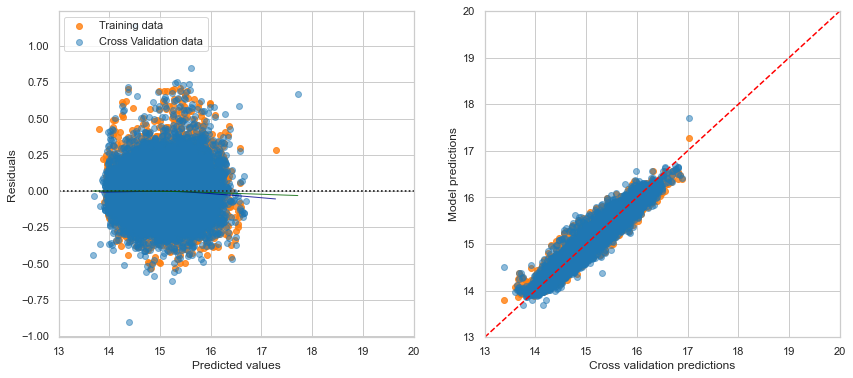

In [633]:
predicted_NN = cross_val_predict(keras_reg, pre_X, pre_y, cv=10, verbose = 50)   

plot_resid(NN_pred_val, predicted_NN, pre_y, "NN_resid_opt1")

In [94]:
from scipy.stats import reciprocal
reciprocal(3e-4, 3e-2)

In [108]:
rnd_search_cv

housing_predictions = rnd_search_cv.predict(pre_X)
rnd_NeuNet_mse = mean_squared_error(pre_y, housing_predictions)
rnd_NeuNet_rmse = np.sqrt(rnd_NeuNet_mse)

rnd_exp_neu_pred = np.exp(rnd_search_cv.predict(pre_X))
print("Predictions:",rnd_exp_neu_pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), rnd_exp_neu_pred))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), rnd_exp_neu_pred))



Predictions: [2236217.8 3358433.2 5457122.  ... 6737103.5 1502760.9 4514080. ]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 379338.8439147546
Relative loss: 0.12511588354115566


In [102]:
rnd_search_cv.best_params_

{'learning_rate': 0.00869508703624965, 'n_hidden': 4, 'n_neurons': 38}

In [103]:
rnd_search_cv.best_score_

-0.03940339758992195

In [110]:
best_model = rnd_search_cv.best_estimator_.model

In [113]:
rnd_search_cv.cv_results_['params']

[{'learning_rate': 0.0004755211741826921, 'n_hidden': 2, 'n_neurons': 290},
 {'learning_rate': 0.002704508447624976, 'n_hidden': 5, 'n_neurons': 397},
 {'learning_rate': 0.018505660344602, 'n_hidden': 8, 'n_neurons': 410},
 {'learning_rate': 0.0004773839749315815, 'n_hidden': 2, 'n_neurons': 171},
 {'learning_rate': 0.008026117644498, 'n_hidden': 3, 'n_neurons': 86},
 {'learning_rate': 0.00778748203400017, 'n_hidden': 8, 'n_neurons': 245},
 {'learning_rate': 0.0030748224973088105, 'n_hidden': 8, 'n_neurons': 364},
 {'learning_rate': 0.0017688400266958804, 'n_hidden': 8, 'n_neurons': 53},
 {'learning_rate': 0.00030147102047204007, 'n_hidden': 3, 'n_neurons': 187},
 {'learning_rate': 0.001009849793798664, 'n_hidden': 5, 'n_neurons': 359},
 {'learning_rate': 0.000751005002994313, 'n_hidden': 0, 'n_neurons': 468},
 {'learning_rate': 0.015081262131281676, 'n_hidden': 8, 'n_neurons': 59},
 {'learning_rate': 0.006902701634181359, 'n_hidden': 6, 'n_neurons': 393},
 {'learning_rate': 0.01317540

## Stacking Ensemble regression

In [265]:
import scikeras
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [317]:

estimators = [
    ("Random Forest", forest_reg),
    ("Lasso", las_poly_lin_reg),
    ('MLPReg', r2),
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest', RandomForestRegressor()),
                              ('Lasso', Lasso(alpha=0.0005)),
                              ('MLPReg',
                               MLPRegressor(batch_size=None, build_fn=None, callbacks=None, epochs=20, loss=None, metrics=None, model=None, optimizer='rmsprop', random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [318]:
stacking_regressor.fit(pre_X, pre_y)

StackingRegressor(estimators=[('Random Forest', RandomForestRegressor()),
                              ('Lasso', Lasso(alpha=0.0005)),
                              ('MLPReg',
                               MLPRegressor(batch_size=None, build_fn=None, callbacks=None, epochs=20, loss=None, metrics=None, model=None, optimizer='rmsprop', random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [744]:
stacking_regressor.final_estimator_

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [637]:
from typing import Dict, Iterable, Any
class MLPRegressor(KerasRegressor):

    def __init__(
        self,
        n_hidden = 4,
        neurons = 30,
        Optimizer = keras.optimizers.SGD, #"adam",
        learning_rate=0.003,
        epochs=10,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.neurons = neurons
        self.n_hidden = n_hidden
        self.Optimizer = Optimizer
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):
        model = keras.Sequential()
        inp = keras.layers.Input(shape=(self.n_features_in_))
        model.add(inp)
        for layers in range(self.n_hidden):
            layer = keras.layers.Dense(self.neurons, activation="relu")
            model.add(layer)
        out = keras.layers.Dense(1)
        model.add(out)
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model
 

In [641]:
# simple linear regression
lin_reg_es = LinearRegression()


# 2nd degree polynomial linear regression
poly_pipeline = make_pipeline(poly_features,
                              Lasso(alpha = 0.01))

# Random forest regression
RF_reg_es = RandomForestRegressor(max_depth=14, max_features=60, min_samples_leaf=30,
                                   min_samples_split=150, n_estimators=100)

# keras model wrapper
NN_reg_es = MLPRegressor(epochs=500, batch_size = 64)


In [687]:
poly_pipeline = make_pipeline(poly_features,
                              Lasso(alpha = 0.01))
poly_pipeline.fit(pre_X, pre_y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=0.01))])

In [642]:
from sklearn.linear_model import RidgeCV

estimators = [
    ("Linear", lin_reg_es),
    ("poly", poly_pipeline),
    ("Random Forest", RF_reg_es),
    ('MLPReg', NN_reg_es),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor.fit(pre_X, pre_y)


StackingRegressor(estimators=[('Linear', LinearRegression()),
                              ('poly',
                               Pipeline(steps=[('polynomialfeatures',
                                                PolynomialFeatures(include_bias=False)),
                                               ('lasso', Lasso(alpha=0.01))])),
                              ('Random Forest',
                               RandomForestRegressor(max_depth=14,
                                                     max_features=60,
                                                     min_samples_leaf=30,
                                                     min_samples_split=150)),
                              ('MLPReg',
                               MLPRegressor(batch_size=64, build_fn=None, callbacks=None, epochs=500, loss=None, metrics=None, model=None, optimizer='rmsprop', random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False))],

In [644]:




pred_ES = stacking_regressor.predict(pre_X)
print("predictions:", pred)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y), np.exp(pred)))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), np.exp(pred)))

ES_mse = mean_squared_error(pre_y, pred_ES)
ES_rmse = np.sqrt(ES_mse)
print("Esemble stacking rmse:", ES_rmse)


predictions: [14.52356058 14.98648234 15.47647172 ... 15.5638524  14.25523246
 15.5023024 ]
Label-values: [1685000. 3625000. 5900000. ... 5000000. 1545000. 5300000.]
Absolute error: 341657.1699371826
Relative loss: 0.0824614124091651
Esemble stacking rmse: 0.10896383406486176


In [645]:
ES_scores = cross_val_score(stacking_regressor, pre_X, pre_y,
                             scoring="neg_mean_squared_error", cv=10, verbose = 50, n_jobs = 1)


ES_rmse_scores = np.sqrt(-ES_scores)

display_scores(ES_rmse_scores)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=28.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.8min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=27.6min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 56.4min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.012) total time=27.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 83.7min remaining:    0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.013) total time=24.0min
[Parallel(n_jobs=1)]: Done   4 

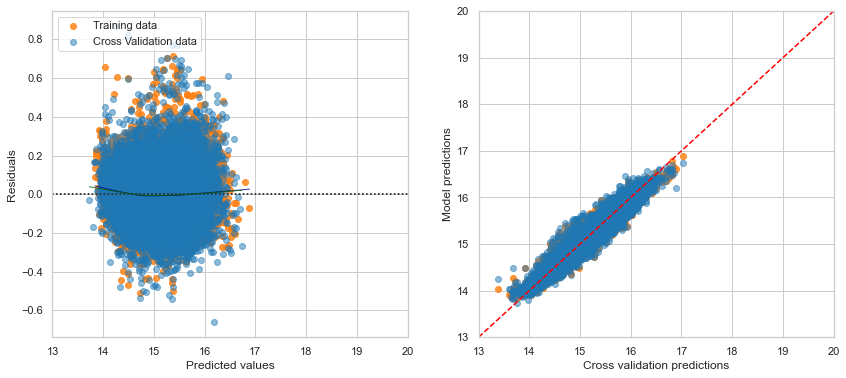

In [646]:

predicted_ES = cross_val_predict(stacking_regressor, pre_X, pre_y, cv=10, verbose = 0)   

plot_resid(pred_ES, predicted_ES, pre_y, "ES_resid1")

\begin{tabular}{lrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 15 \% \\
\midrule
Esemble Stacking &            8.8871 &              7.4169 &      83.8245 \\
\bottomrule
\end{tabular}



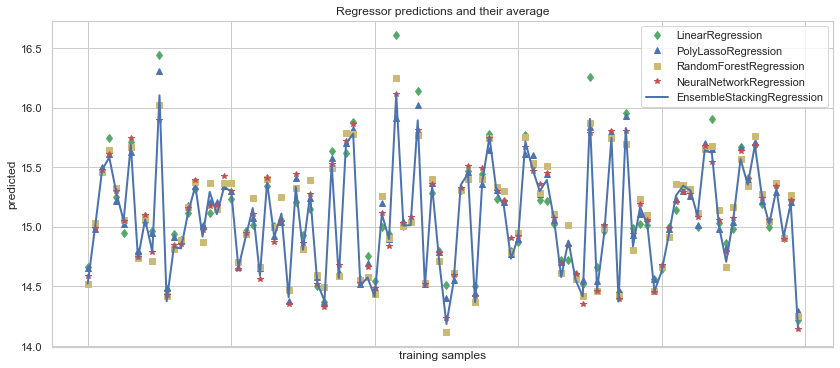

In [693]:
xt = pre_X[:100]

pred1 = lin_reg.predict(xt)
pred2 = poly_pipeline.predict(xt)
pred3 = forest_reg.predict(xt)
pred4 = keras_reg.predict(xt)
pred5 = stacking_regressor.predict(xt)


plt.figure(figsize = (14, 6))
plt.plot(pred1, "gd", label="LinearRegression")
plt.plot(pred2, "b^", label="PolyLassoRegression")
plt.plot(pred3, "ys", label="RandomForestRegression")
plt.plot(pred4, "r*", label="NeuralNetworkRegression")
plt.plot(pred5, linewidth=2.0, label="EnsembleStackingRegression")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")
plt.savefig("ES_all_plot")

In [295]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## Results

In [ ]:
Find_target = 0

pre_y = np.log(housing[:,Find_target].astype(float))
pre_X = np.delete(housing, obj = Find_target , axis = 1)

lin_reg = LinearRegression()
lin_reg.fit(pre_X, pre_y)

pred_val = lin_reg.predict(pre_X)
exp_pred_val = np.exp(pred_val)

print("Predictions:",exp_pred_val)
print("Label-values:", np.exp(pre_y))
print("Absolute error:", mean_absolute_error(np.exp(pre_y),exp_pred_val))
print("Relative loss:", mean_absolute_percentage_error(np.exp(pre_y), exp_pred_val))

housing_predictions = lin_reg.predict(pre_X)
lin_mse = mean_squared_error(pre_y, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
print("Linear rmse:", lin_rmse)



In [728]:
Find_target = 0

test_y = np.log(holdout_validation[:,Find_target].astype(float))
test_X = np.delete(holdout_validation, obj = Find_target , axis = 1)

y_test_pred = lin_reg.predict(test_X)
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_val)
print("Test Label-values:", np.exp(test_y))
print("test Absolute error:", mean_absolute_error(np.exp(test_y),exp_pred_test))
print("test Relative loss:", mean_absolute_percentage_error(np.exp(test_y), exp_pred_test))
print("RMSE loss:", np.sqrt(mean_squared_error(test_y, y_test_pred)))


0.15924901423585341
Test Predictions: [2338598.66637607 3263430.93227334 5222082.24601389 ... 5767985.84294721
 1742453.25686895 4970457.75629155]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]
test Absolute error: 509559.07093445846
test Relative loss: 0.1227373806124501
RMSE loss: 0.15924901423585341


In [699]:
len(y_test_pred), len(test_y)

(6380, 6380)

<Figure size 1008x432 with 0 Axes>

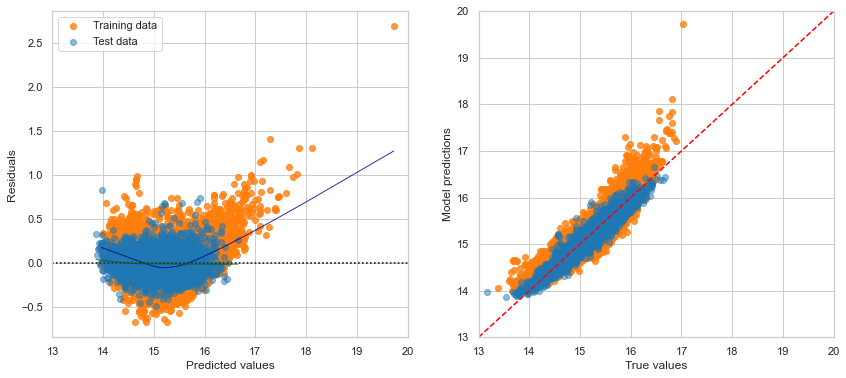

In [701]:
plt.figure(figsize = (14, 6))
def plot_resid2(pred_val, test_pred, y_train, y_test, name):
    plt.figure(figsize = (14, 6))
    ax = plt.subplot(1,2,1)
    sns.residplot(x=pred_val, y=pred_val - y_train, lowess=True, color = "tab:orange", 
                              scatter_kws={'alpha': 0.8}, 
                              line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
    sns.residplot(x=test_pred, y=test_pred - y_test, lowess=True, color = "tab:blue", 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'darkgreen', 'lw': 1, 'alpha': 0.8}, label='Test data')

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.xlim([13, 20])

    ax = plt.subplot(1,2,2)
    plt.scatter(y_train, pred_val, alpha=0.8, c = "tab:orange")
    plt.scatter(y_test, test_pred, alpha=0.5, c = "tab:blue")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
    plt.ylabel('Model predictions')
    plt.xlabel('True values')
    plt.xlim([13, 20])
    plt.ylim([13, 20])
    plt.savefig(name)


y_train_pred = lin_reg.predict(pre_X)  

plot_resid2(y_train_pred, y_test_pred, pre_y, test_y, "test_lin_resid1")




In [598]:
from scipy import stats
confidence = 0.95
squared_errors = (y_test_pred - test_y) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))



array([0.15359315, 0.16471078])

In [711]:
mean_percent = np.mean(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100

median_percent = np.median(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100


def within15(y_pred, y_test):
    dataset = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test}, columns=['y_pred', 'y_test'])
    dataset['exp_y_pred'] = np.exp(dataset.y_pred)
    dataset['exp_y_test'] = np.exp(dataset.y_test)
    dataset['difference'] = abs(dataset.exp_y_test-dataset.exp_y_pred)
    dataset['diffpercent'] = dataset.difference / dataset.exp_y_test *100
    below_20 = (len(dataset[dataset.diffpercent < 20]) / len(dataset)) *100
    below_15 = (len(dataset[dataset.diffpercent < 15]) / len(dataset)) *100
    below_10 = (len(dataset[dataset.diffpercent < 10]) / len(dataset)) *100
    return below_20, below_15, below_10

dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 20 %': [within15(y_test_pred, test_y)[0]],
                    'Within 15 %': [within15(y_test_pred, test_y)[1]],
                    'Within 10 %': [within15(y_test_pred, test_y)[2]]},
                        index = ['Linear'])

print(dev3.round(4).to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 20 \% &  Within 15 \% &  Within 10 \% \\
\midrule
Linear &           12.2737 &              9.3688 &      83.4013 &      70.5486 &       52.931 \\
\bottomrule
\end{tabular}



#### Polynomial Regression

In [729]:

poly_features = PolynomialFeatures(degree = 2, include_bias=False)
test_X_poly = poly_features.fit_transform(test_X)

y_test_pred = las_poly_lin_reg.predict(test_X_poly)
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_val)
print("Test Label-values:", np.exp(test_y))
print("test Absolute error:", mean_absolute_error(np.exp(test_y),exp_pred_test))
print("test Relative loss:", mean_absolute_percentage_error(np.exp(test_y), exp_pred_test))
print("RMSE loss:", np.sqrt(mean_squared_error(test_y, y_test_pred)))



0.13969309278988504
Test Predictions: [2338598.66637607 3263430.93227334 5222082.24601389 ... 5767985.84294721
 1742453.25686895 4970457.75629155]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]
test Absolute error: 424951.49829552555
test Relative loss: 0.1080553820414276
RMSE loss: 0.13969309278988504


In [713]:
y_test_pred = las_poly_lin_reg.predict(test_X_poly)

poly_features = PolynomialFeatures(degree = 2, include_bias=False)
train_X_poly = poly_features.fit_transform(pre_X)

y_train_pred = las_poly_lin_reg.predict(train_X_poly)  

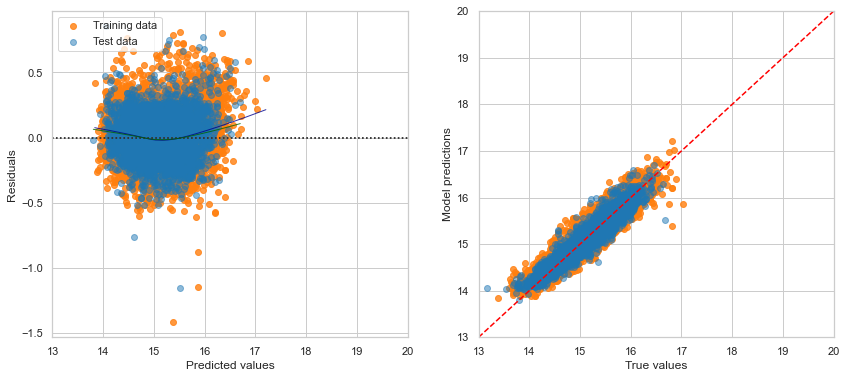

In [702]:
plot_resid2(y_train_pred, y_test_pred, pre_y, test_y, "test_poly_resid1")

In [715]:
mean_percent = np.mean(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100

median_percent = np.median(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100


dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 20 %': [within15(y_test_pred, test_y)[0]],
                    'Within 15 %': [within15(y_test_pred, test_y)[1]],
                    'Within 10 %': [within15(y_test_pred, test_y)[2]]},
                        index = ['polynomial'])

print(dev3.round(4).to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 20 \% &  Within 15 \% &  Within 10 \% \\
\midrule
polynomial &           10.8055 &              8.5722 &      86.1755 &         75.0 &      56.6458 \\
\bottomrule
\end{tabular}



#### Random Forest

In [730]:



y_test_pred = forest_reg.predict(test_X)
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_val)
print("Test Label-values:", np.exp(test_y))
print("test Absolute error:", mean_absolute_error(np.exp(test_y),exp_pred_test))
print("test Relative loss:", mean_absolute_percentage_error(np.exp(test_y), exp_pred_test))
print("RMSE loss:", np.sqrt(mean_squared_error(test_y, y_test_pred)))


0.13194212513157713
Test Predictions: [2338598.66637607 3263430.93227334 5222082.24601389 ... 5767985.84294721
 1742453.25686895 4970457.75629155]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]
test Absolute error: 406411.2936169245
test Relative loss: 0.10315680848813513
RMSE loss: 0.13194212513157713


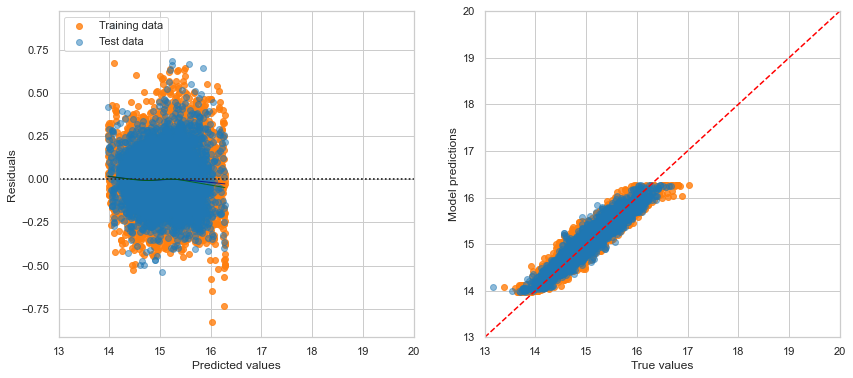

In [703]:
y_test_pred = forest_reg.predict(test_X)

y_train_pred = forest_reg.predict(pre_X)  

plot_resid2(y_train_pred, y_test_pred, pre_y, test_y, "test_forest_resid1")


In [717]:
mean_percent = np.mean(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100

median_percent = np.median(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100


dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 20 %': [within15(y_test_pred, test_y)[0]],
                    'Within 15 %': [within15(y_test_pred, test_y)[1]],
                    'Within 10 %': [within15(y_test_pred, test_y)[2]]},
                        index = ['Random Forest'])

print(dev3.round(4).to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 20 \% &  Within 15 \% &  Within 10 \% \\
\midrule
Random Forest &           10.3157 &              8.0243 &       87.163 &      76.8495 &      59.5611 \\
\bottomrule
\end{tabular}



#### Neural Network

In [718]:
test_y = np.log(holdout_validation[:,Find_target].astype(float))
test_X = np.delete(holdout_validation, obj = Find_target , axis = 1)

y_test_pred = keras_reg.predict(test_X)

mean_percent = np.mean(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100

median_percent = np.median(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100


dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 20 %': [within15(y_test_pred, test_y)[0]],
                    'Within 15 %': [within15(y_test_pred, test_y)[1]],
                    'Within 10 %': [within15(y_test_pred, test_y)[2]]},
                        index = ['Neural Network'])

print(dev3.round(4).to_latex(index=True))


\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 20 \% &  Within 15 \% &  Within 10 \% \\
\midrule
Neural Network &            9.3835 &               7.565 &       91.395 &      81.3166 &      62.5078 \\
\bottomrule
\end{tabular}



In [731]:
y_test_pred = keras_reg.predict(test_X)
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_val)
print("Test Label-values:", np.exp(test_y))
print("test Absolute error:", mean_absolute_error(np.exp(test_y),exp_pred_test))
print("test Relative loss:", mean_absolute_percentage_error(np.exp(test_y), exp_pred_test))
print("RMSE loss:", np.sqrt(mean_squared_error(test_y, y_test_pred)))


0.1221197044072216
Test Predictions: [2338598.66637607 3263430.93227334 5222082.24601389 ... 5767985.84294721
 1742453.25686895 4970457.75629155]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]
test Absolute error: 372436.5360893417
test Relative loss: 0.09383489082186502
RMSE loss: 0.1221197044072216


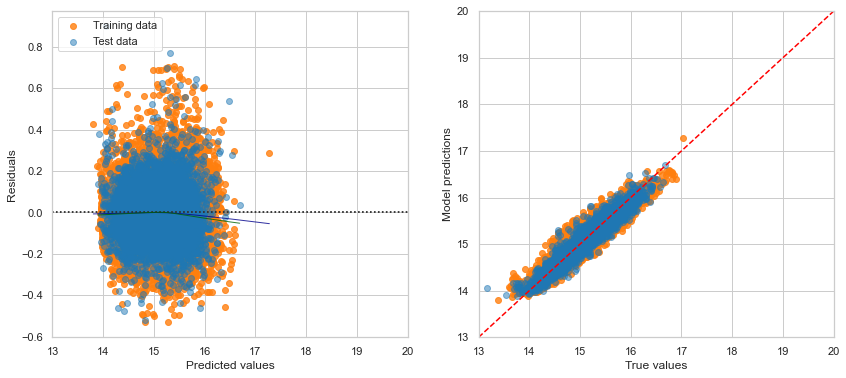

In [705]:
y_test_pred = keras_reg.predict(test_X)

y_train_pred = keras_reg.predict(pre_X)  

plot_resid2(y_train_pred, y_test_pred, pre_y, test_y, "test_NN_resid1")


#### Ensemble Stacking results

In [719]:
test_y = np.log(holdout_validation[:,Find_target].astype(float))
test_X = np.delete(holdout_validation, obj = Find_target , axis = 1)

y_test_pred = stacking_regressor.predict(test_X)

mean_percent = np.mean(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100

median_percent = np.median(abs(np.exp(test_y)-np.exp(y_test_pred))/np.exp(test_y))*100


dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 20 %': [within15(y_test_pred, test_y)[0]],
                    'Within 15 %': [within15(y_test_pred, test_y)[1]],
                    'Within 10 %': [within15(y_test_pred, test_y)[2]]},
                        index = ['Esemble Stacking'])

print(dev3.round(4).to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 20 \% &  Within 15 \% &  Within 10 \% \\
\midrule
Esemble Stacking &            8.8871 &              7.4169 &      93.1505 &      83.8245 &      64.1693 \\
\bottomrule
\end{tabular}



In [732]:
y_test_pred = stacking_regressor.predict(test_X)
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_val)
print("Test Label-values:", np.exp(test_y))
print("test Absolute error:", mean_absolute_error(np.exp(test_y),exp_pred_test))
print("test Relative loss:", mean_absolute_percentage_error(np.exp(test_y), exp_pred_test))
print("RMSE loss:", np.sqrt(mean_squared_error(test_y, y_test_pred)))


0.11723898445716002
Test Predictions: [2338598.66637607 3263430.93227334 5222082.24601389 ... 5767985.84294721
 1742453.25686895 4970457.75629155]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]
test Absolute error: 362492.48381641443
test Relative loss: 0.08887071134528575
RMSE loss: 0.11723898445716002


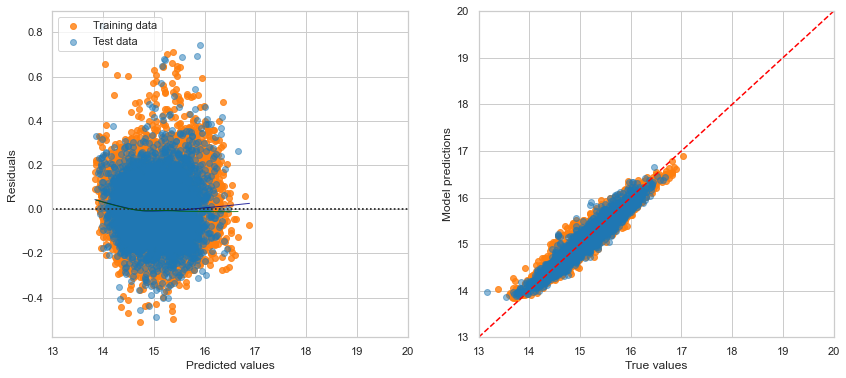

In [706]:
y_test_pred = stacking_regressor.predict(test_X)

y_train_pred = stacking_regressor.predict(pre_X)

plot_resid2(y_train_pred, y_test_pred, pre_y, test_y, "test_ES_resid1")

In [656]:
exp_pred_test = np.exp(y_test_pred)

# RMSE
print(np.sqrt(mean_squared_error(test_y, y_test_pred)))
print("Test Predictions:",exp_pred_test)
print("Test Label-values:", np.exp(test_y))

0.11723898445716002
Test Predictions: [2039373.81718517 4298645.35898693 3904389.97571818 ... 9372741.89420257
 7743050.31321126 1624233.02404983]
Test Label-values: [1995000.         4360000.         3725000.         ... 8449999.99999999
 7100000.         1675000.        ]


In [660]:
len(exp_pred_test)
exp_val = np.exp(test_y)

In [680]:
from numpy import savetxt
import pickle
estimates = np.stack((exp_val, exp_pred_test), axis=1)

np.savetxt('ES_estimations.txt', estimates)  